In [1]:
# %pip install scikit-learn pandas wandb Pillow matplotlib tqdm seaborn

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import json
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, AutoModelWithLMHead, AutoModelForSequenceClassification, TrainingArguments, Trainer
import huggingface_hub as hf_hub
import os
from utils import to_context_free_format, CLASS_MAP, iCLASS_MAP, predictions_to_evaluation_format
import datasets
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
import random
from eval import eval_across_domains
from load import load_prediction_and_gold
import wandb

# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
import tqdm
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.utils.extmath import randomized_svd
from itertools import combinations
nltk.download("stopwords")
plt.rcParams["figure.figsize"] = (20,20)

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
english_stopwords = stopwords.words('english')

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [5]:
train_file = Path.cwd().joinpath("public_data","train_inputs_full.json")

with open(train_file,"r") as f:
    train_dict_data = json.load(f)

In [6]:
full_data = datasets.Dataset.from_list(to_context_free_format(train_file))

In [7]:
full_data_df = full_data.to_pandas()

In [8]:
train_valid_gkf = GroupKFold()
valid_test_gkf = GroupKFold(n_splits=2)

In [9]:
def create_wordcloud(split,text_df):

    domain_tfidf_dict = {}
    for domain in text_df["domain"].unique():
        text_list = text_df.loc[text_df["domain"] == domain,"txt"].values
        tfidf = TfidfVectorizer(ngram_range=(1,1),stop_words=english_stopwords)
        tfidf_matrix = tfidf.fit_transform(text_list).todense()
        tfidf_dict = {}
        for term,idx in tfidf.vocabulary_.items():
            tfidf_dict[term] = [tfidf_matrix[:,idx].mean()]
        tfidf_dict = dict(sorted(tfidf_dict.items(),key=lambda x:x[-1][0],reverse=True))
        domain_tfidf_dict[domain] = tfidf_dict
        
    return domain_tfidf_dict

In [10]:
category_vocab_dict = {}
for idx,(train_idx, valid_idx) in enumerate(train_valid_gkf.split(X=full_data_df,y=full_data_df["label"],groups=full_data_df["report_id"])):
    # Splitting data into Train and validation
    train_df = full_data_df.loc[train_idx,:]    
    og_valid_df = full_data_df.loc[valid_idx,:]

    # Splitting validation data into validation and test
    valid_idx,test_idx = \
    next(iter(valid_test_gkf.split(X=og_valid_df,y=og_valid_df["label"],groups=og_valid_df["report_id"])))
    valid_df = og_valid_df.iloc[valid_idx]
    test_df = og_valid_df.iloc[test_idx]
    category_vocab_dict[idx] = create_wordcloud(idx,test_df)

/tmp/ipykernel_628/1185365391.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


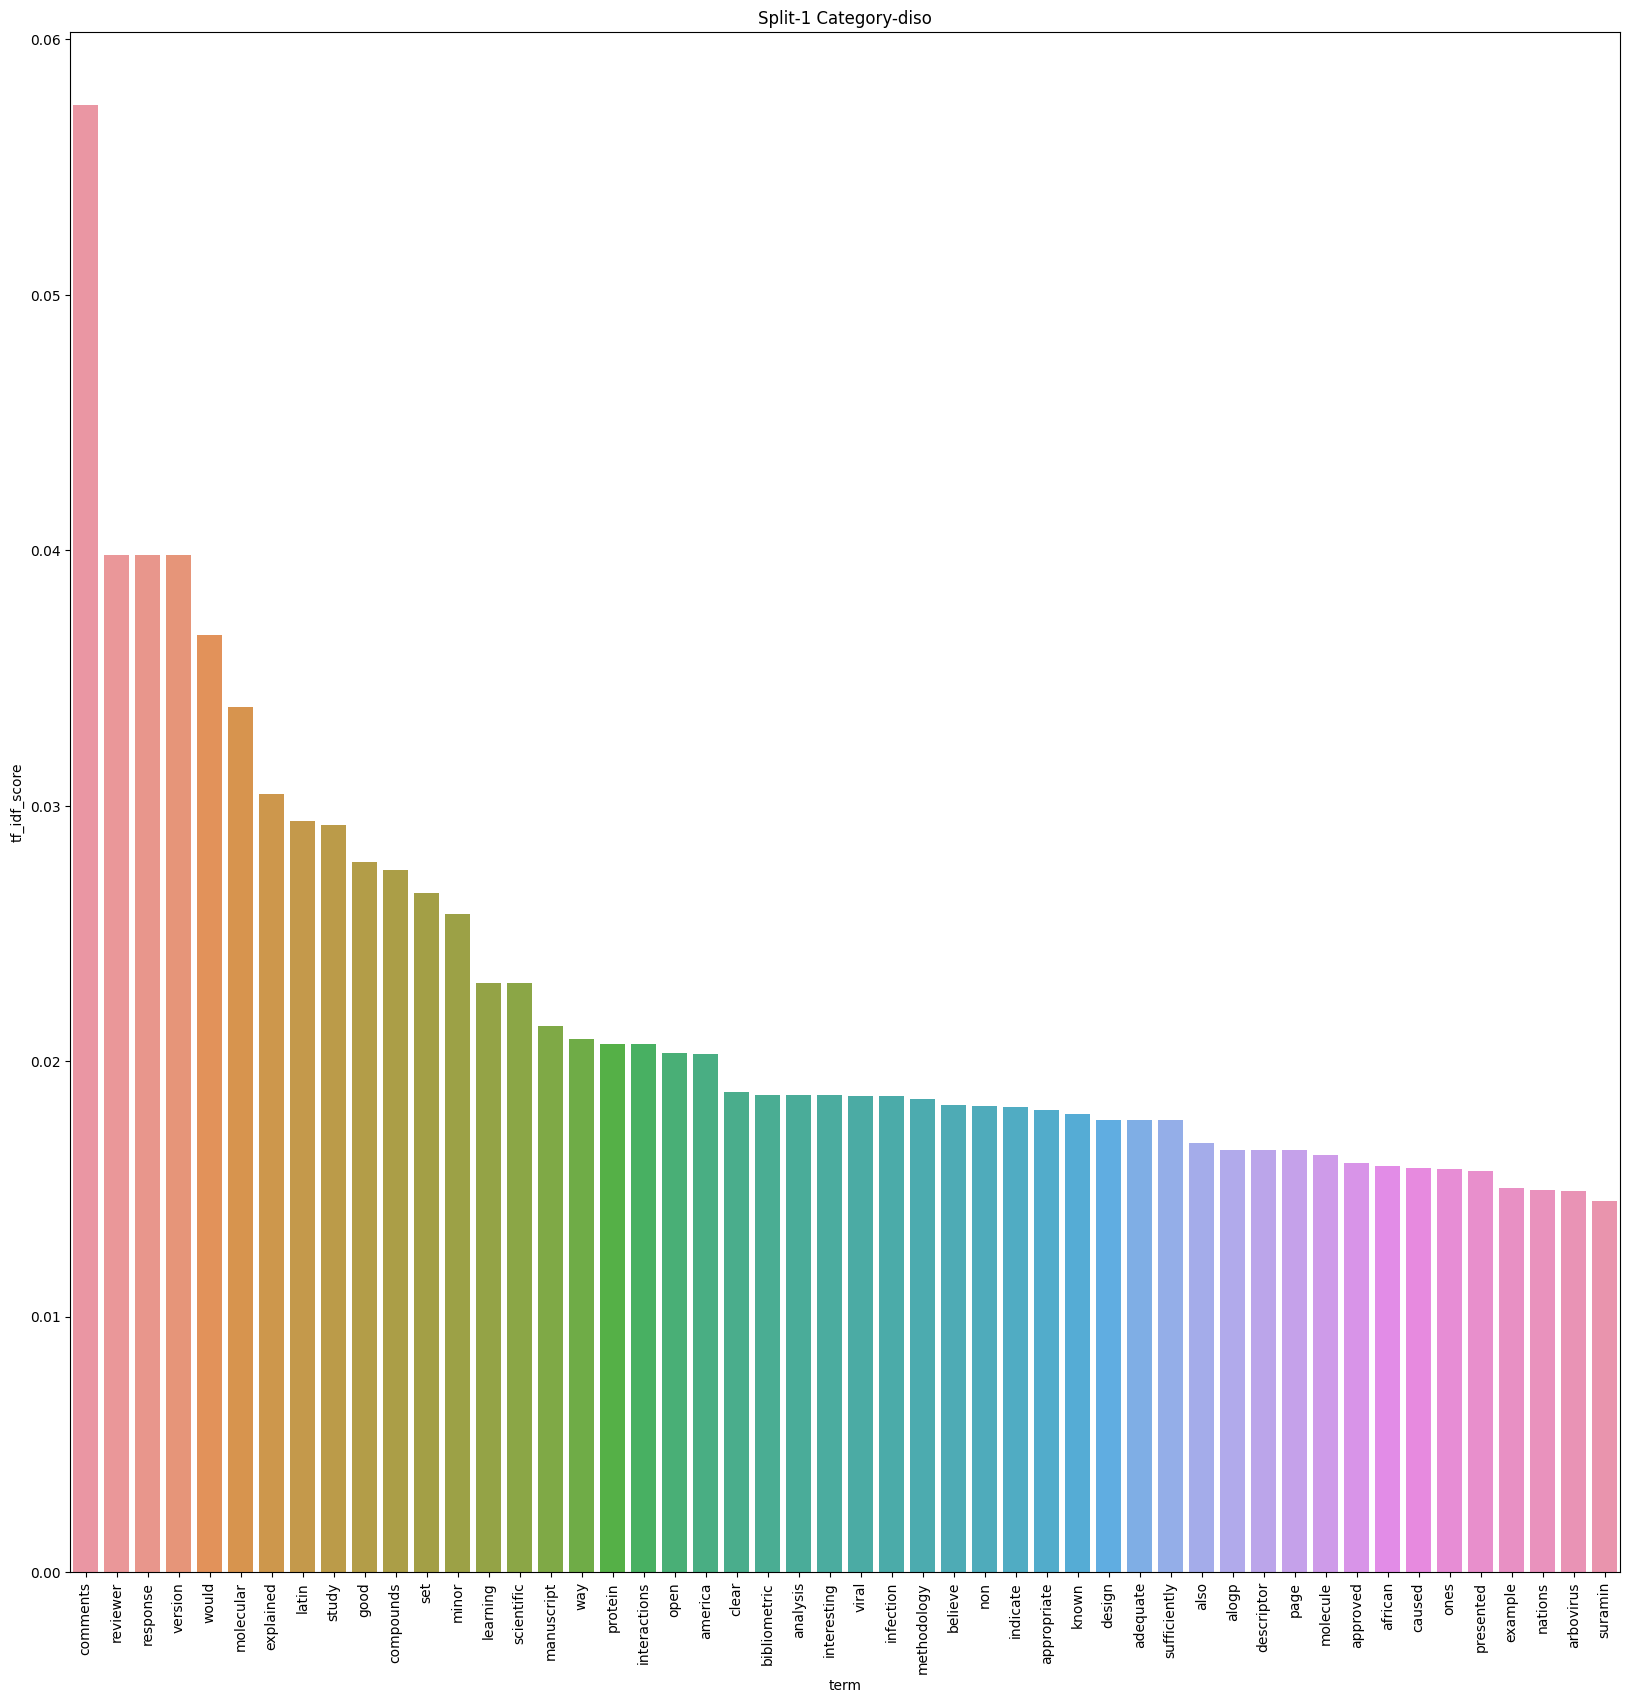

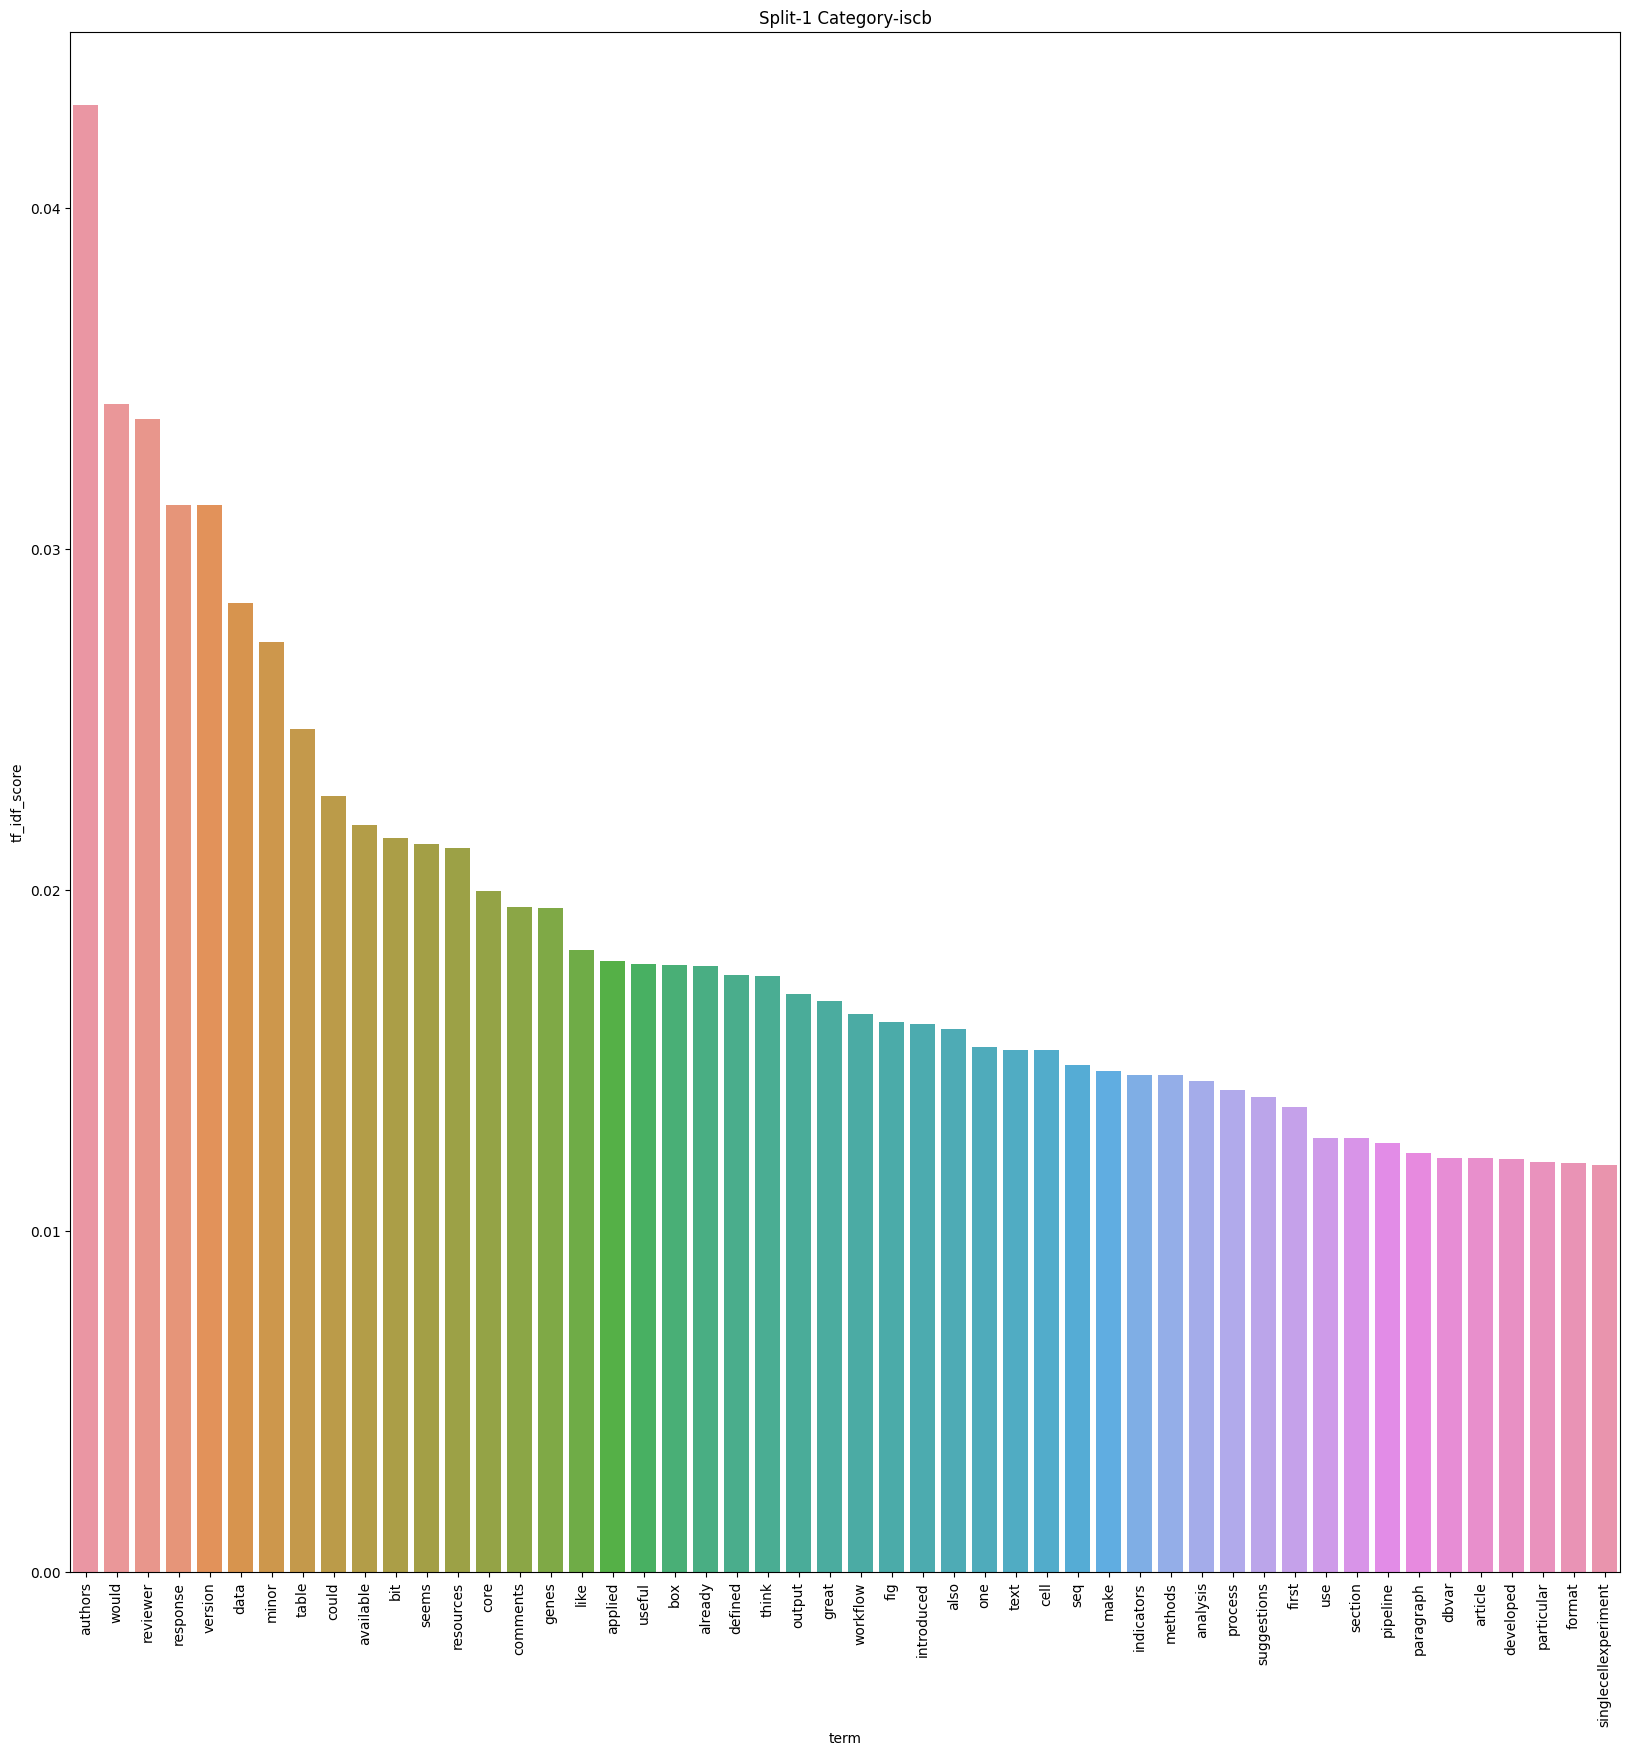

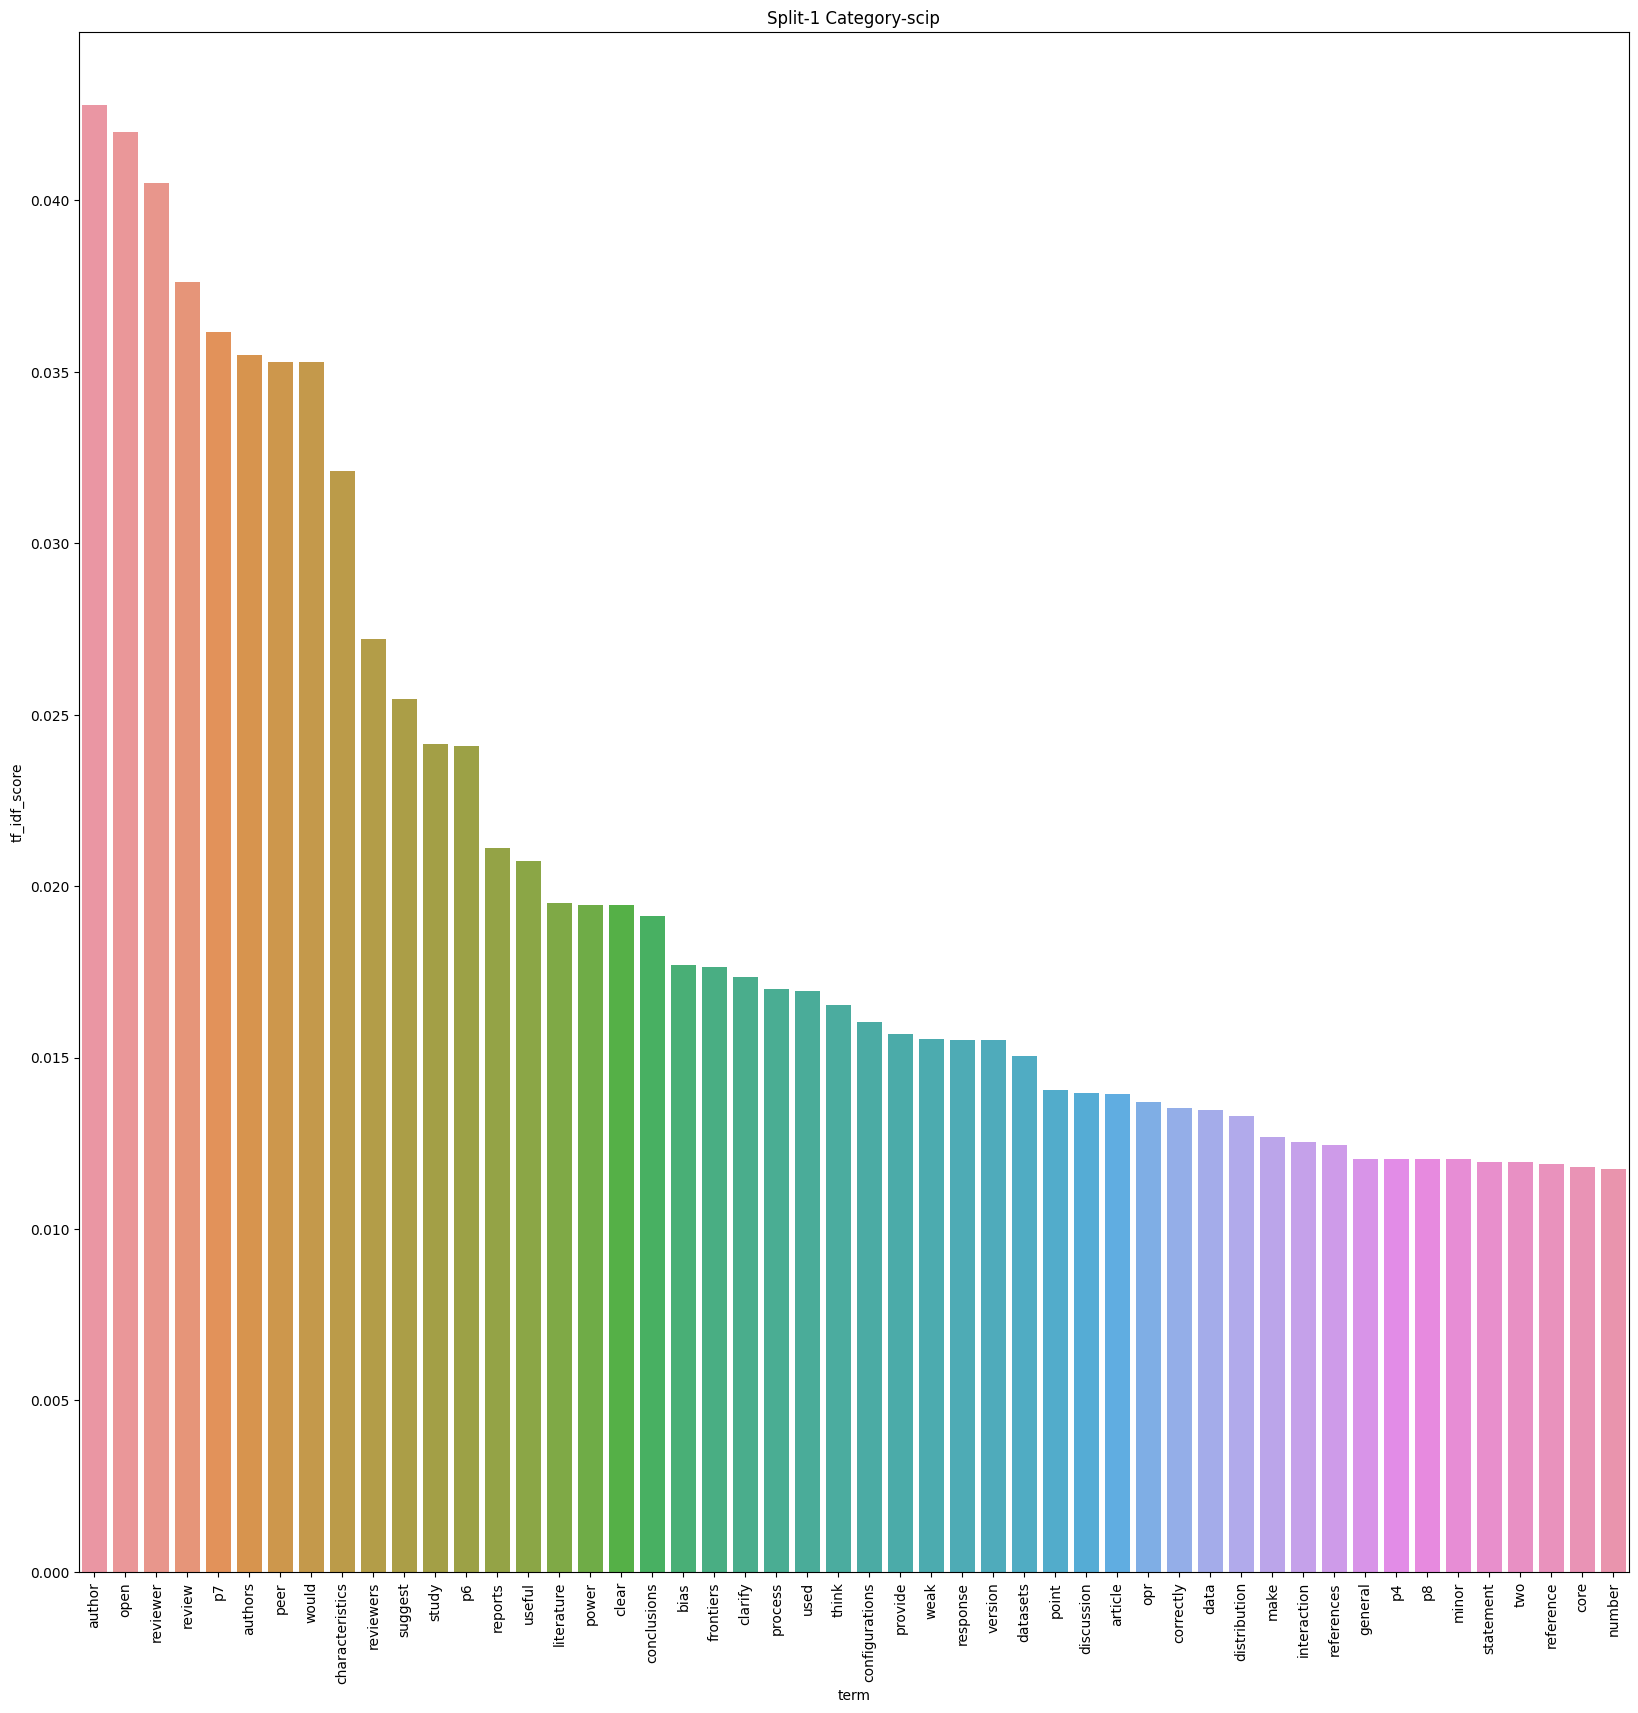

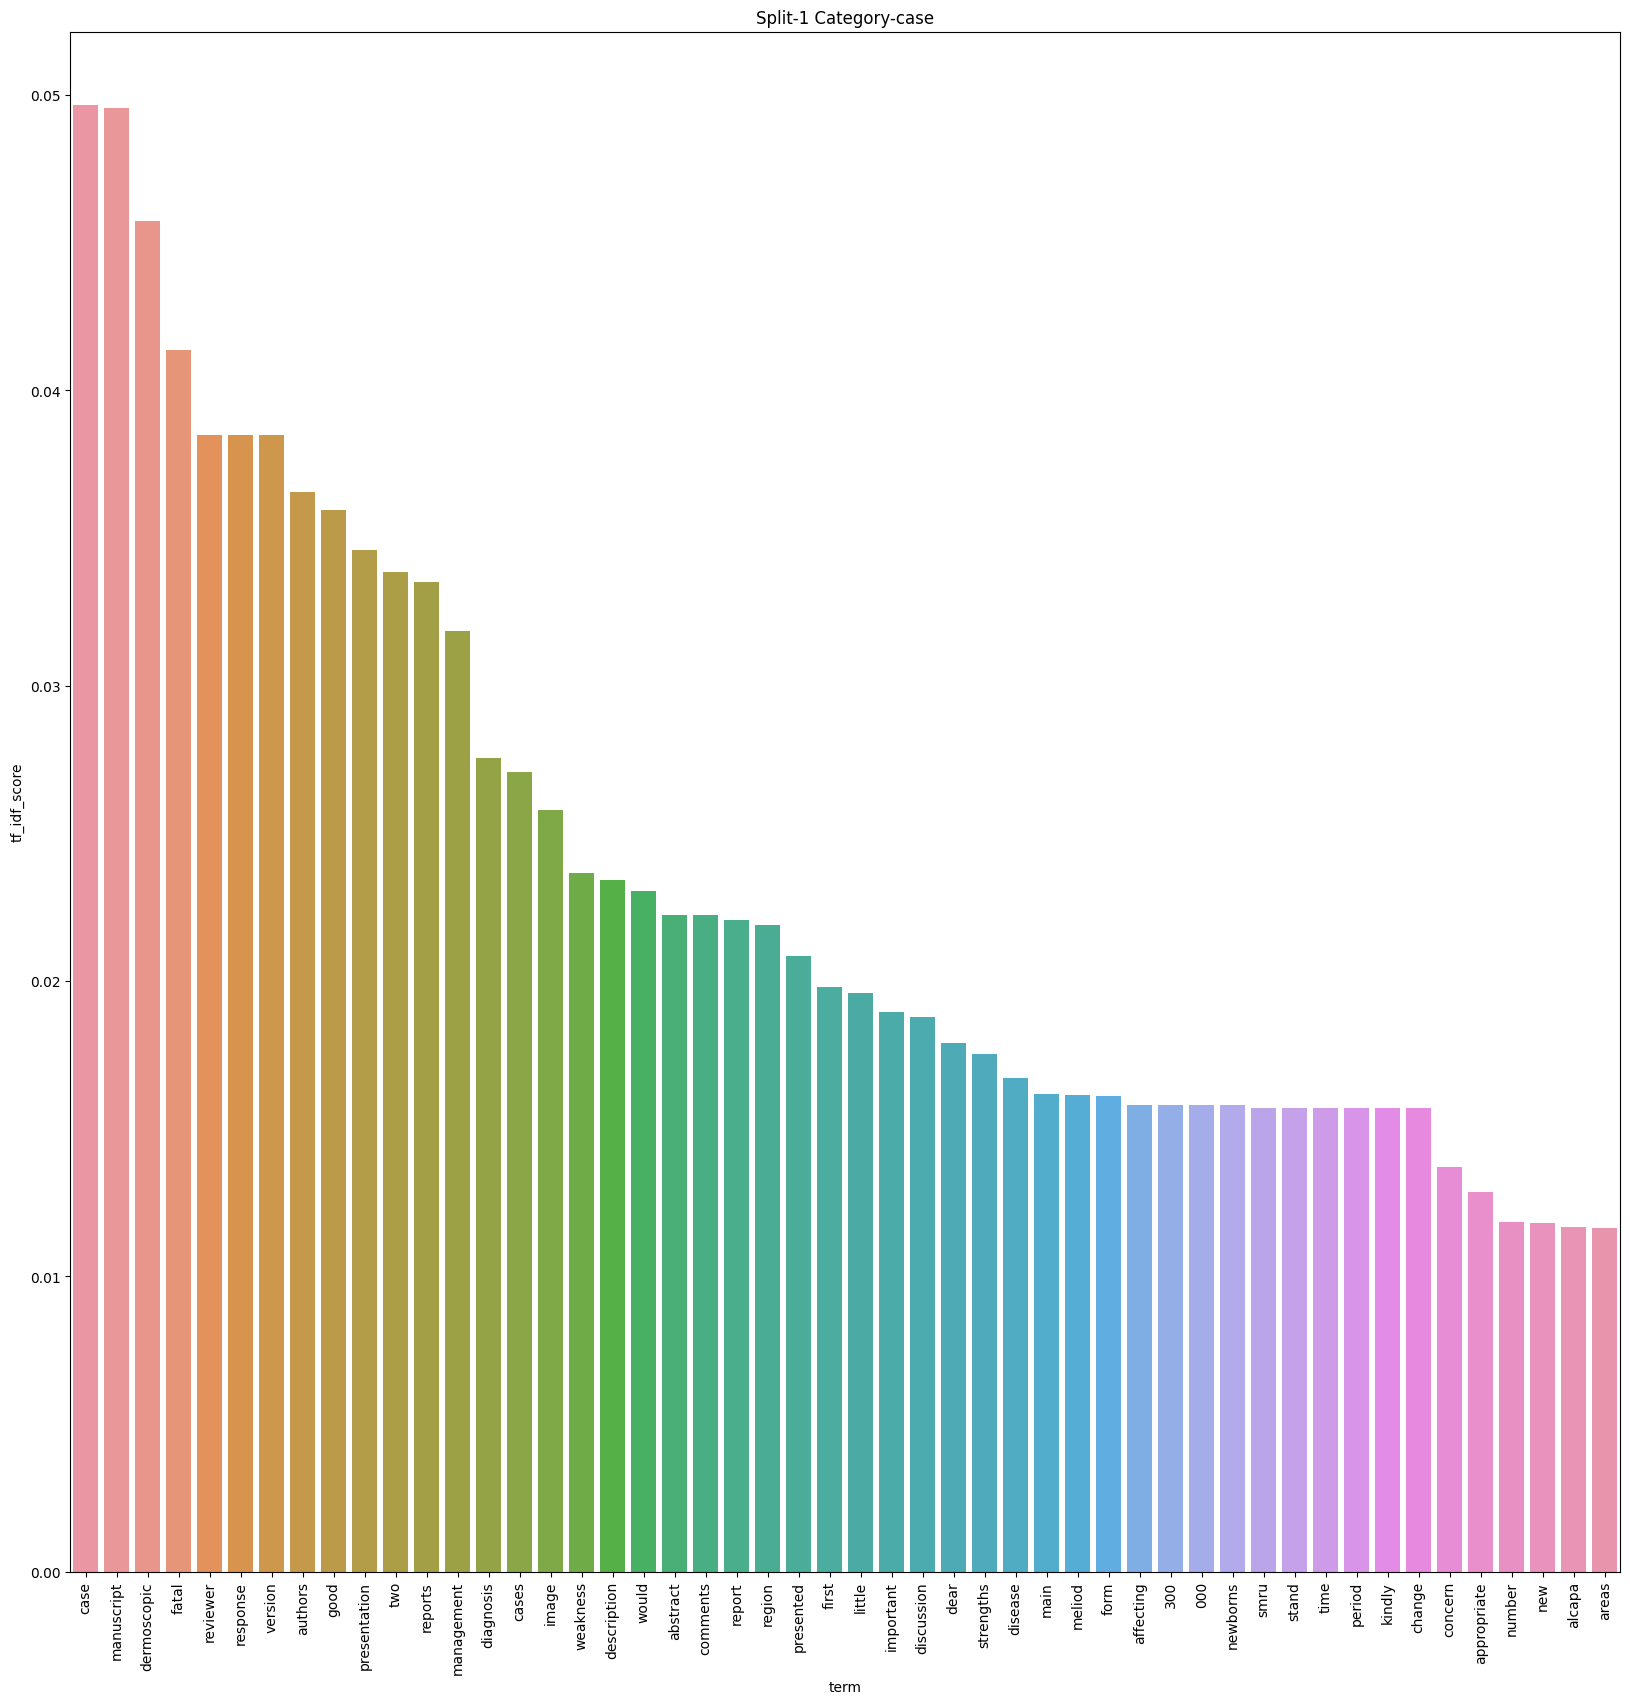

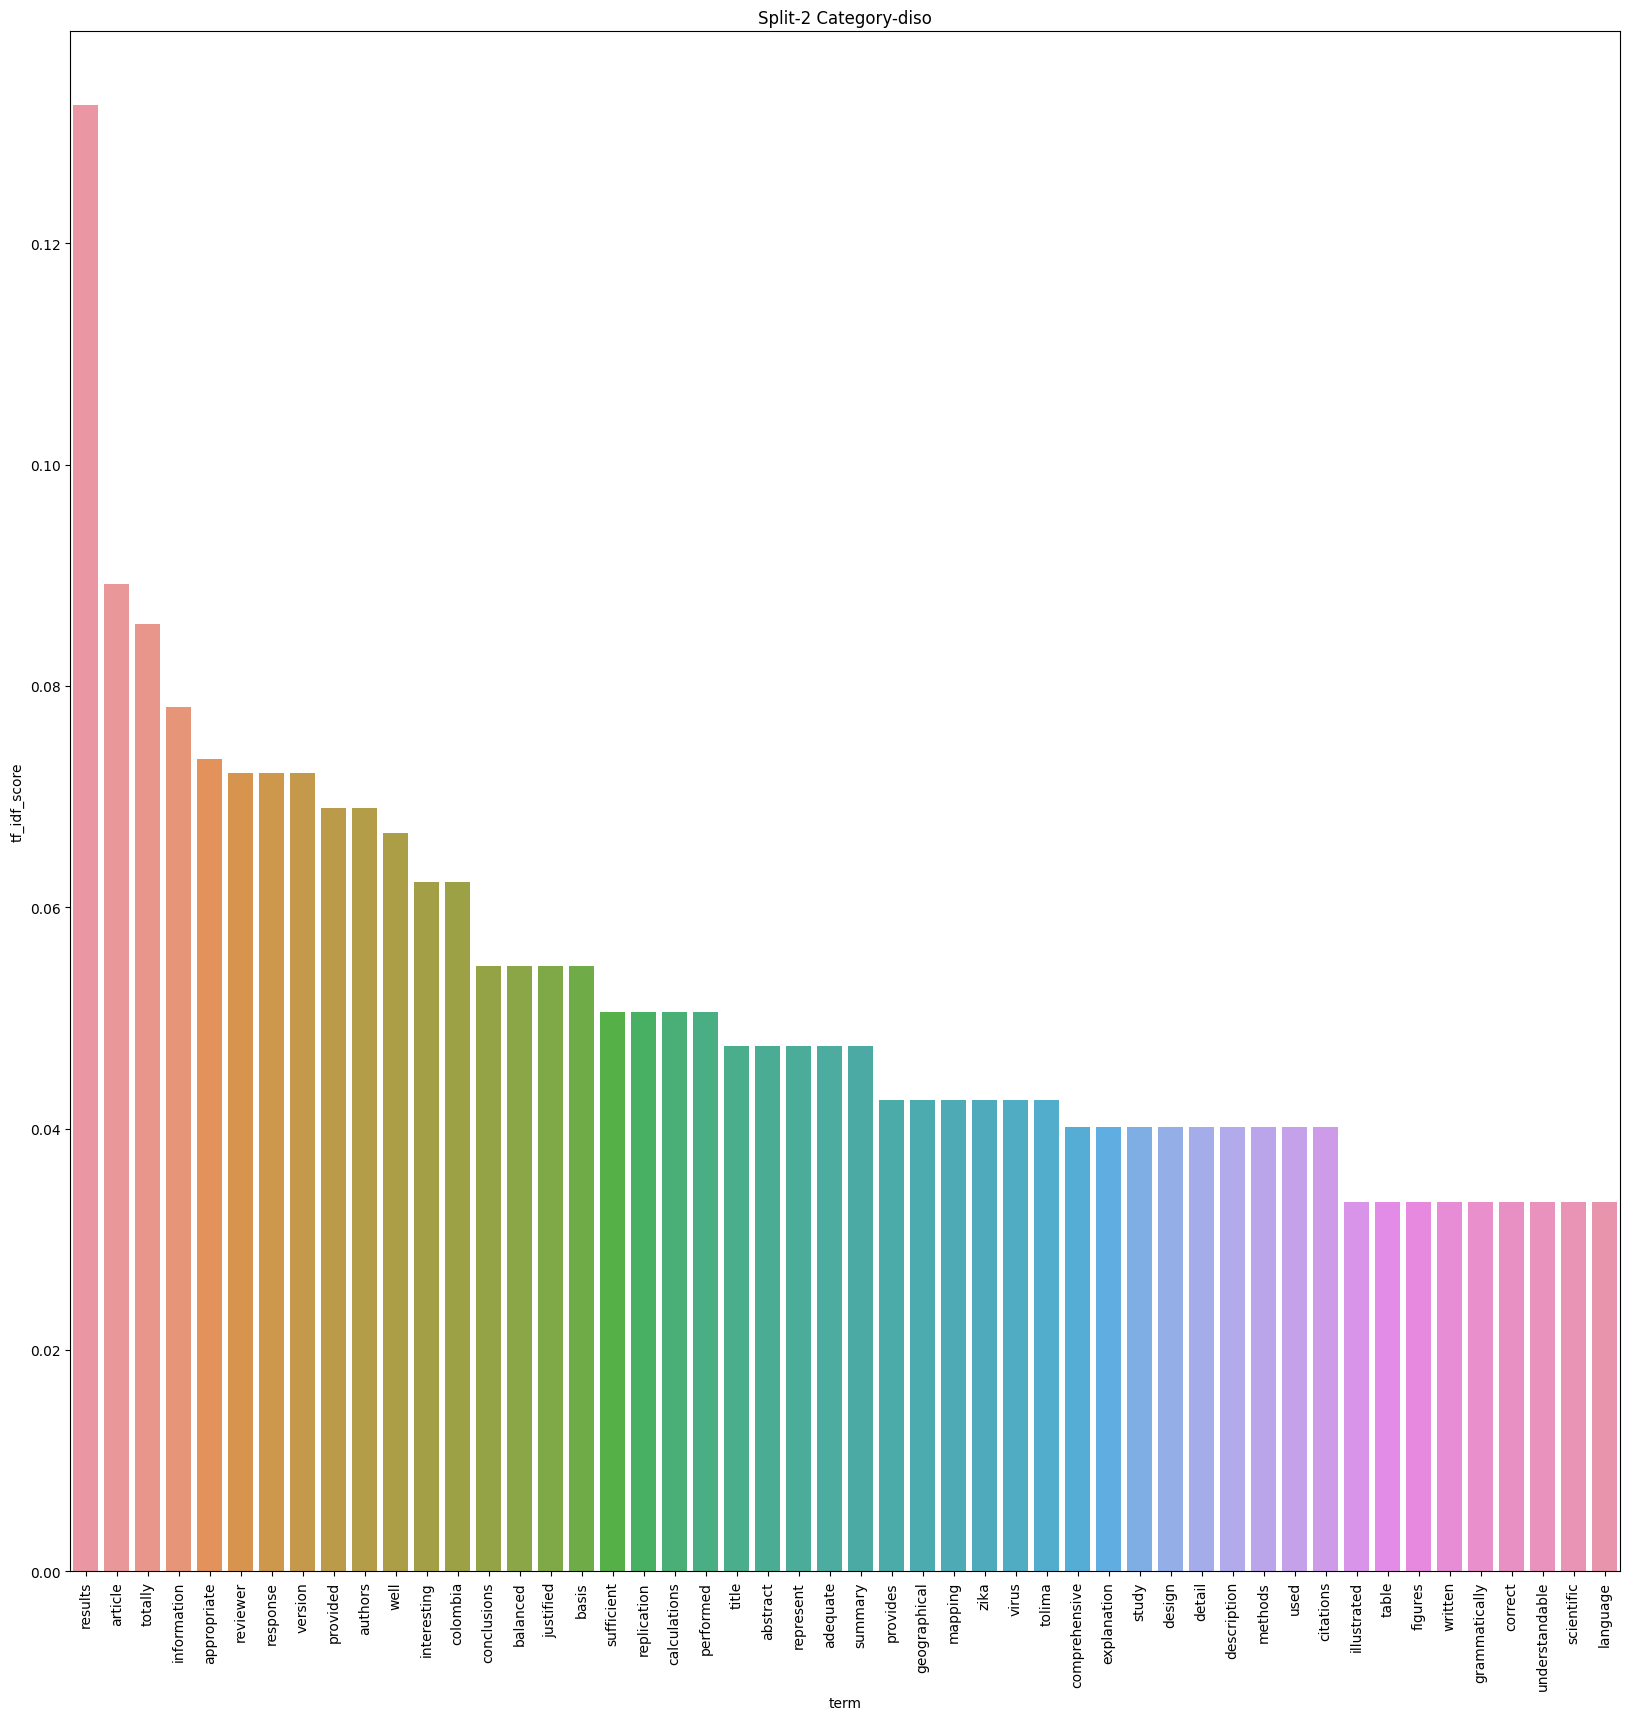

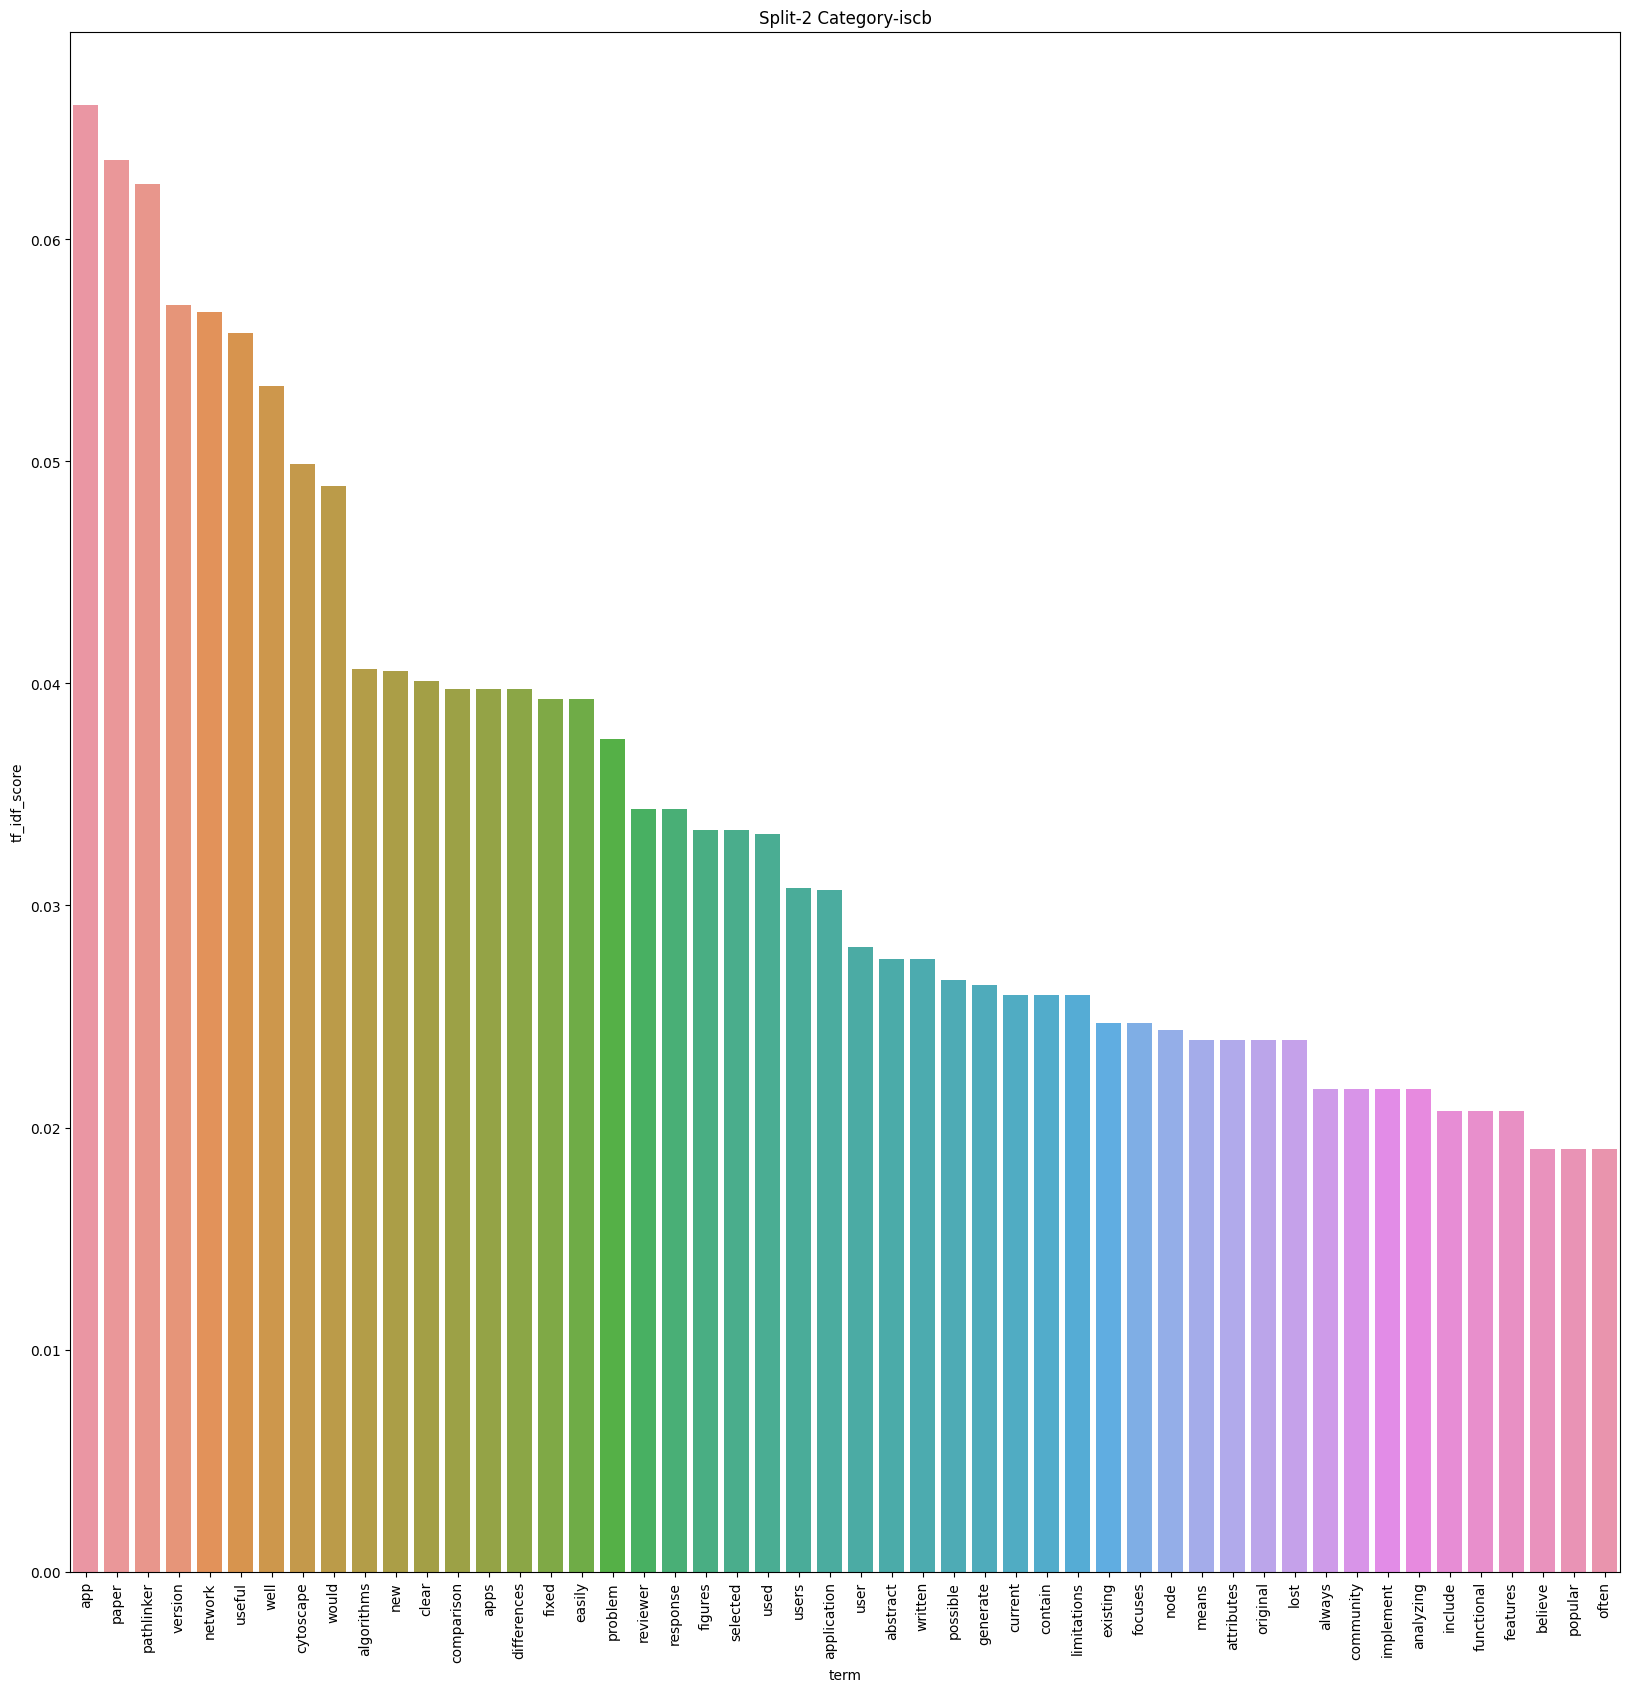

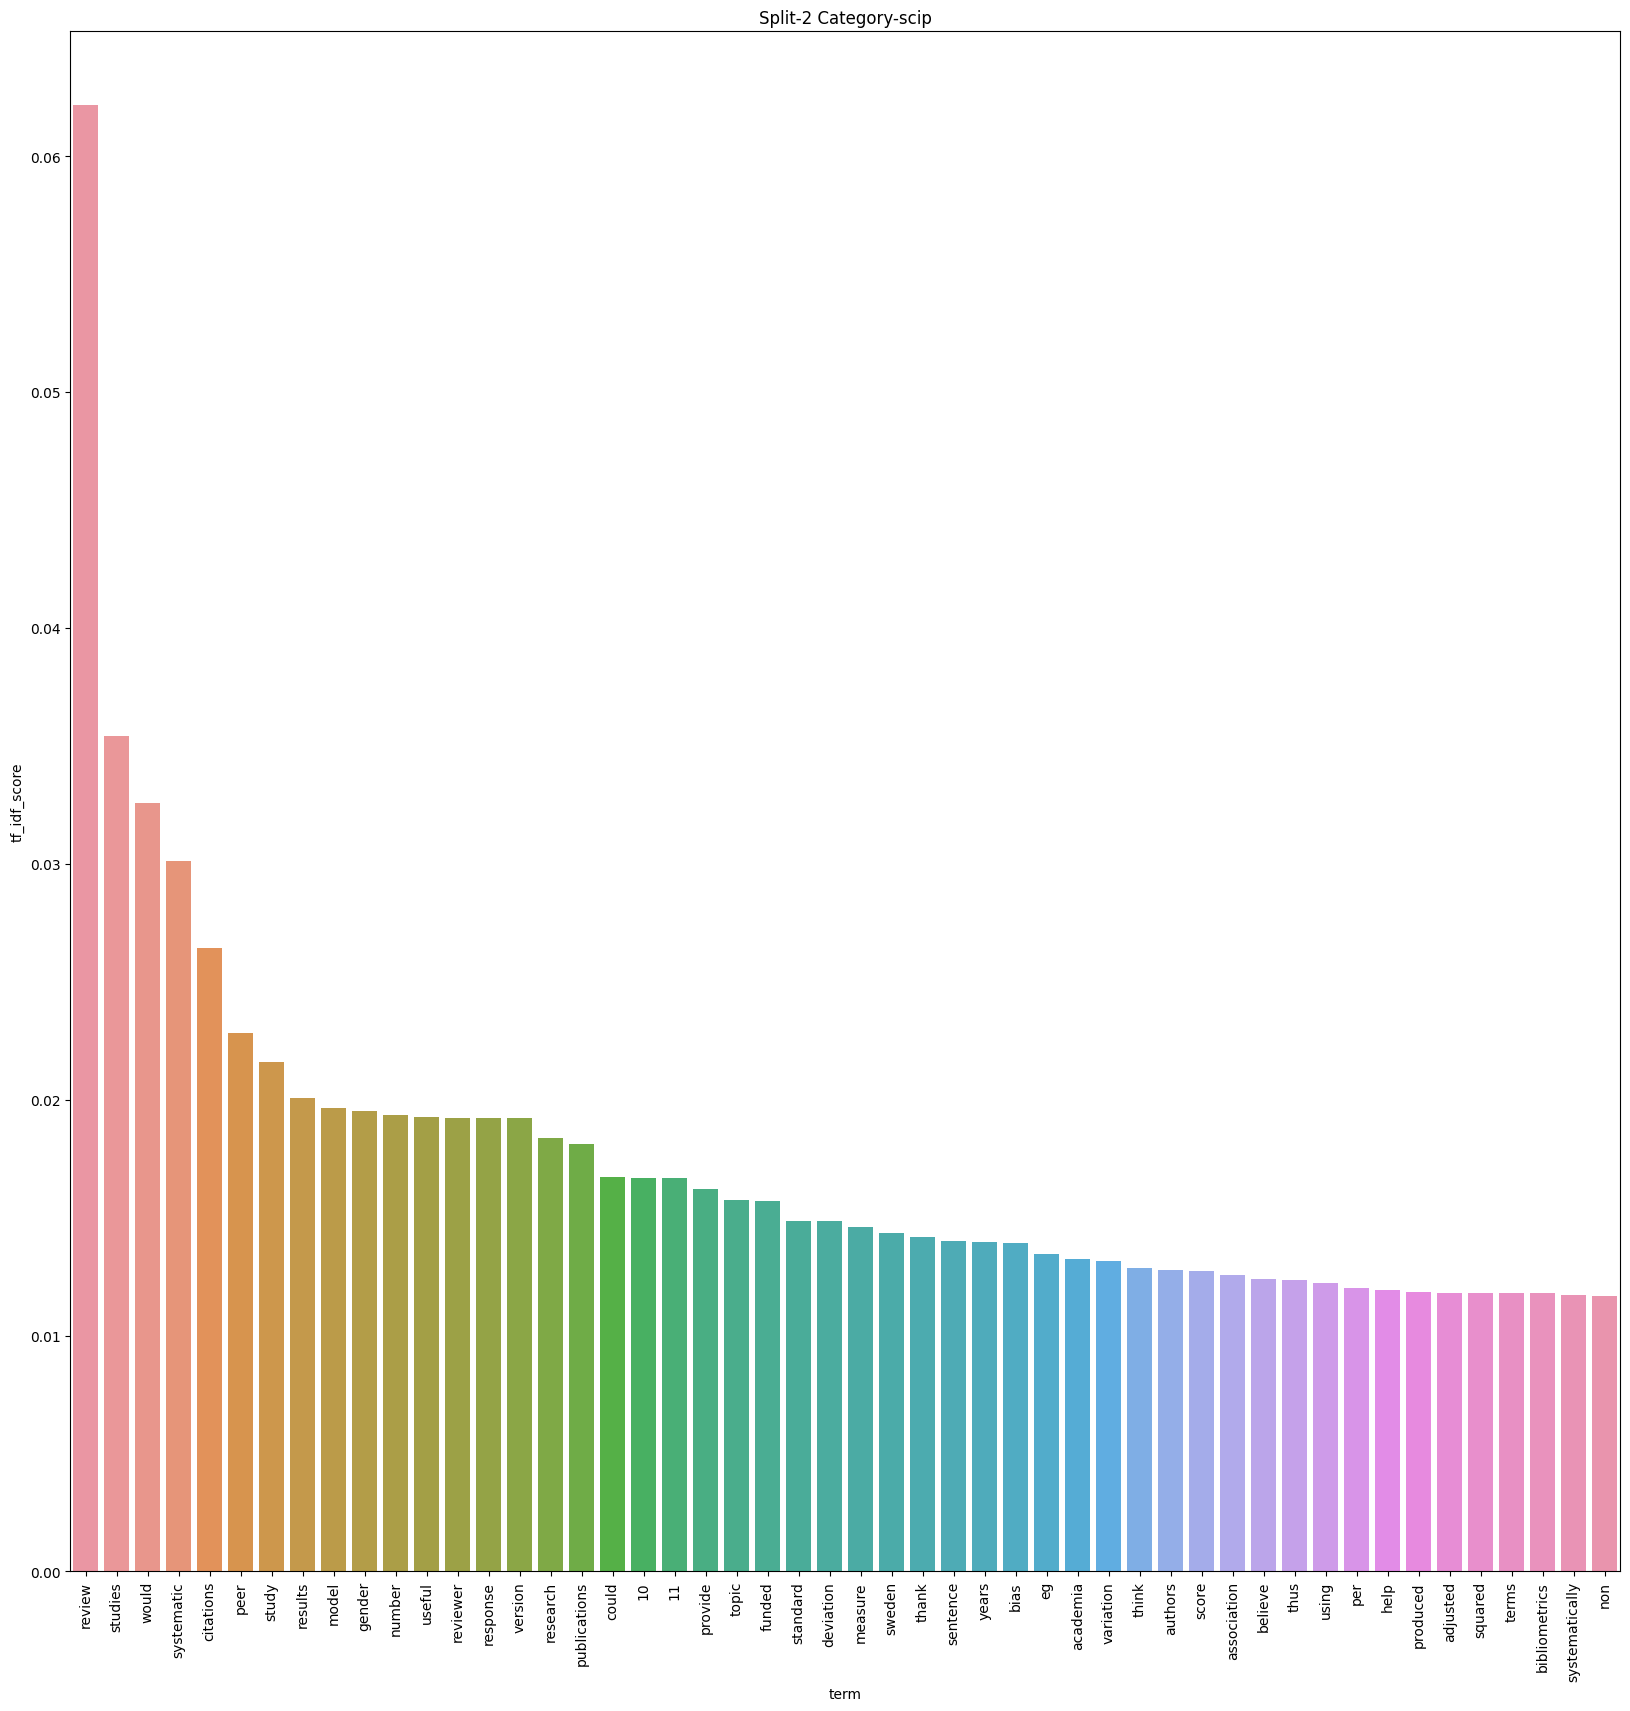

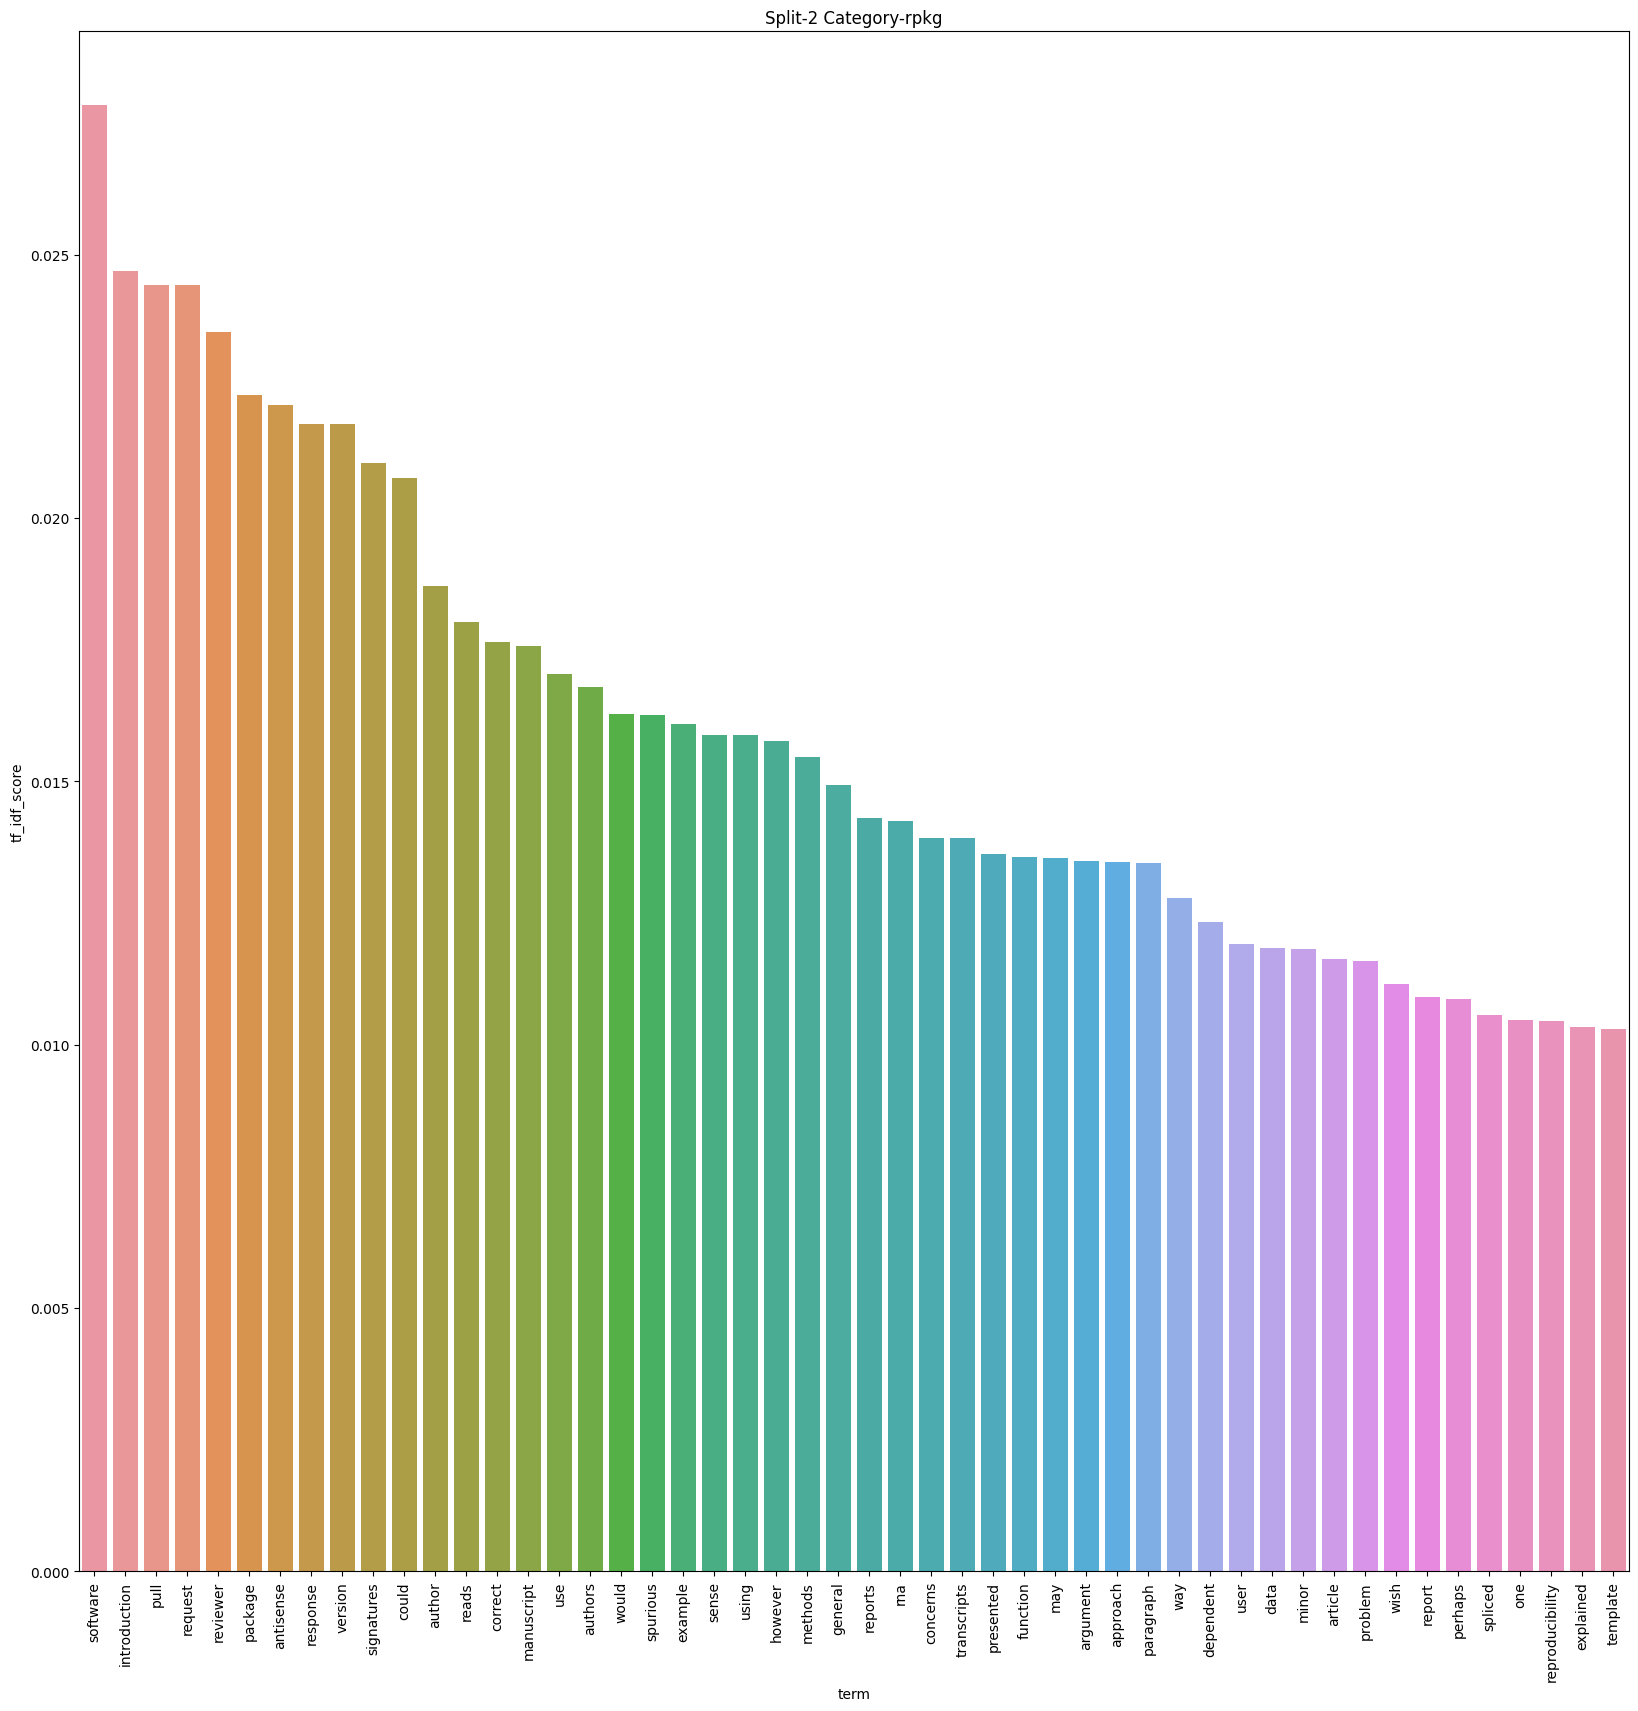

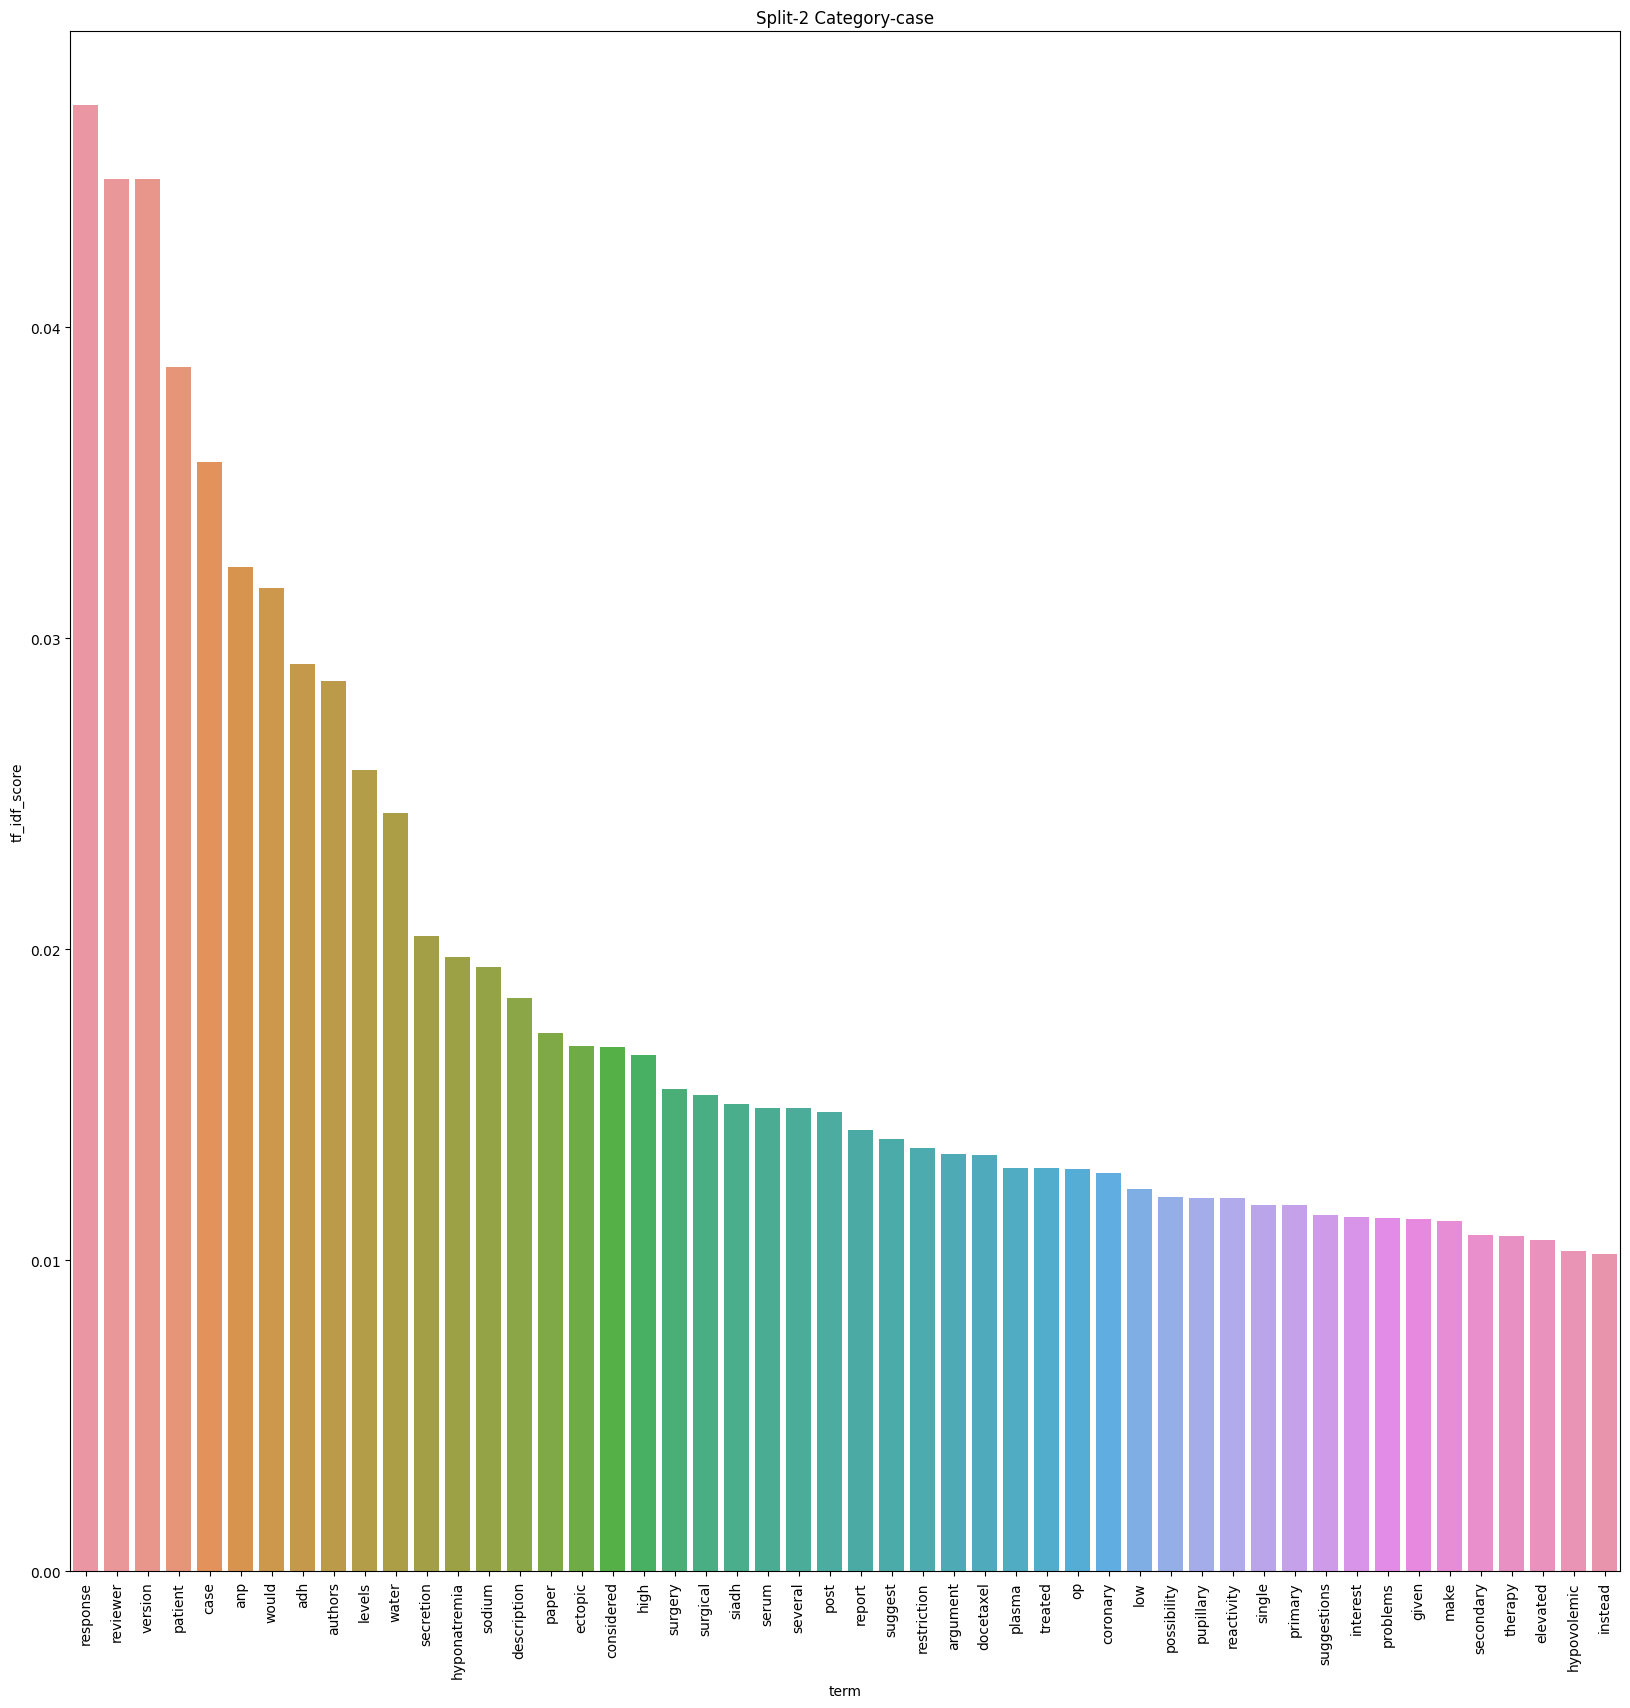

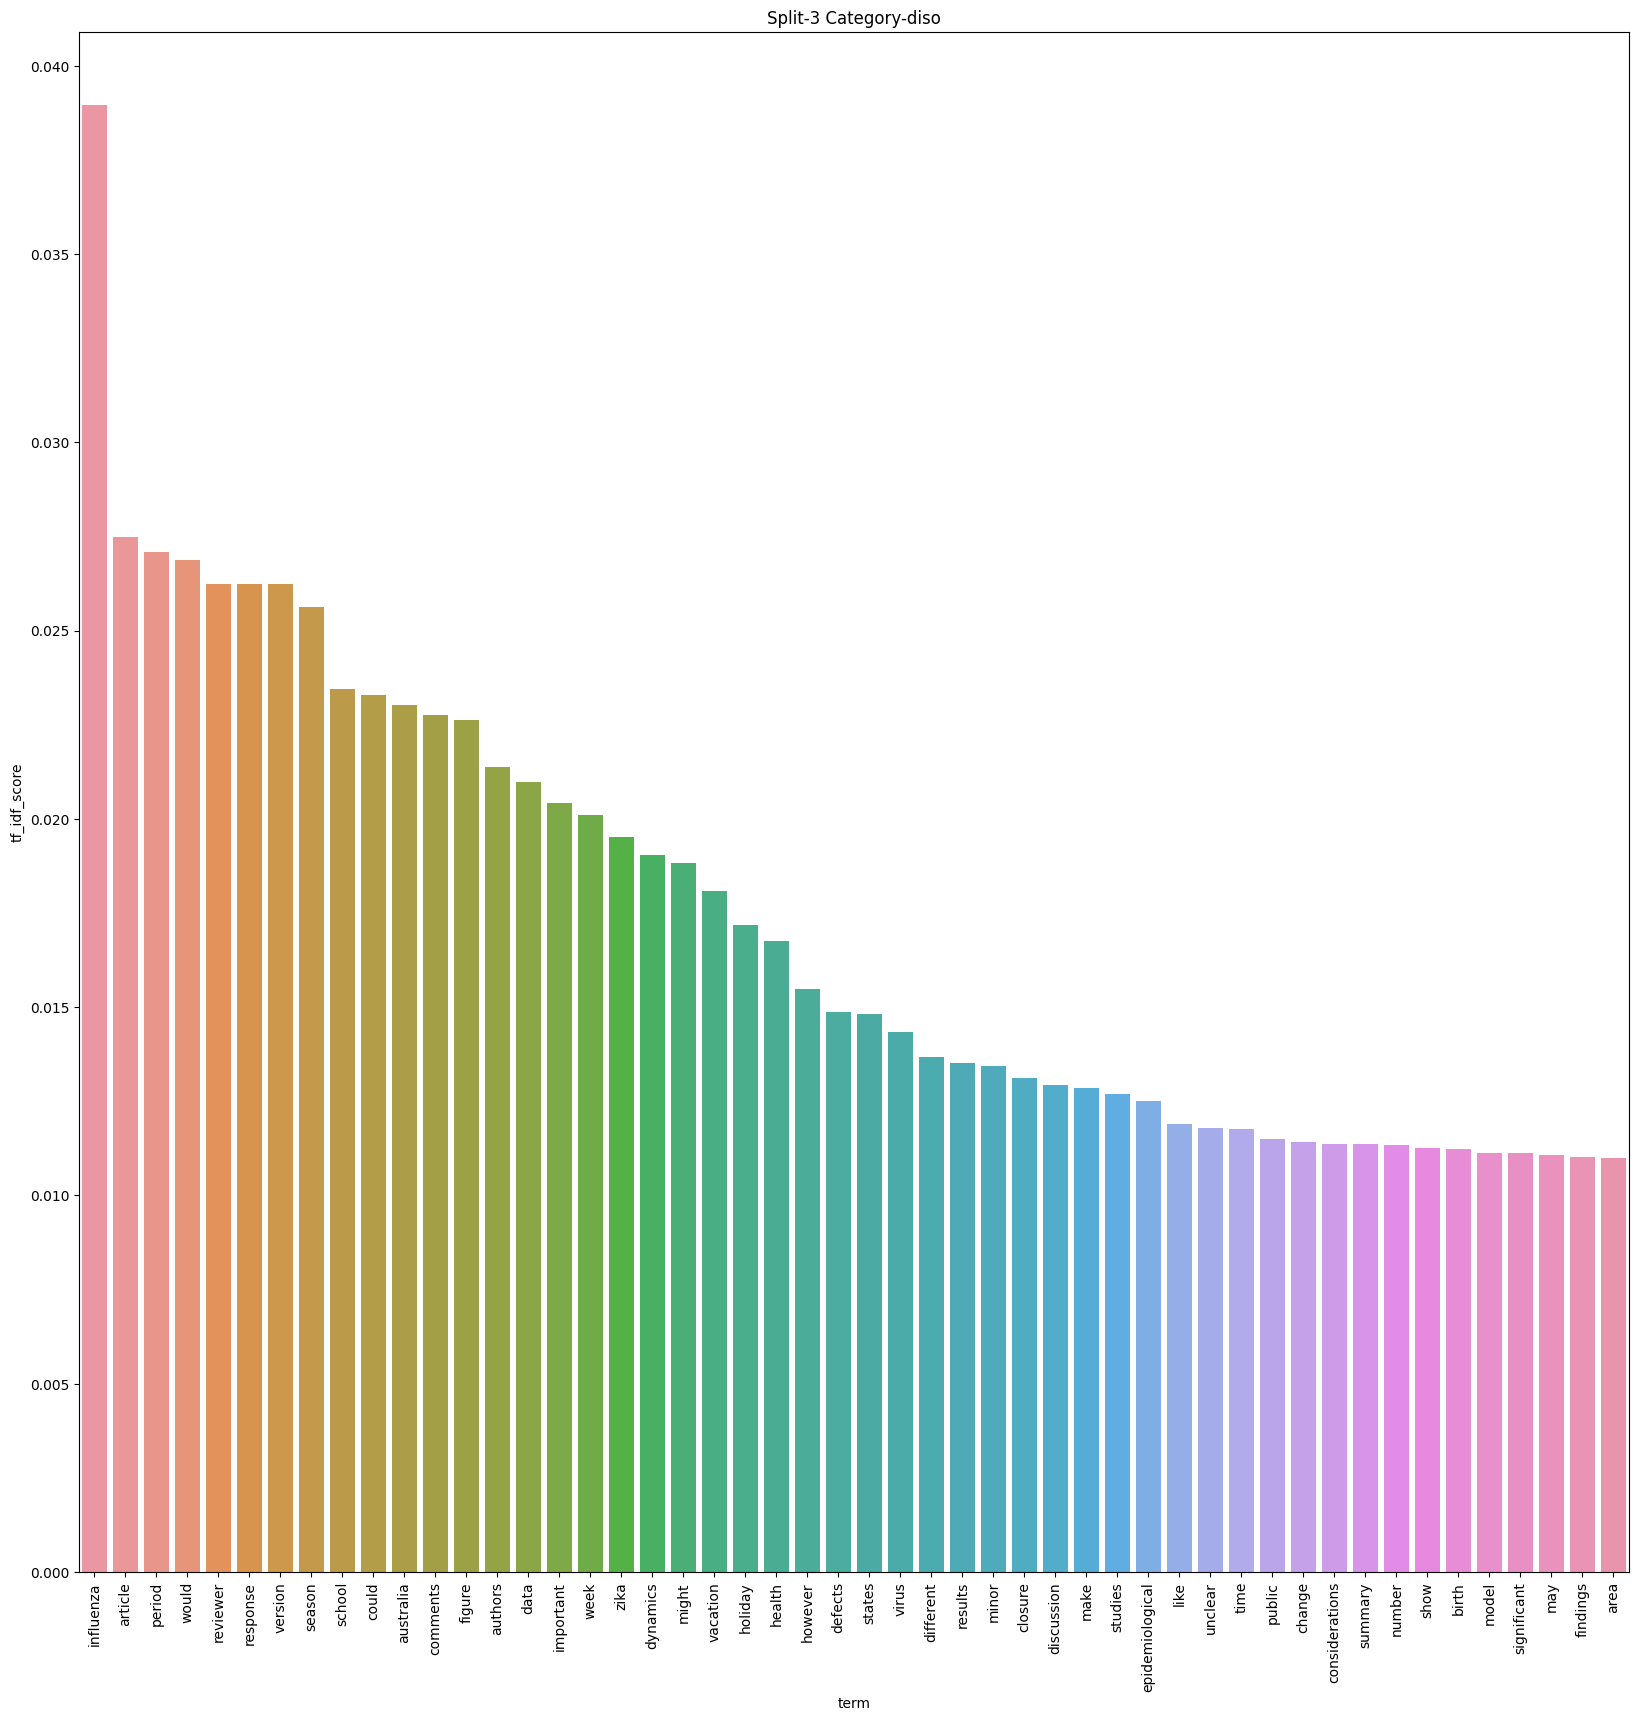

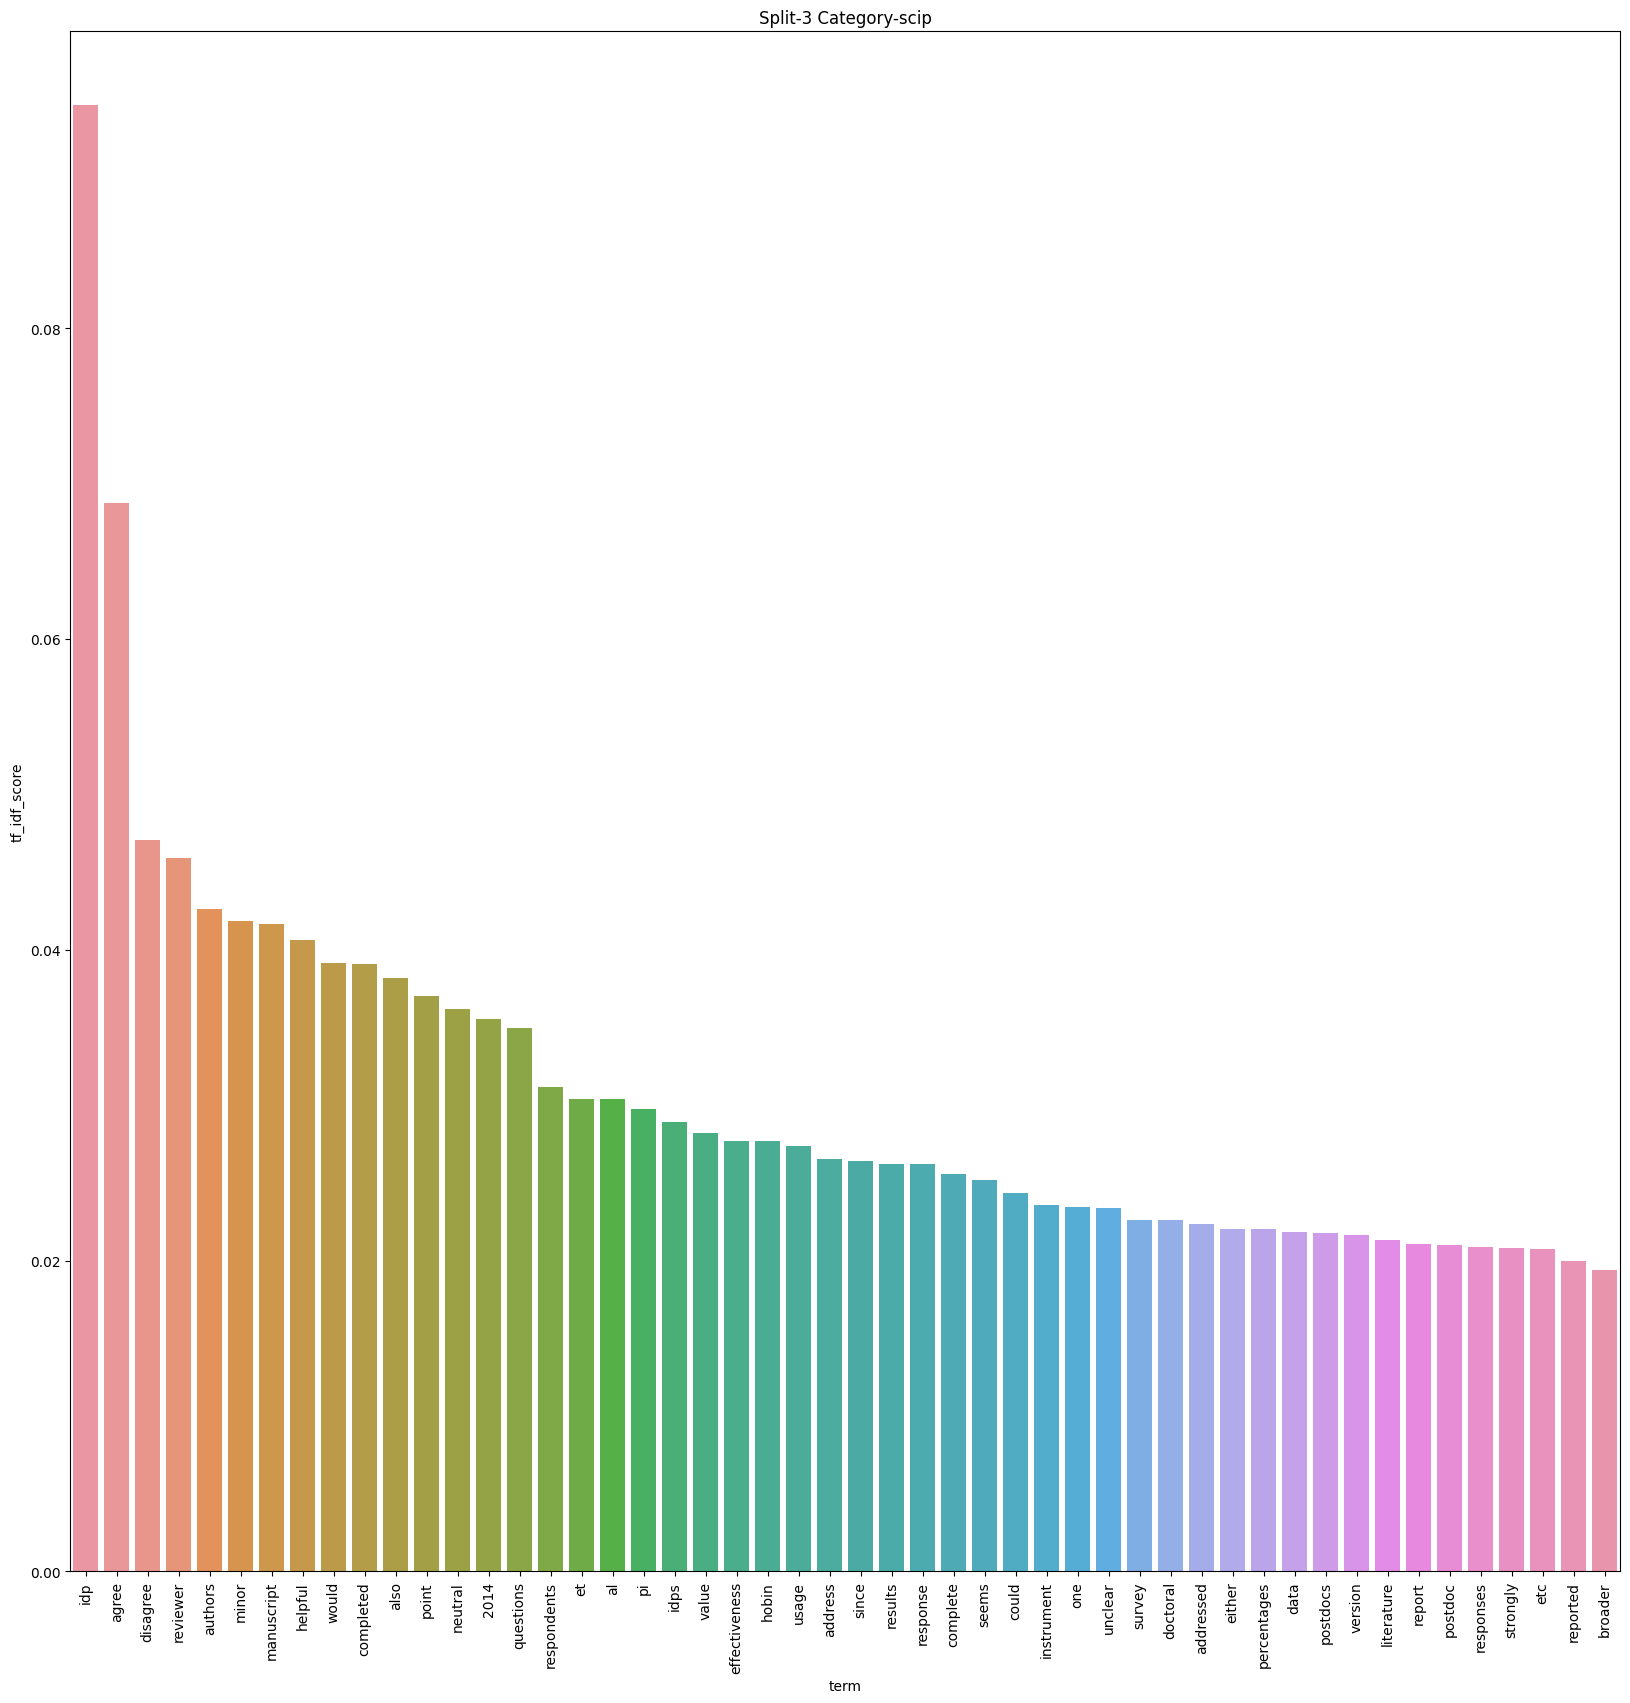

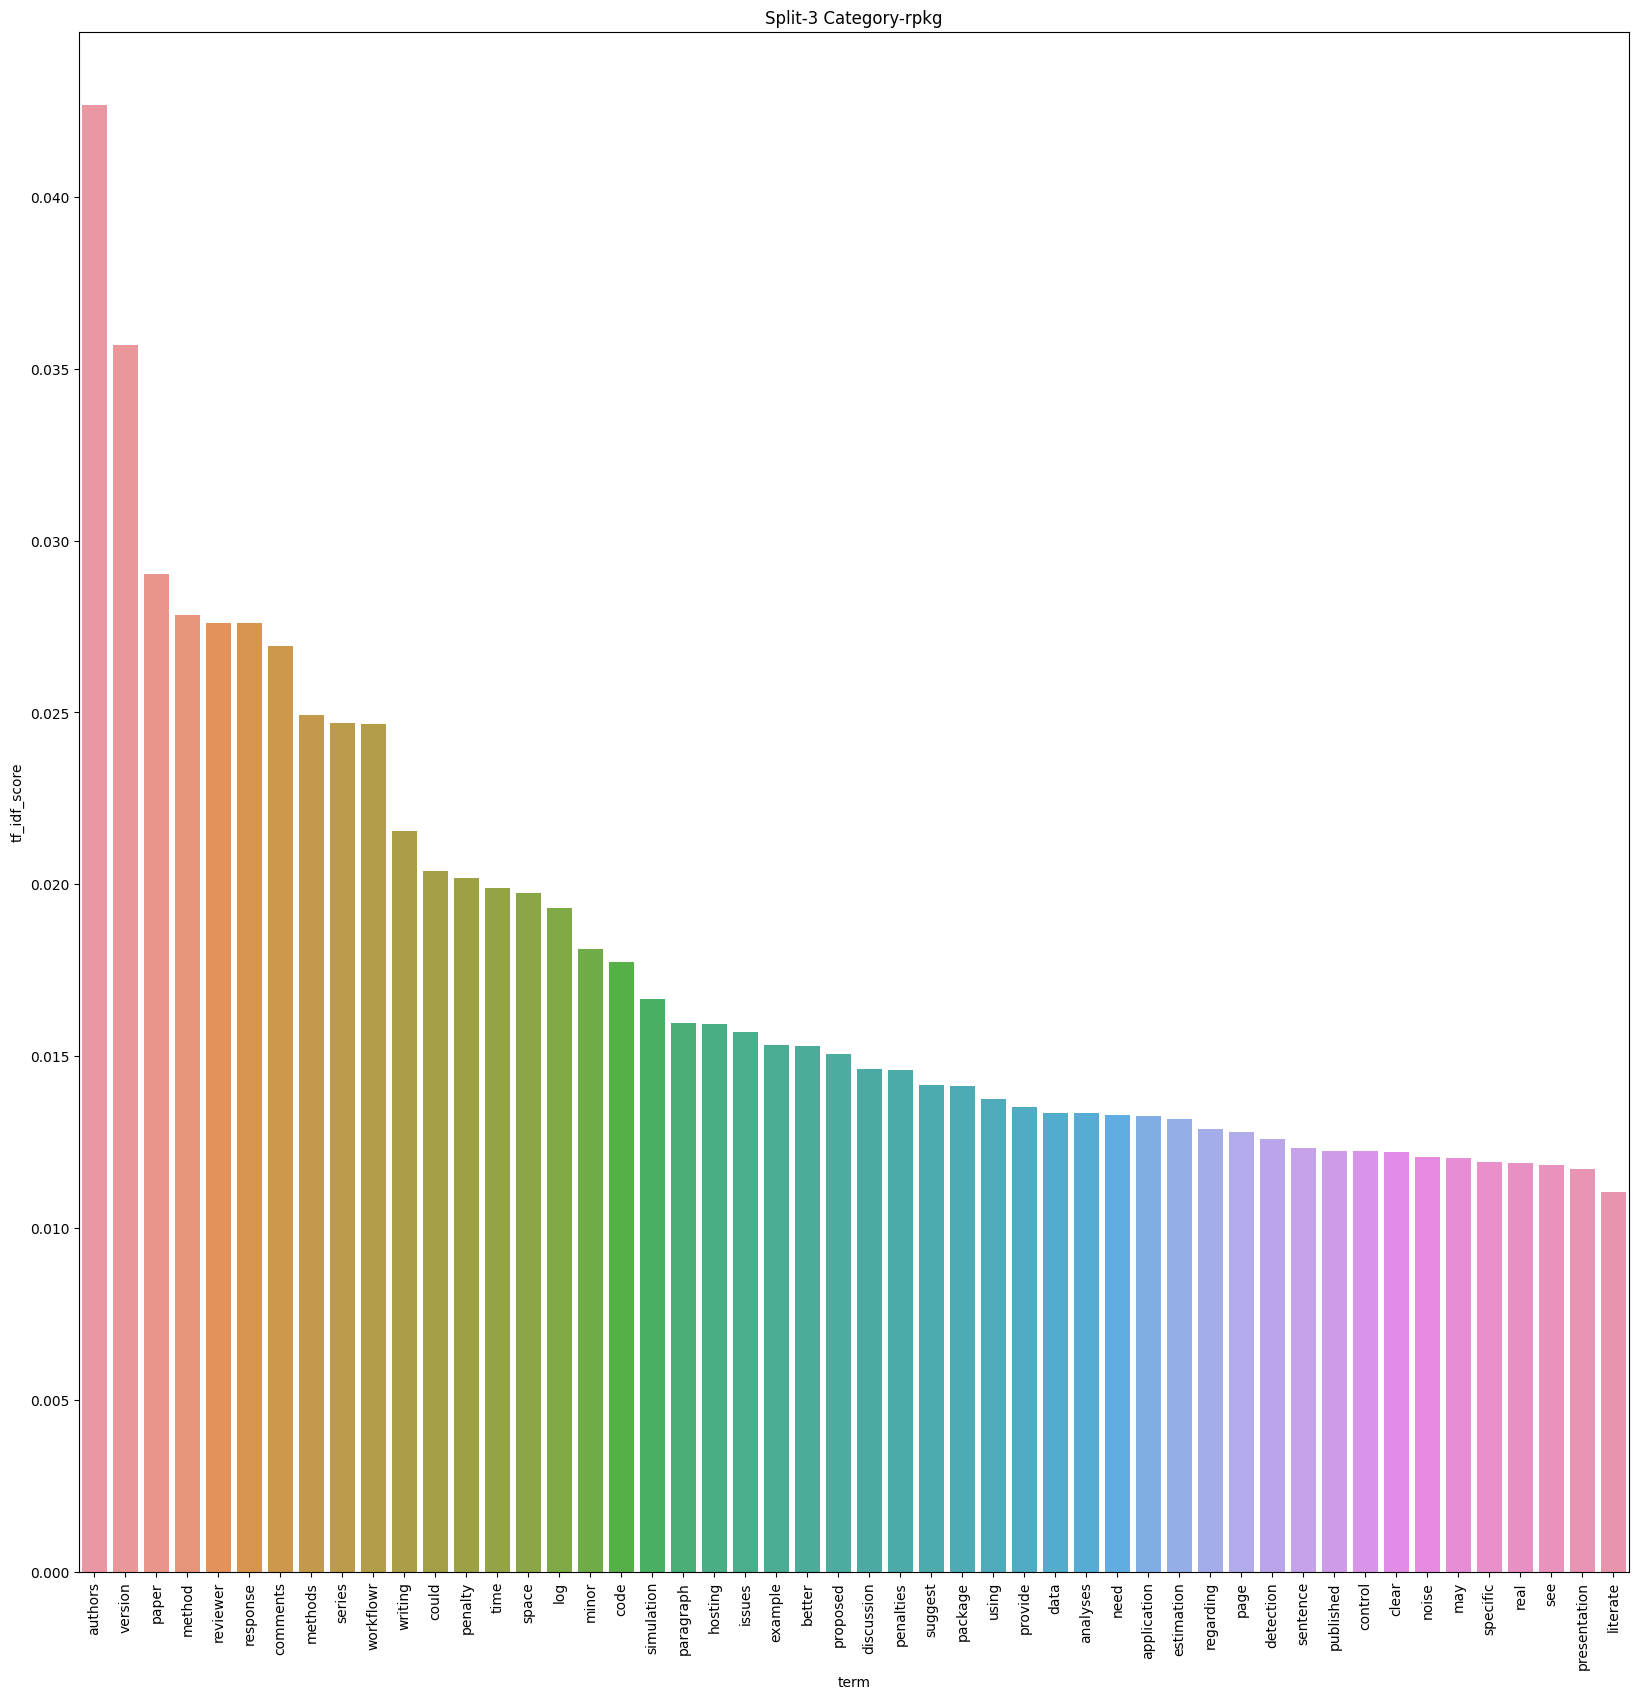

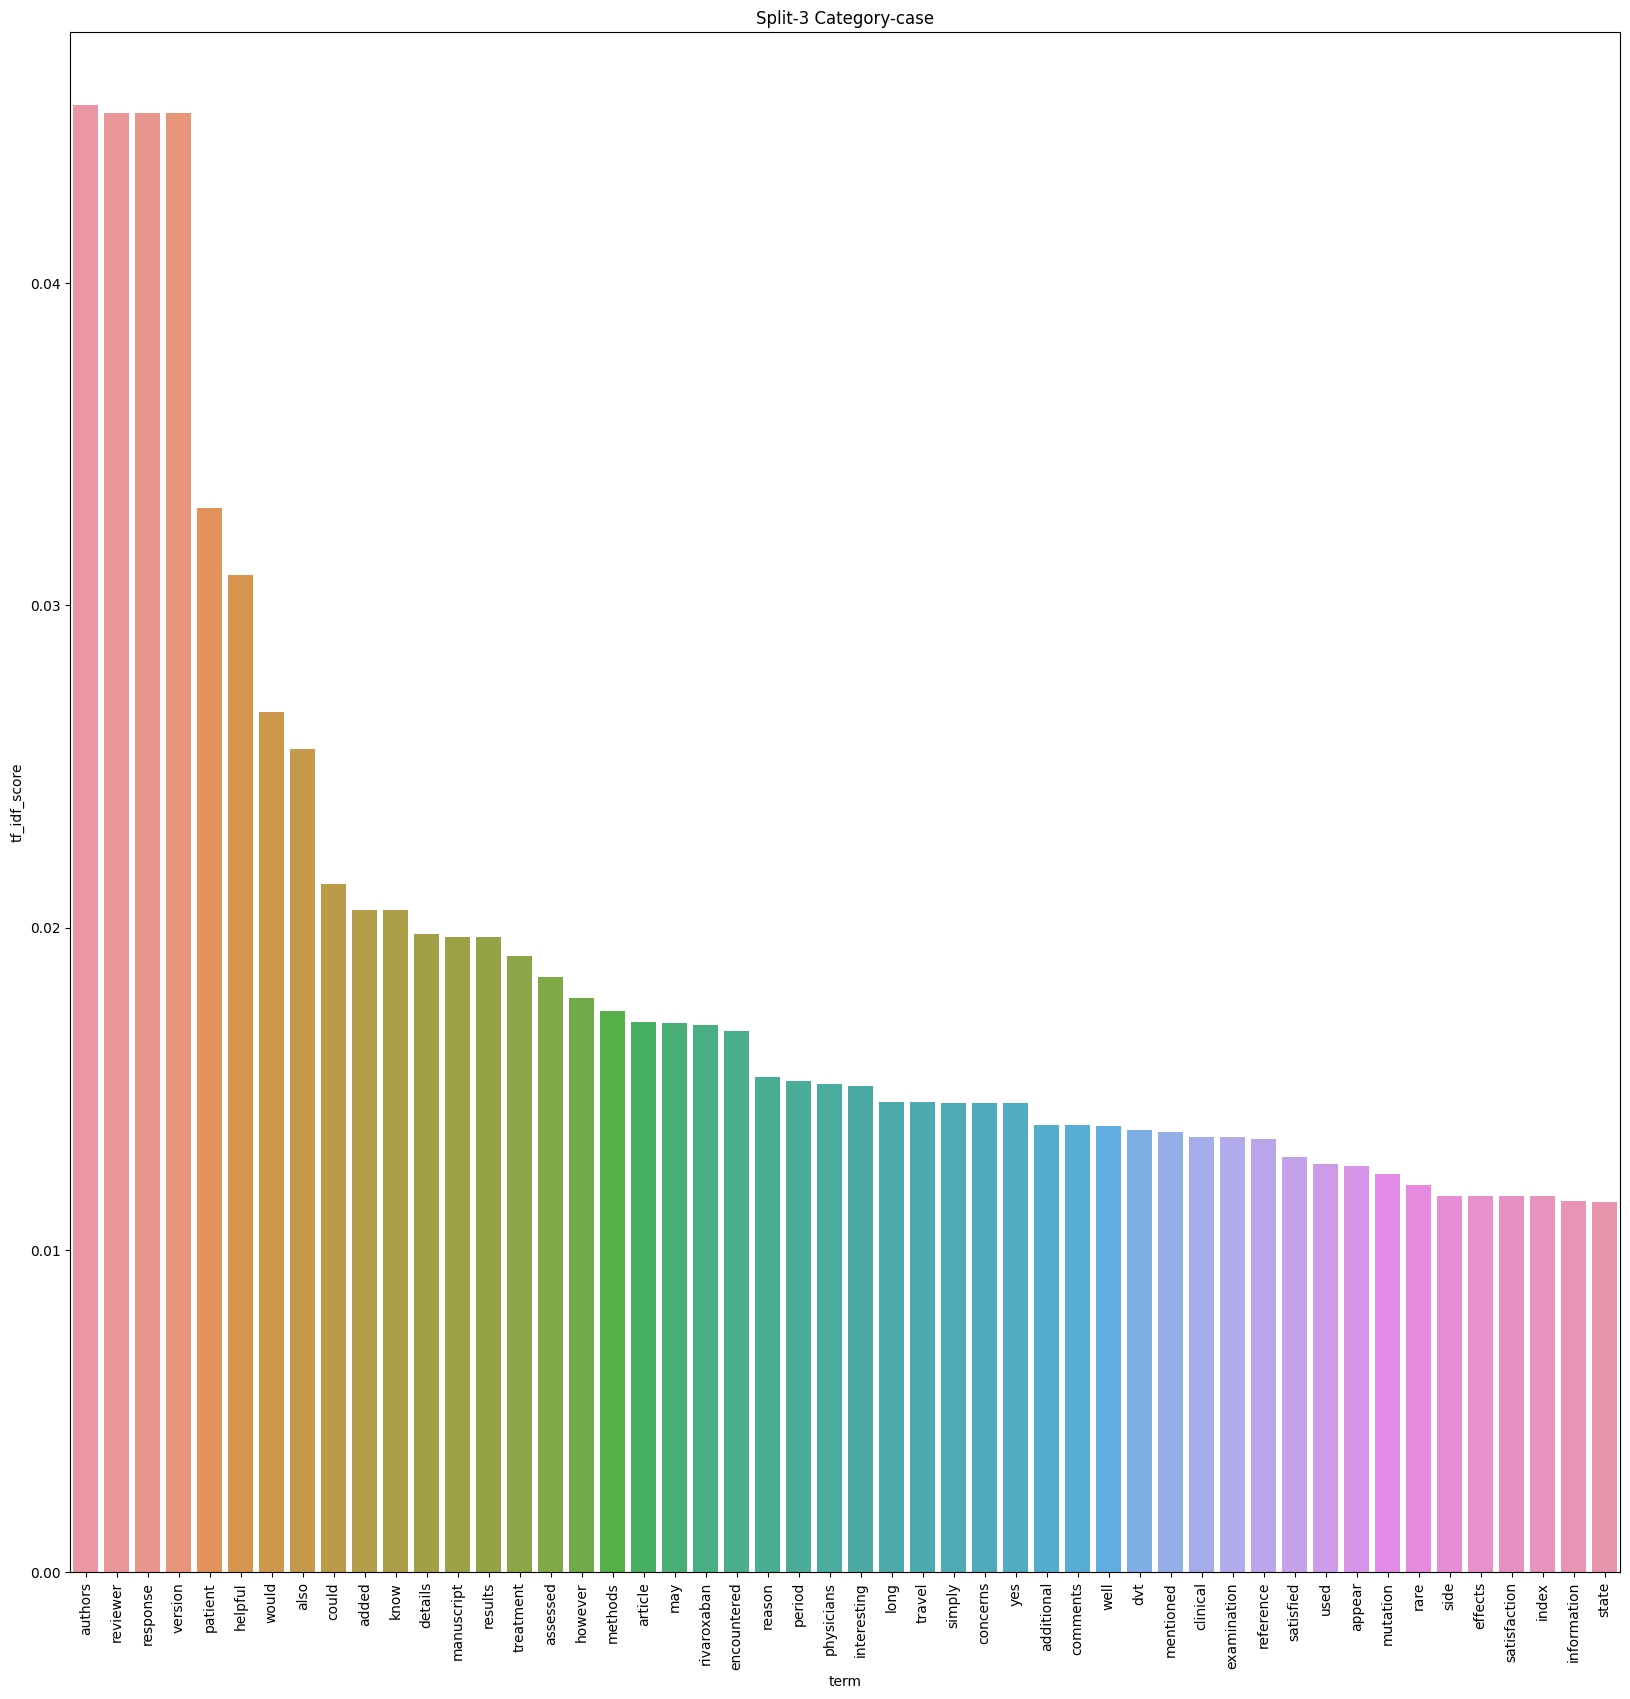

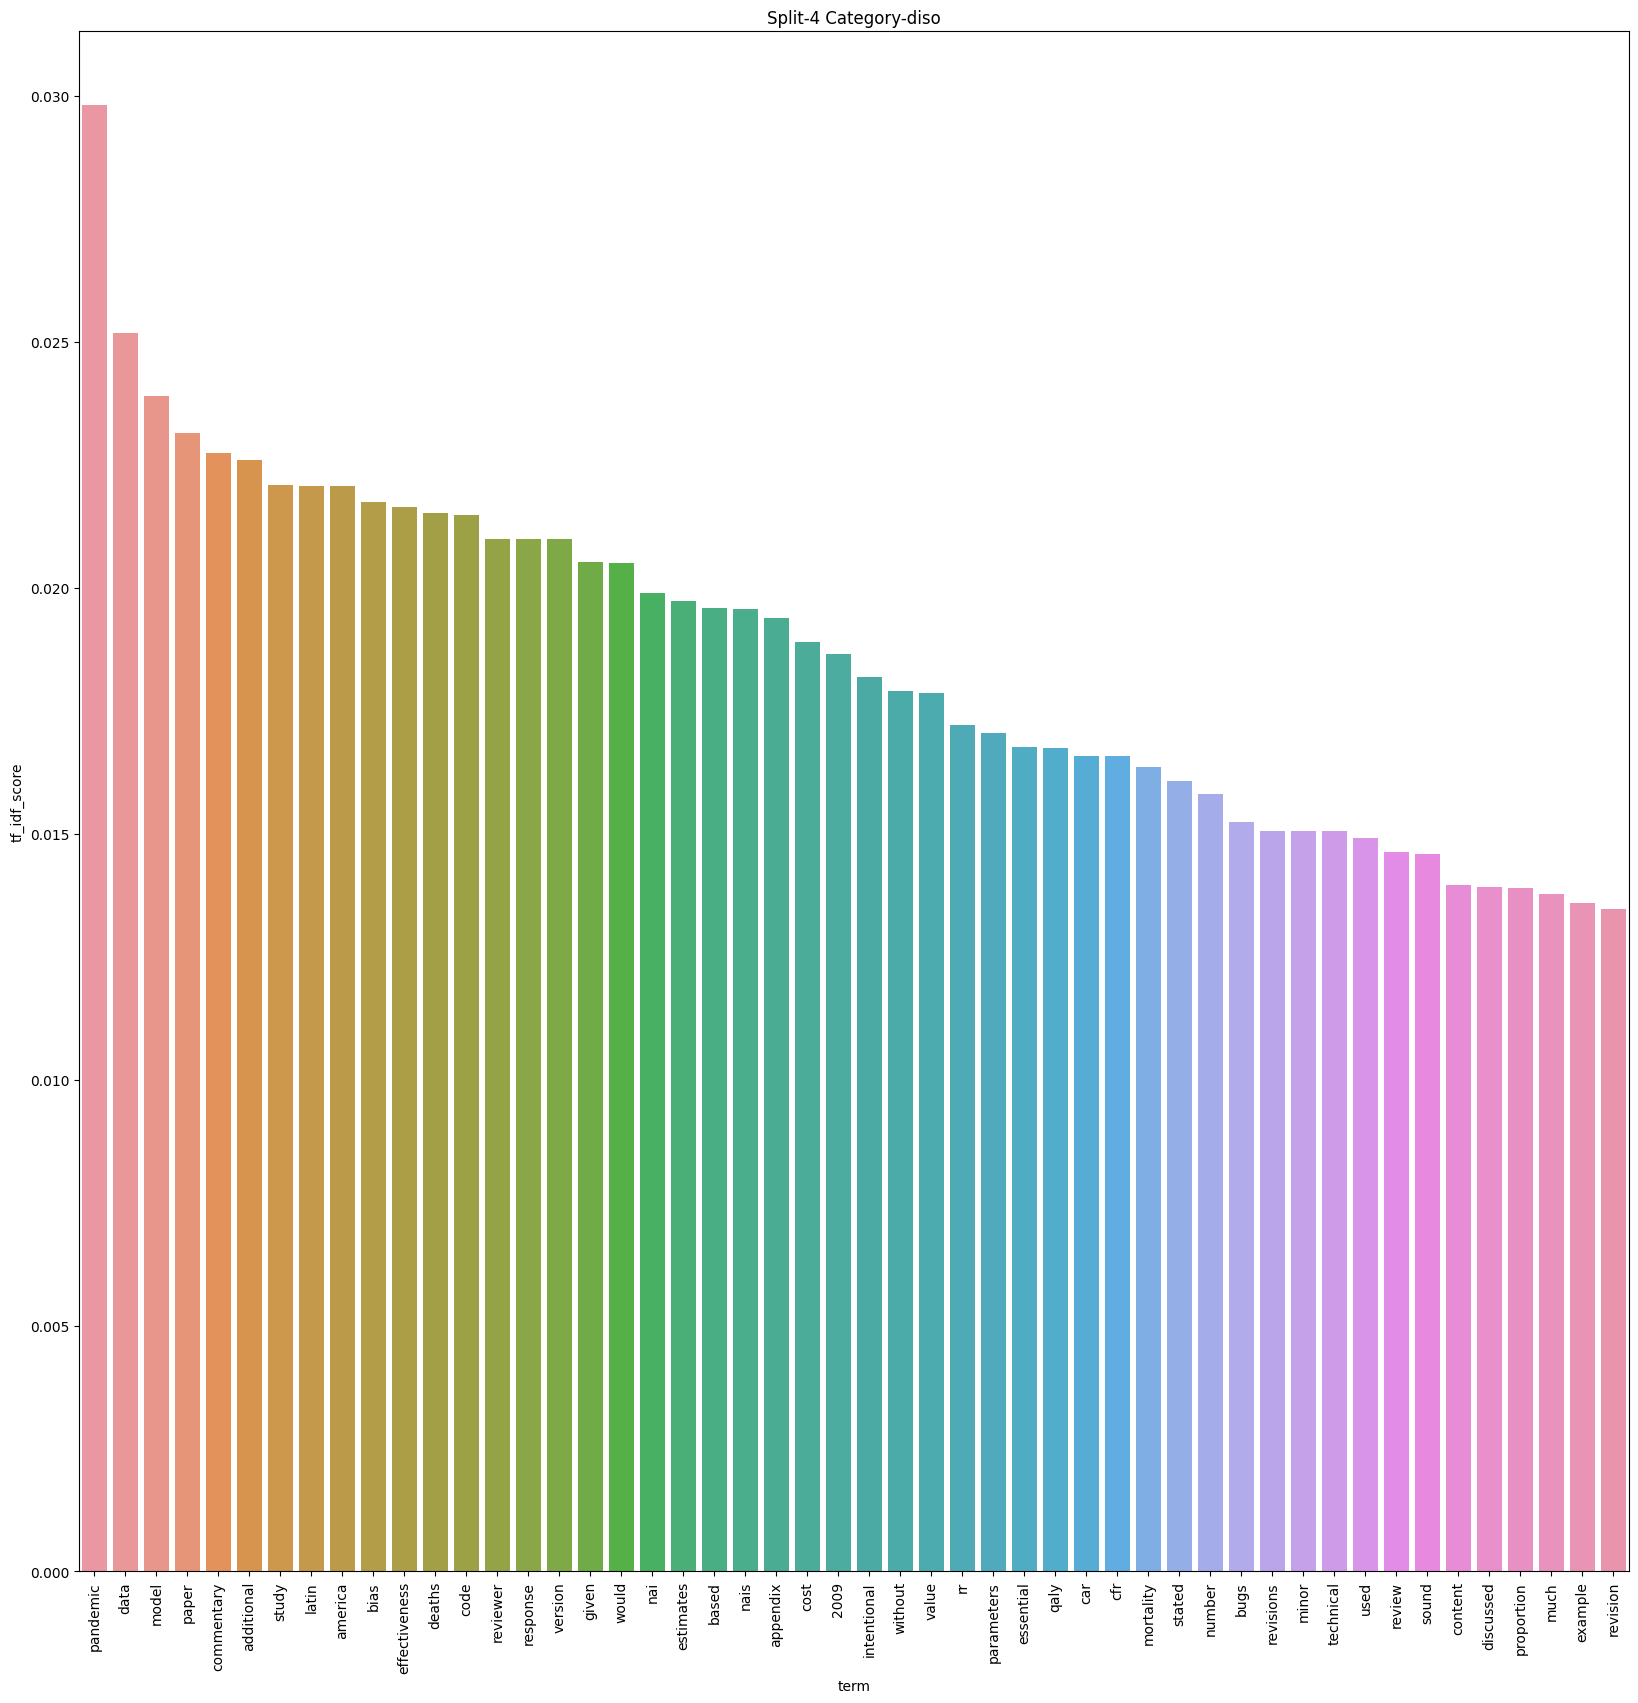

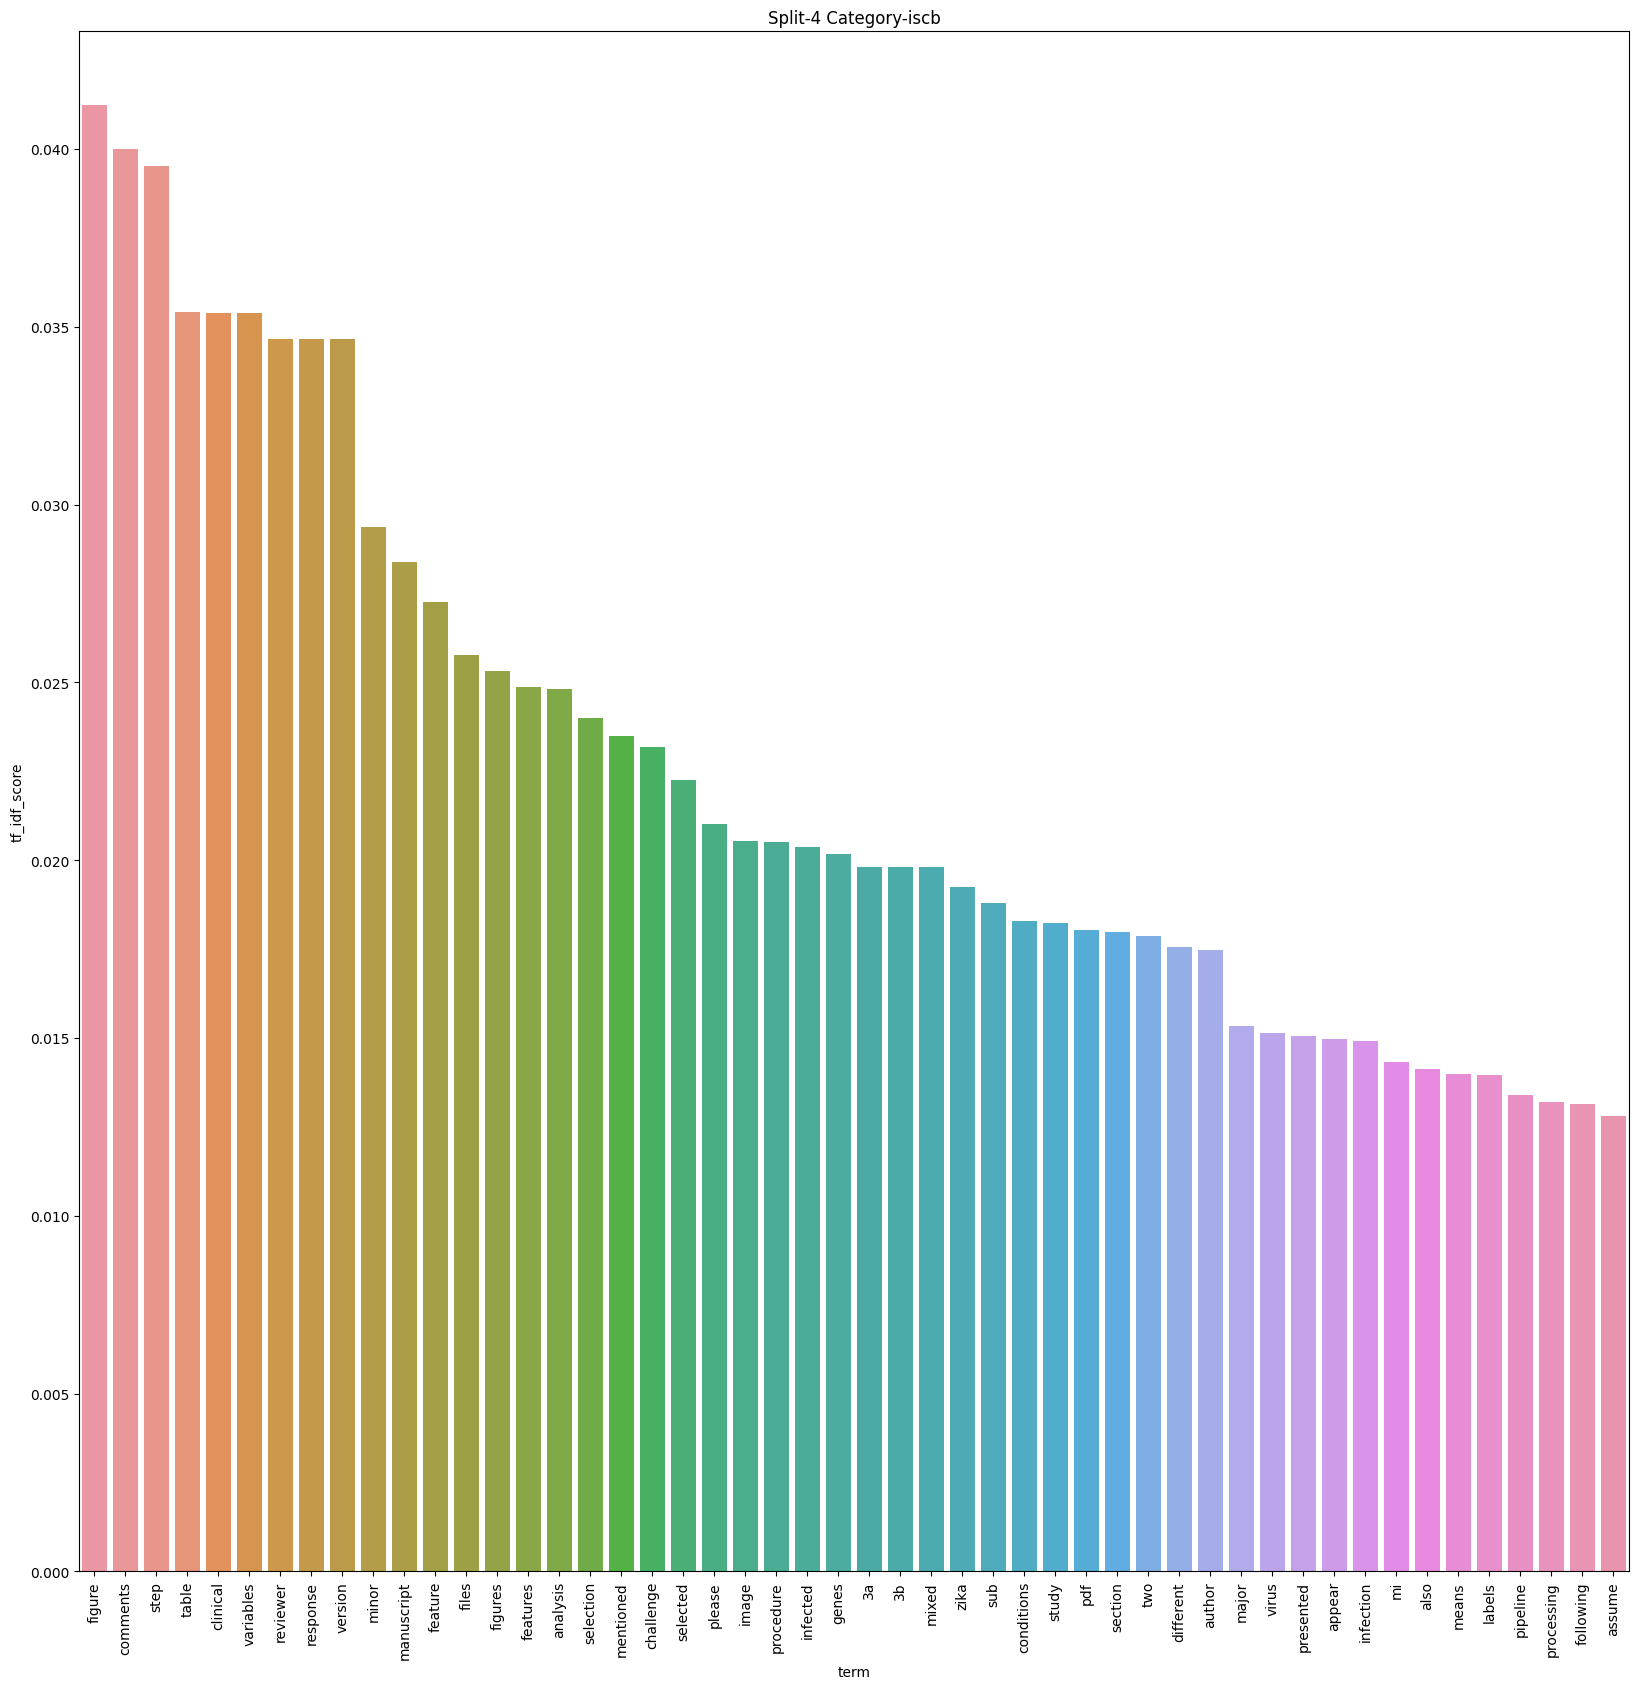

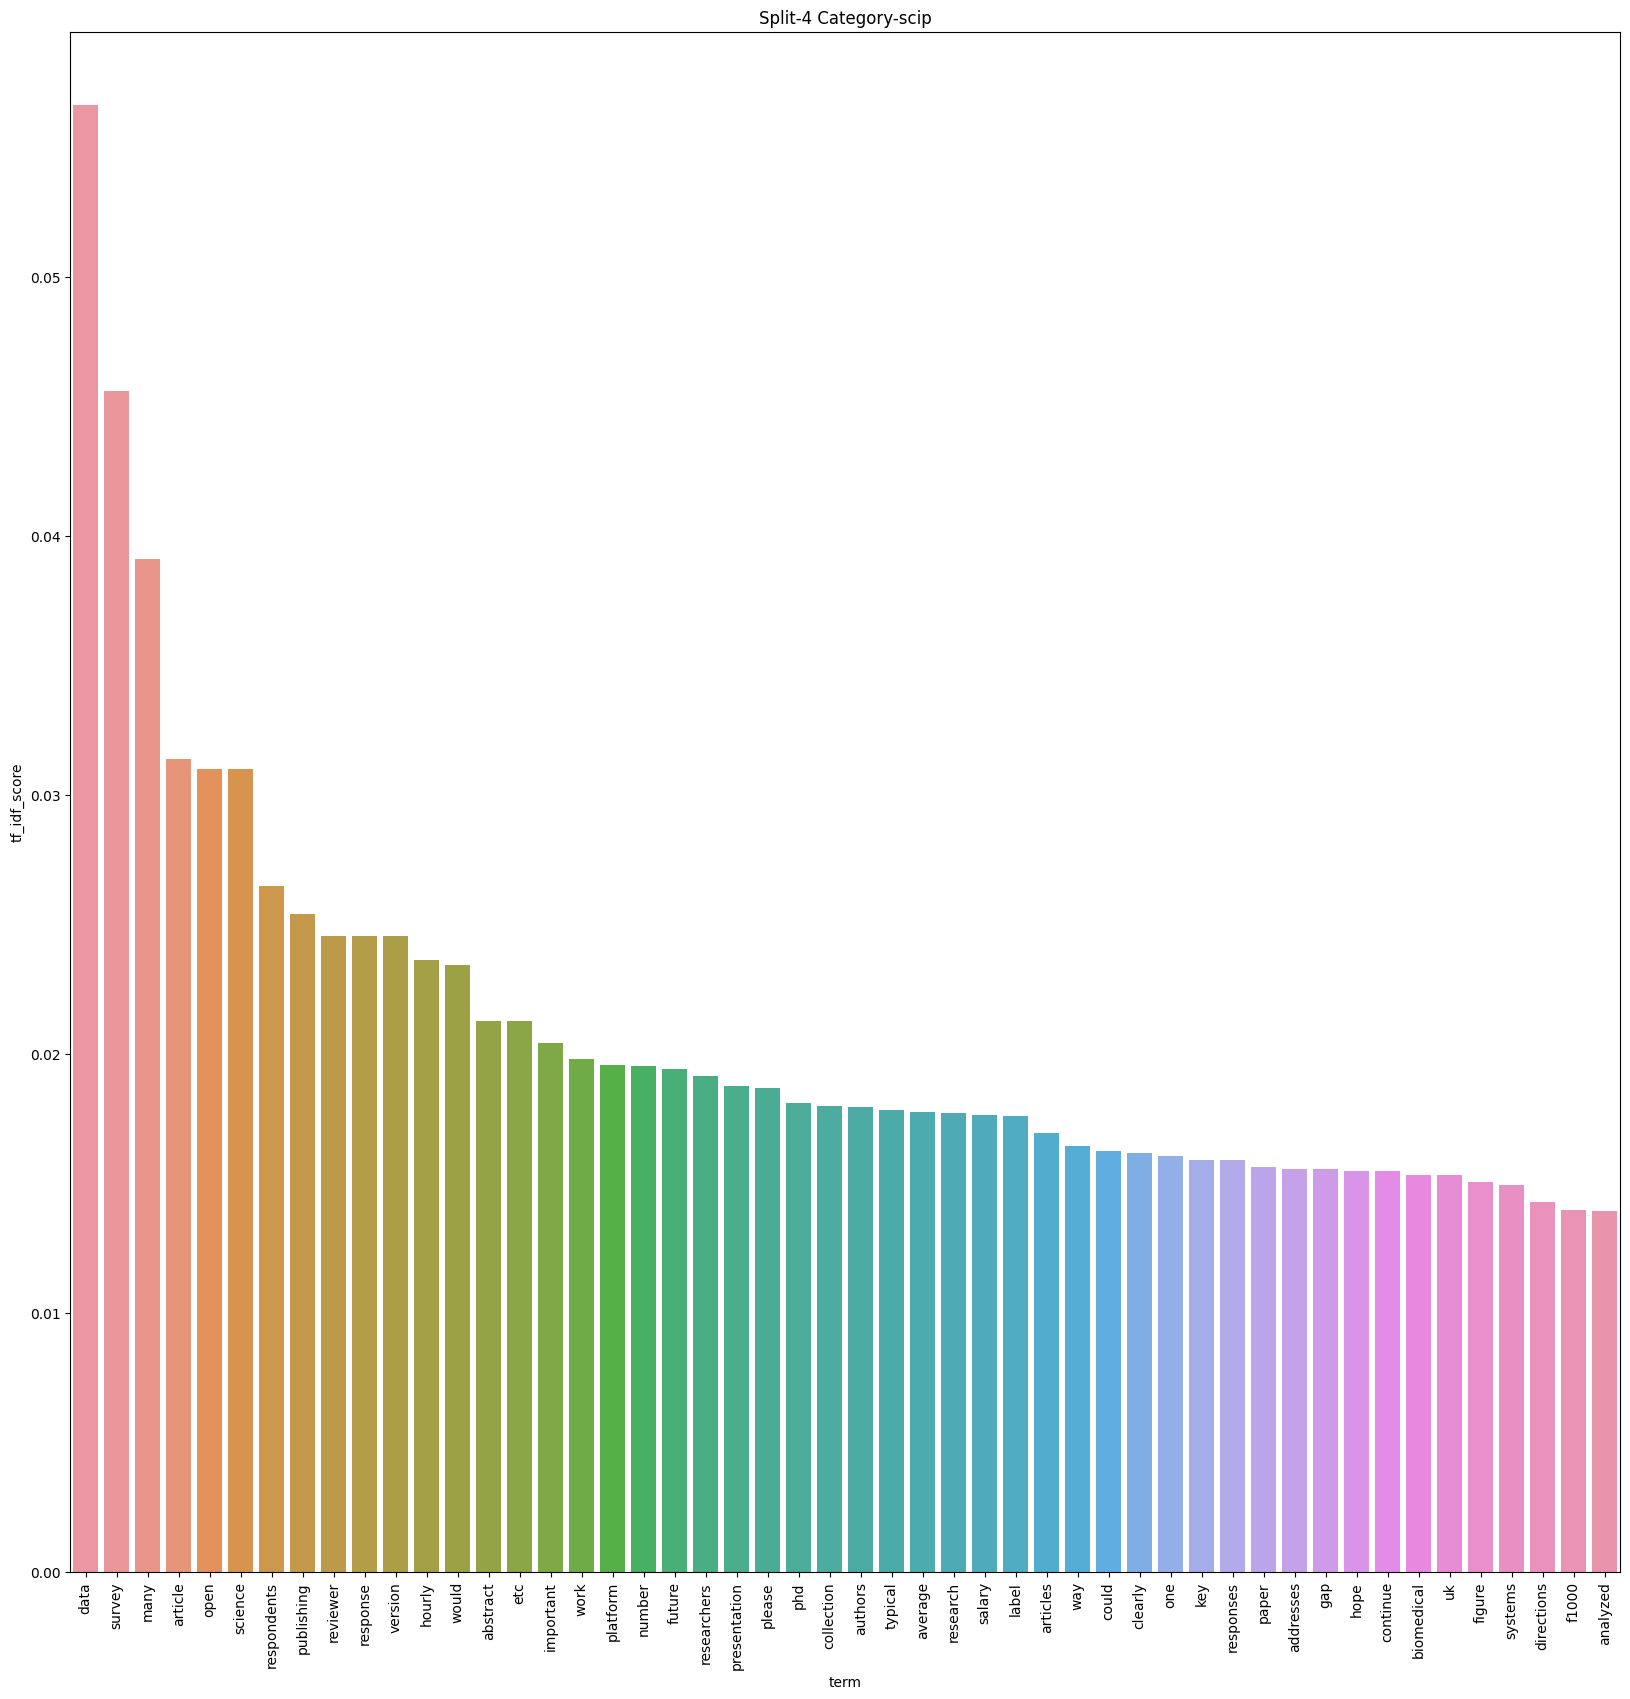

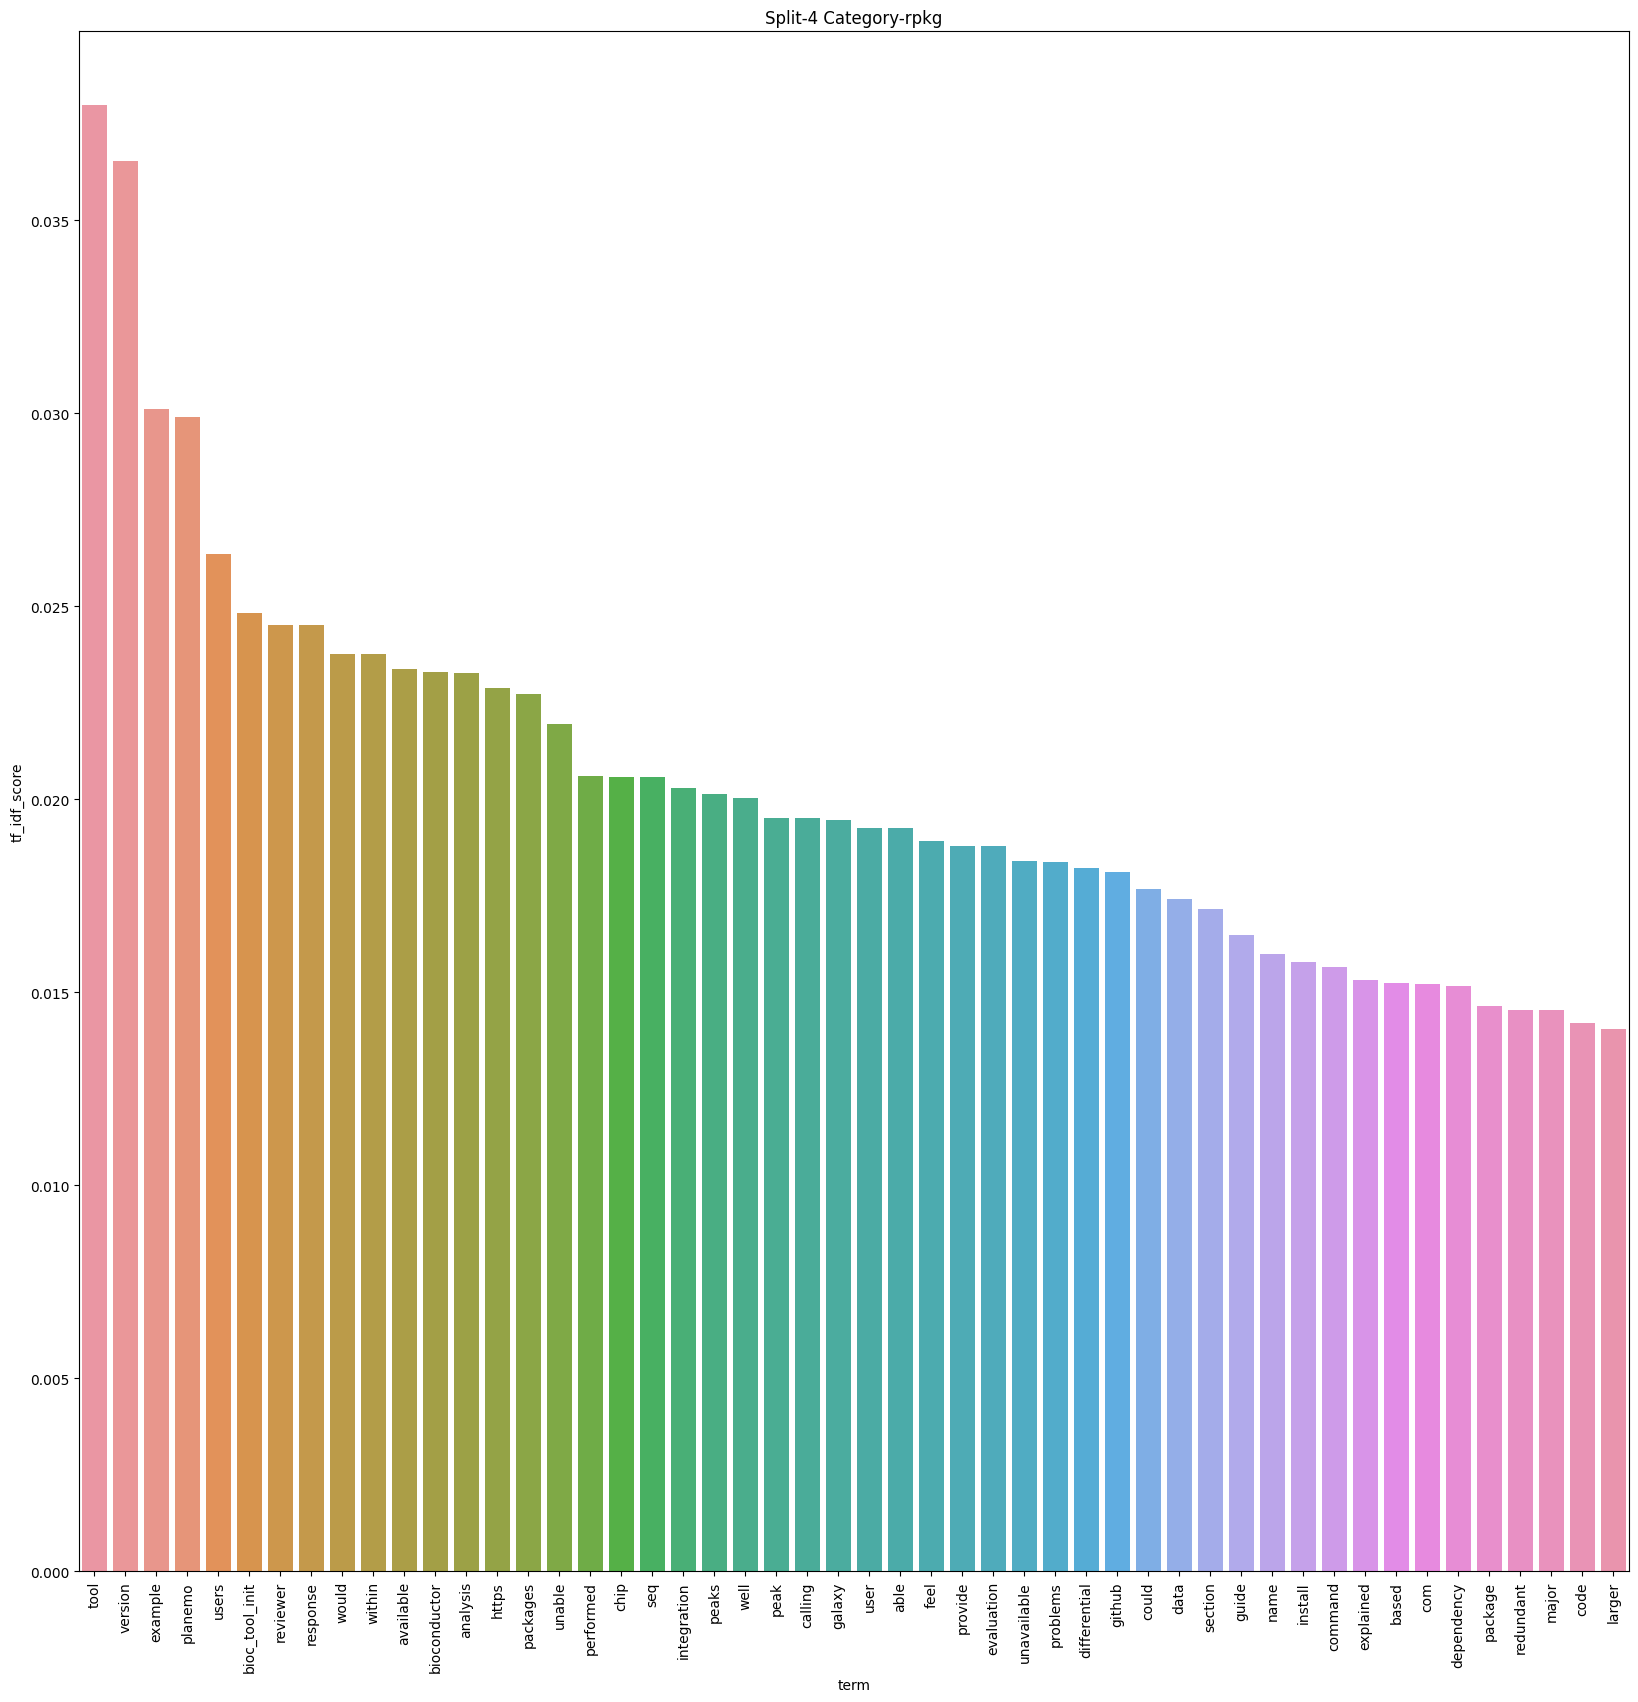

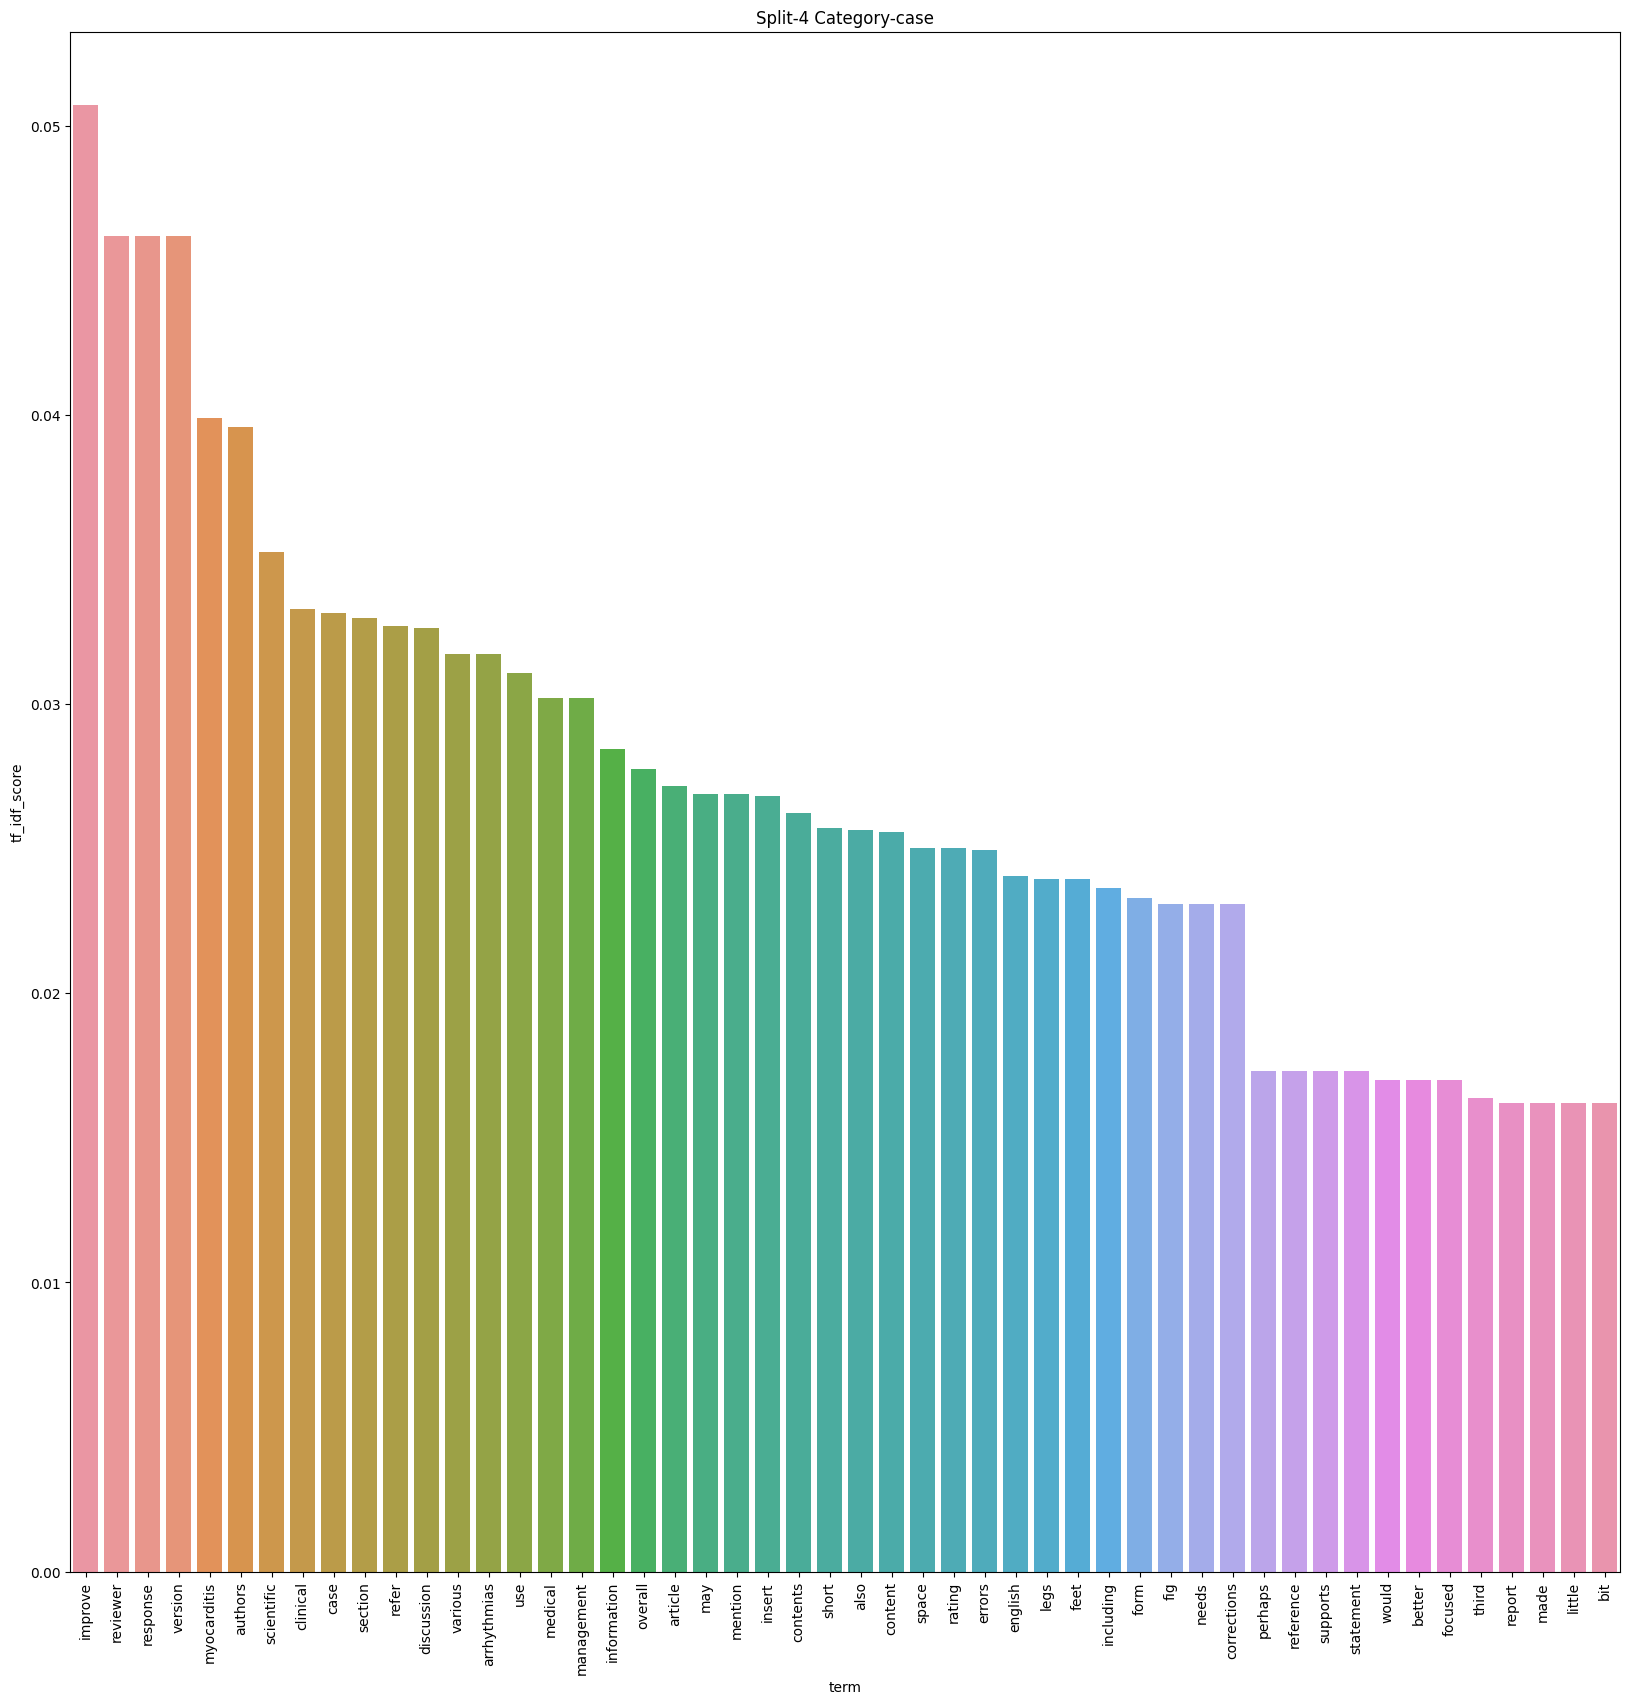

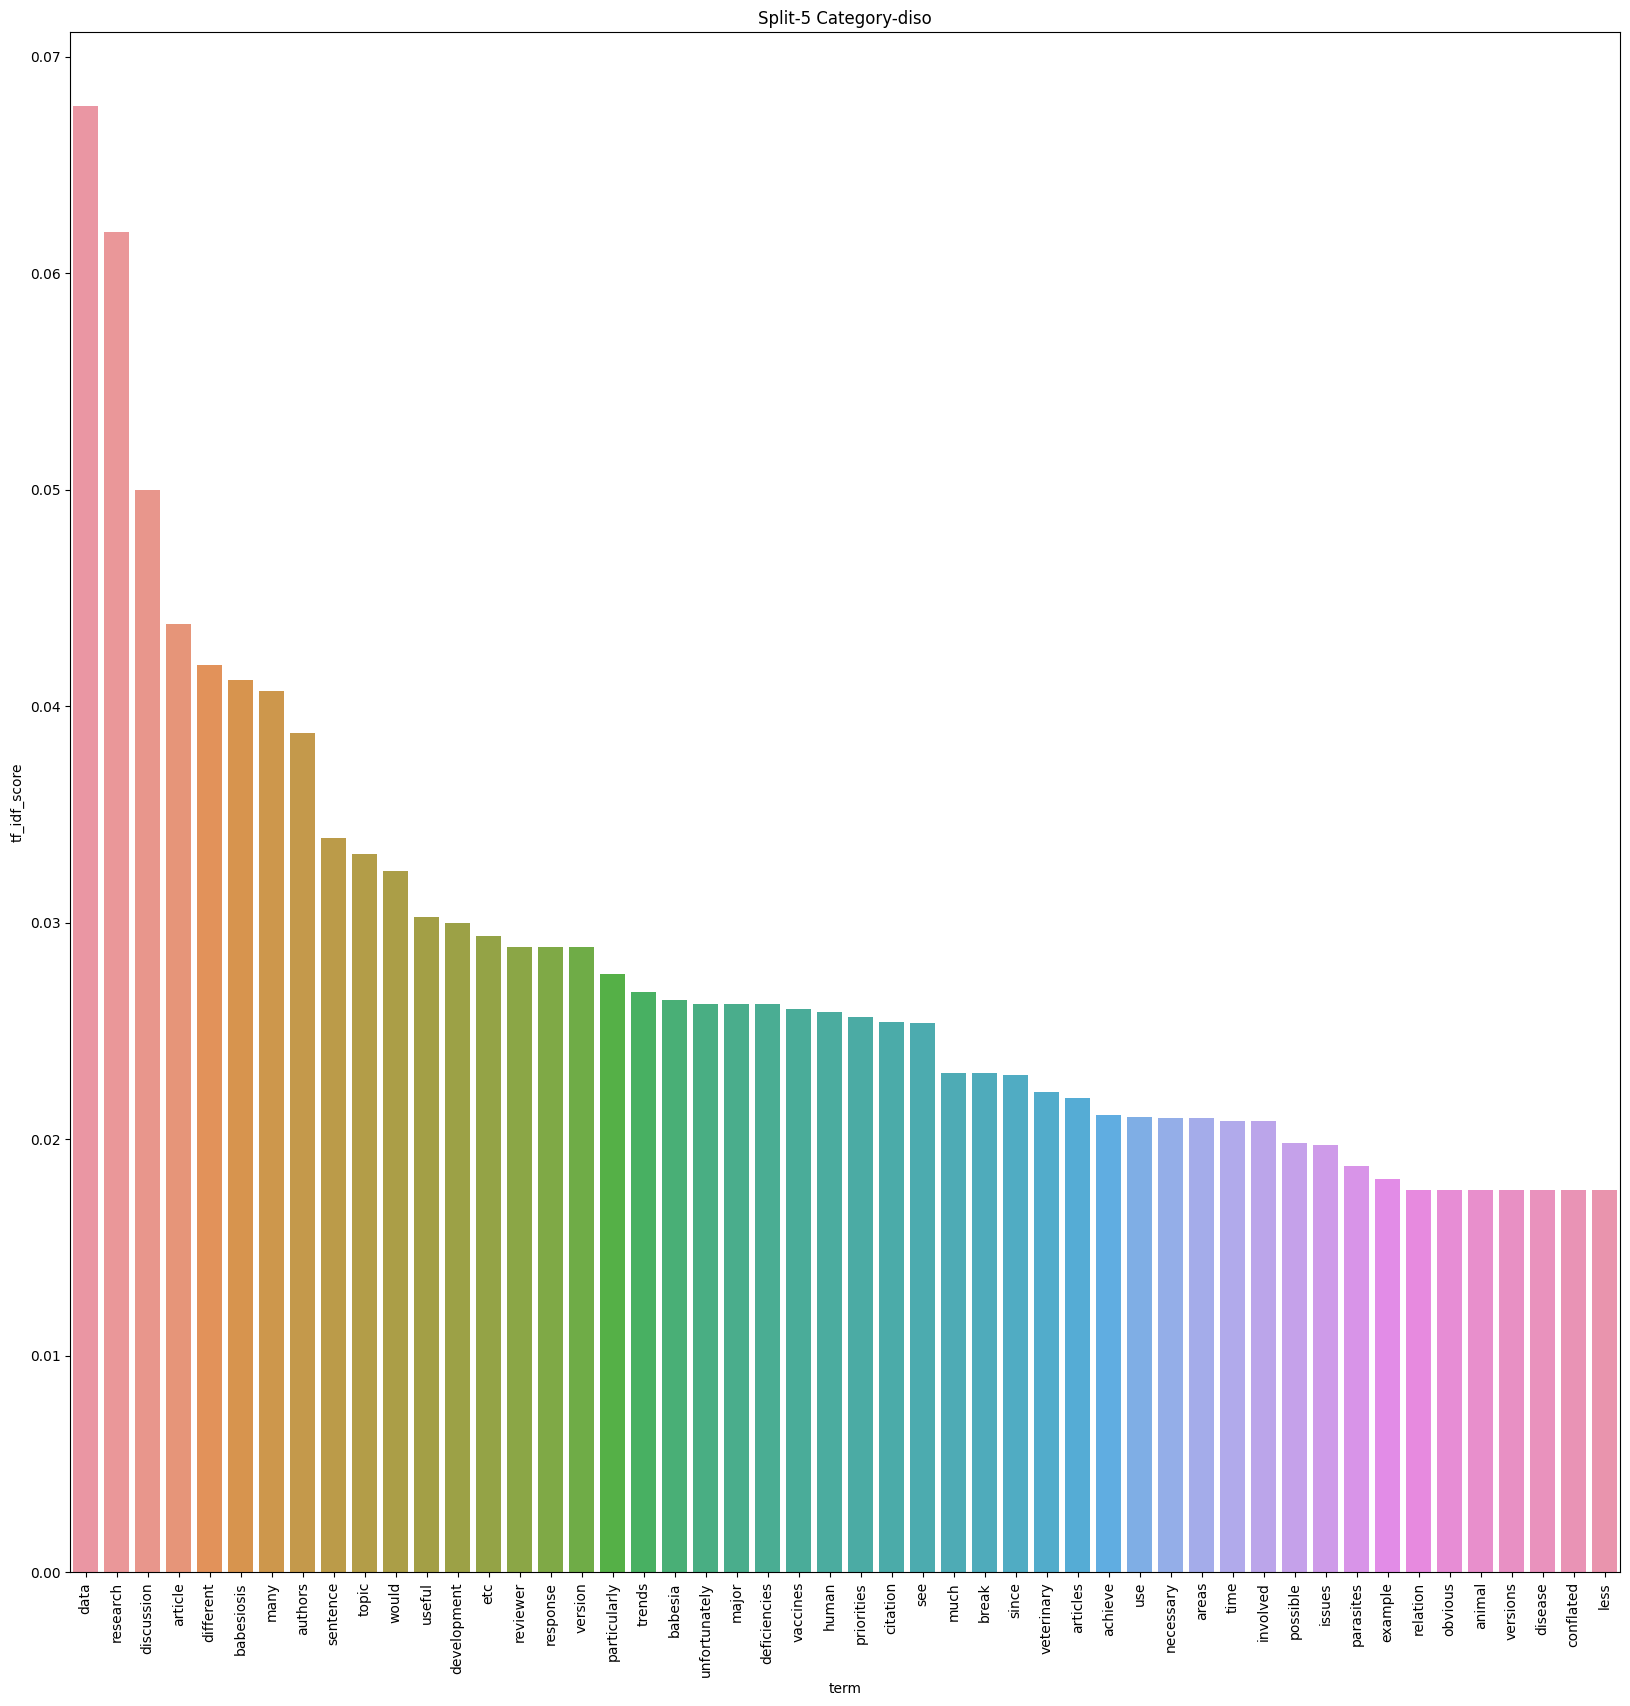

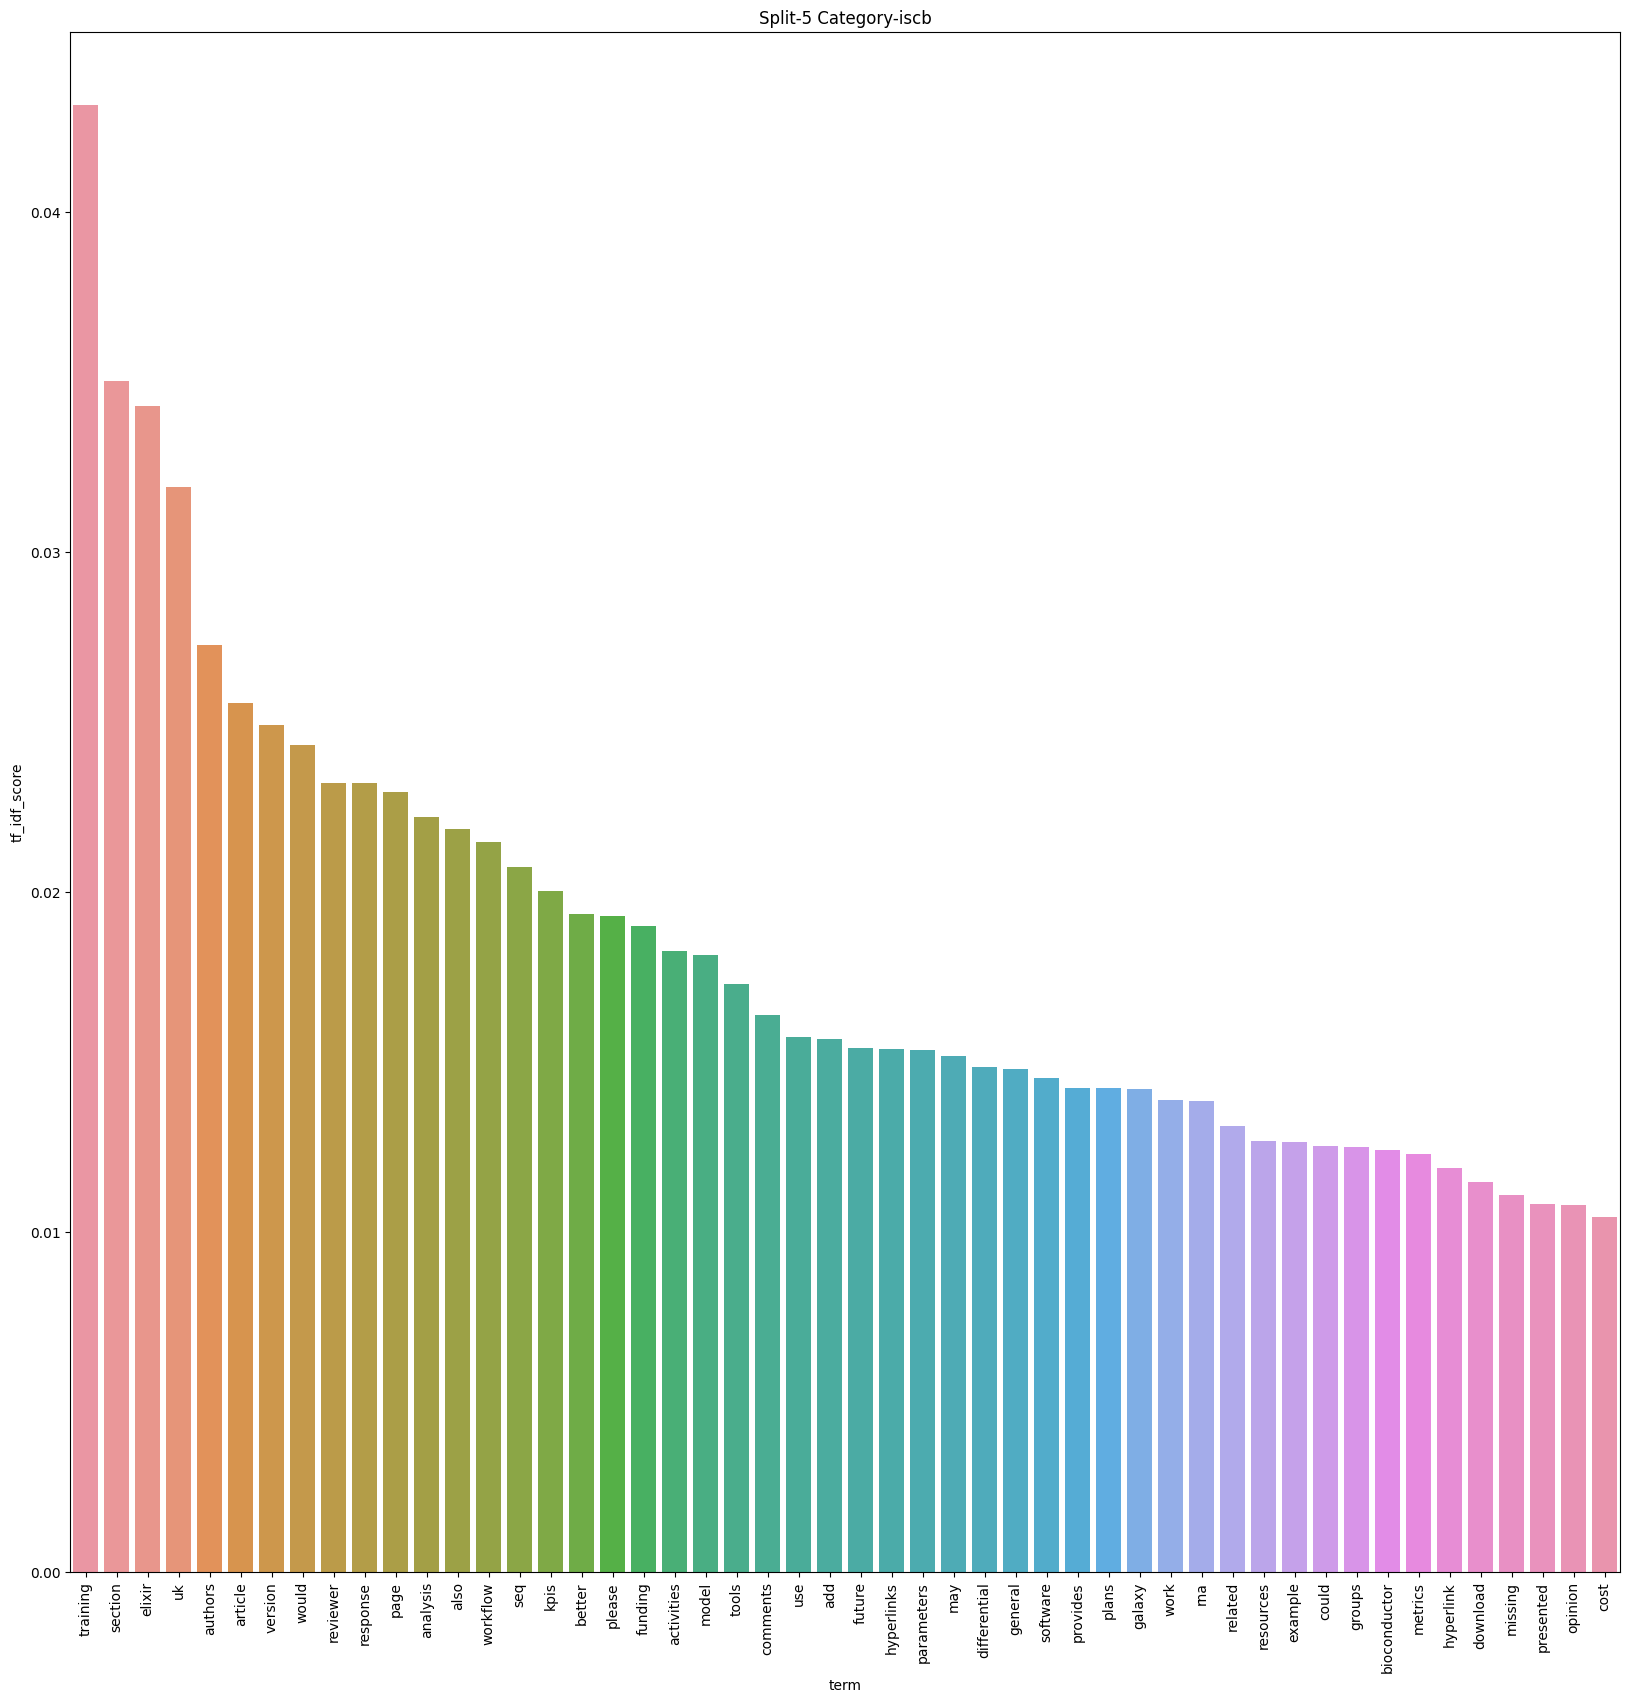

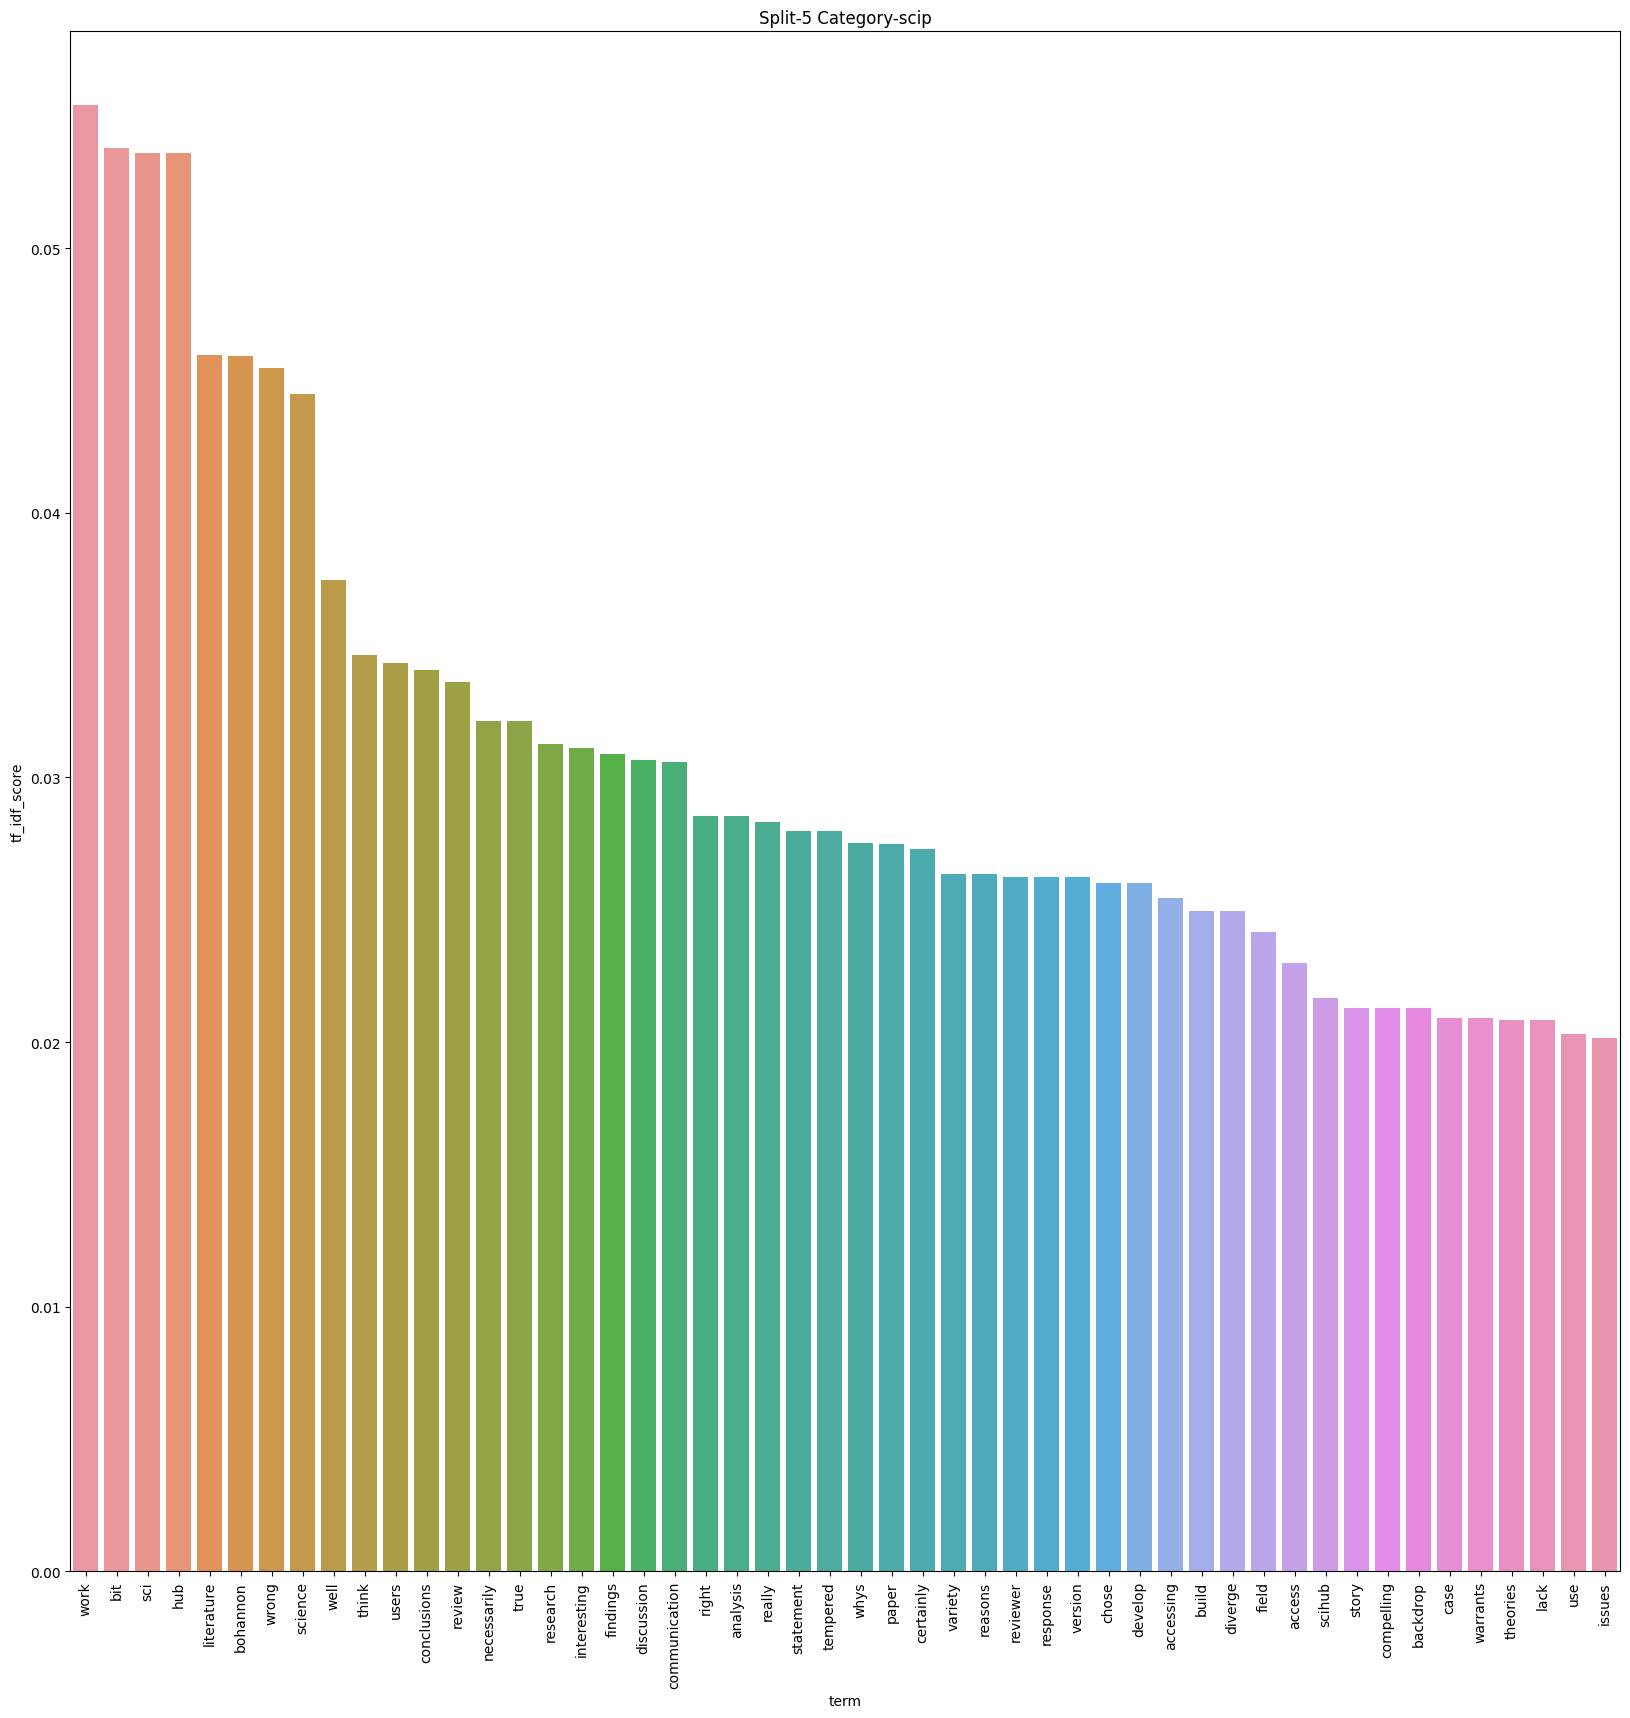

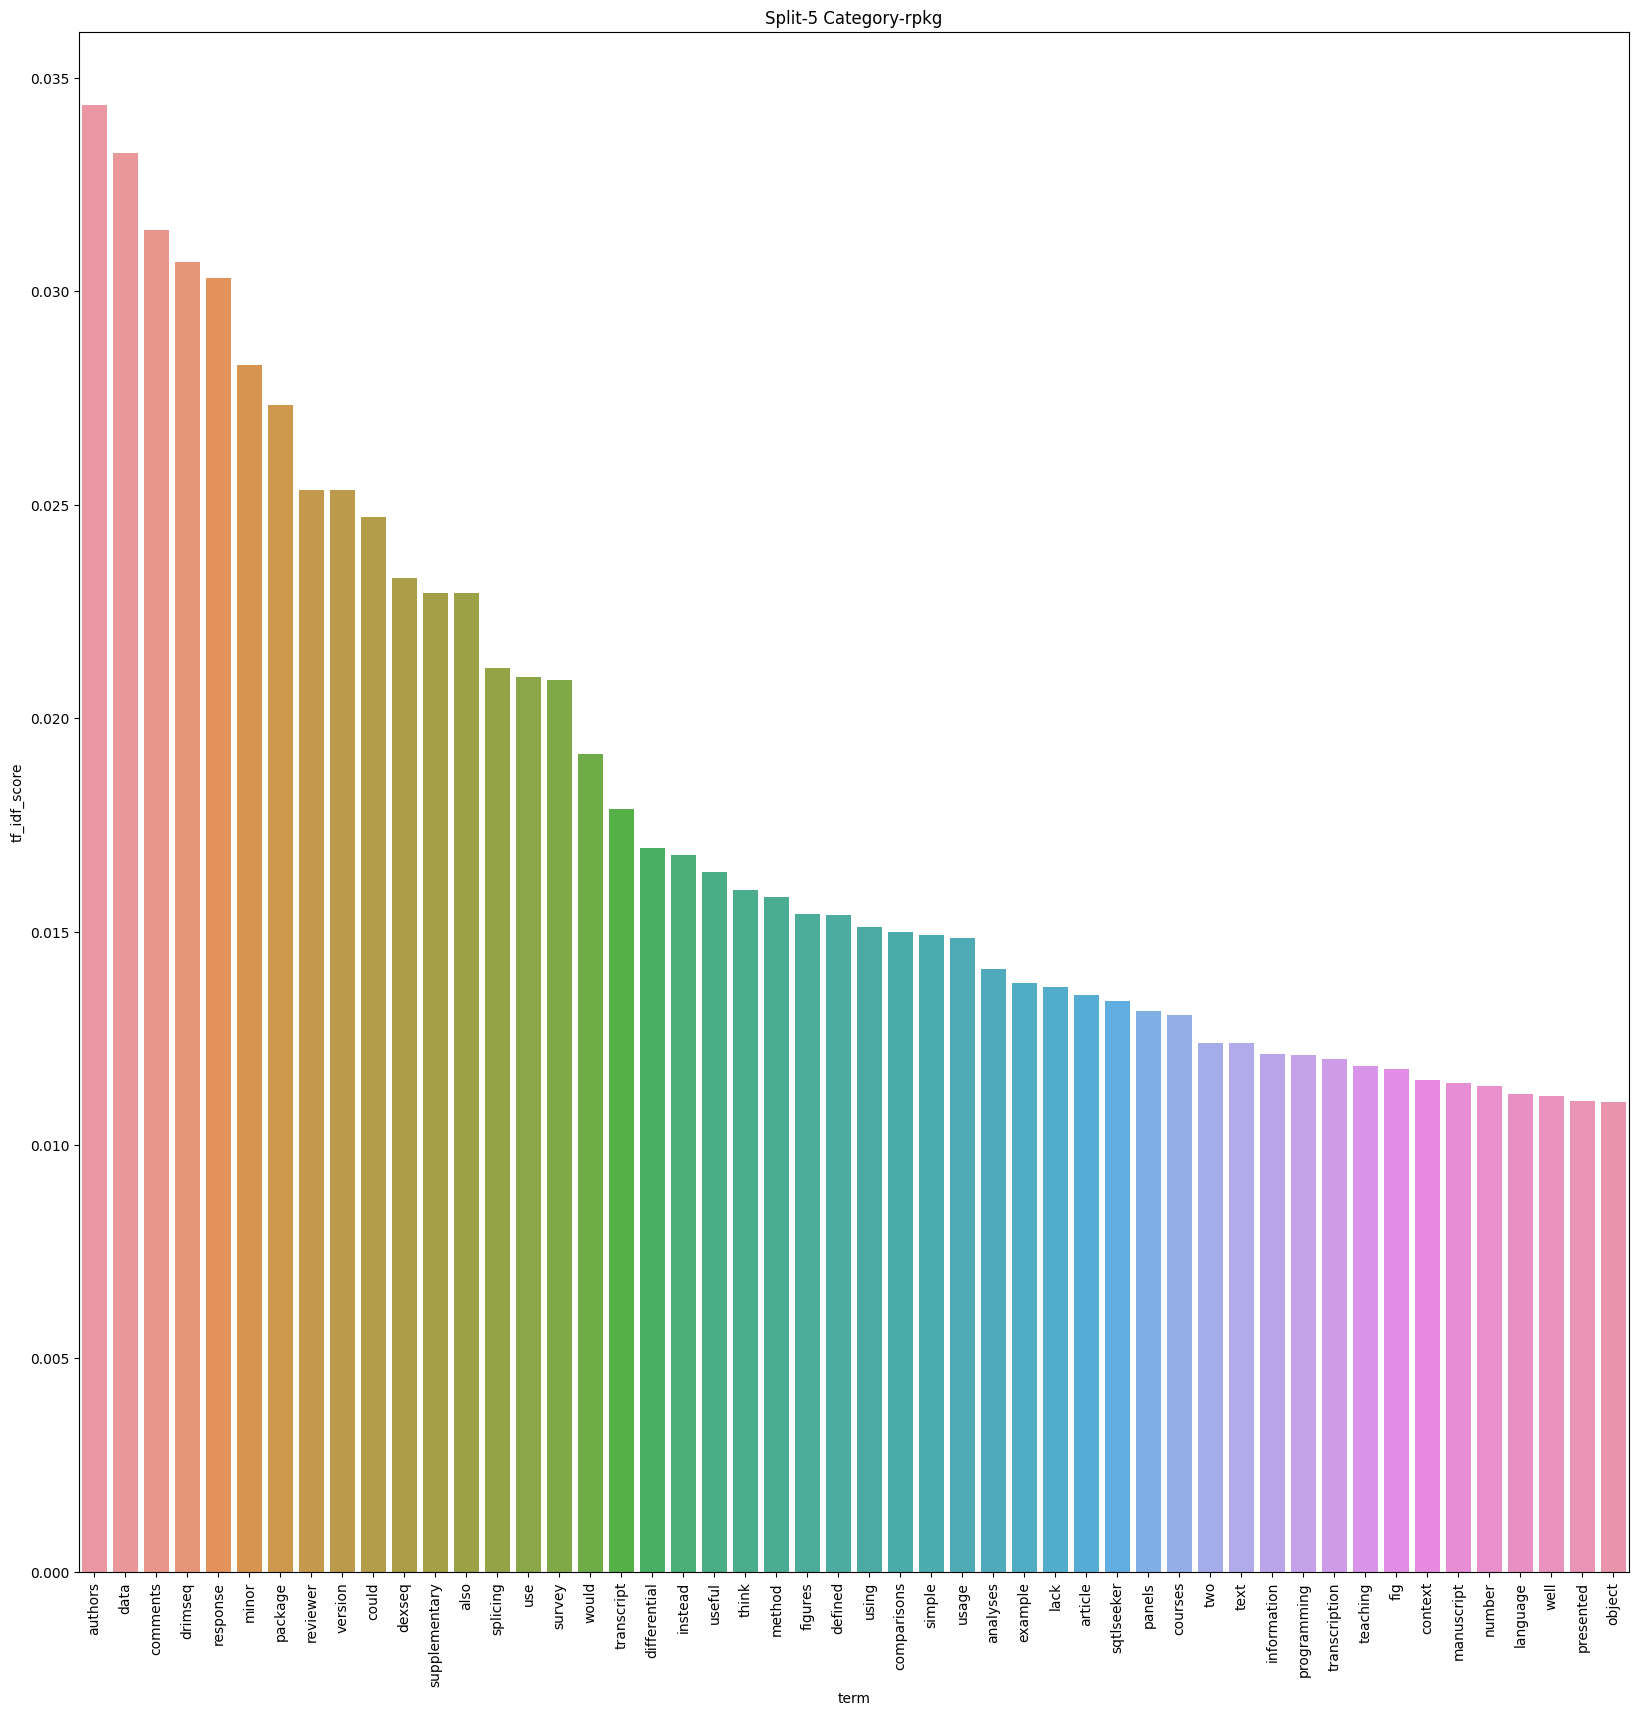

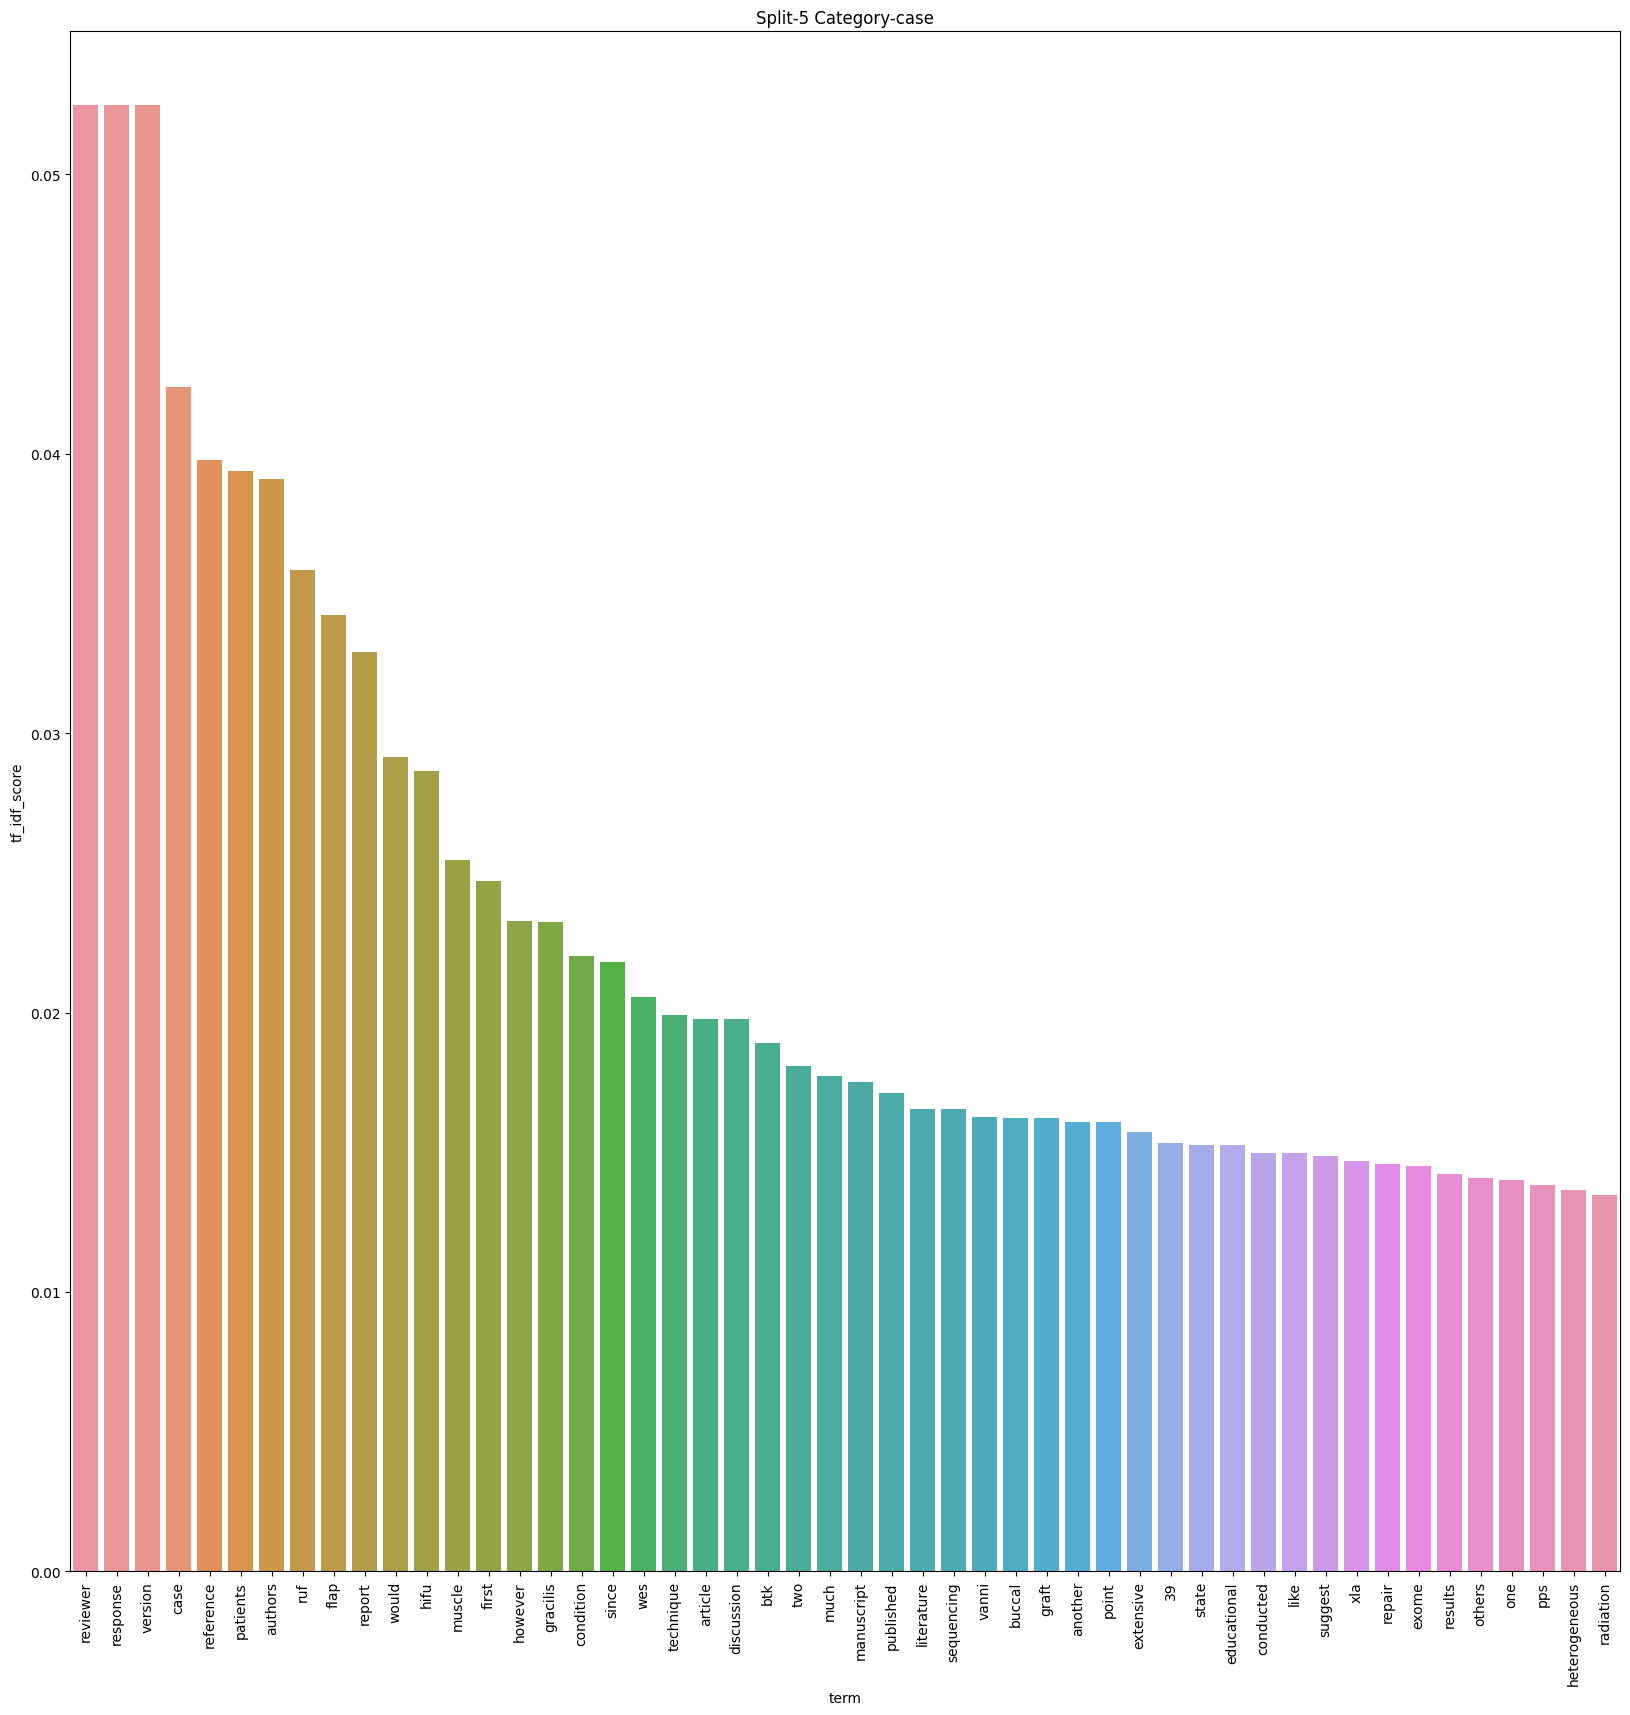

In [11]:
for split in category_vocab_dict:
    for category in category_vocab_dict[split]:
        tmp_df = \
        pd.DataFrame.from_dict(category_vocab_dict[split][category]).T.reset_index()
        tmp_df.rename({0:"tf_idf_score","index":"term"},axis=1,inplace=True)
        tmp_df = tmp_df.iloc[:50,:]
        f = plt.figure()
        ax = sns.barplot(tmp_df,x="term",y="tf_idf_score",)
        ax.set_xticklabels(tmp_df["term"].tolist(),rotation=90)
        ax.set_title(f"Split-{split+1} Category-{category}")
        f.savefig(f"vocabulary-overlap-{split}-{category}.pdf", bbox_inches='tight')

In [12]:
test_file = Path.cwd().joinpath("public_data","test_inputs.json")

with open(test_file,"r") as f:
    test_dict_data = json.load(f)
test_full_data = datasets.Dataset.from_list(to_context_free_format(test_file))
test_full_data = datasets.Dataset.from_list(to_context_free_format(test_file))
test_full_data_df = test_full_data.to_pandas()

In [13]:
category_vocab_dict = {}
category_vocab_dict["test"] = create_wordcloud("test",test_full_data_df)

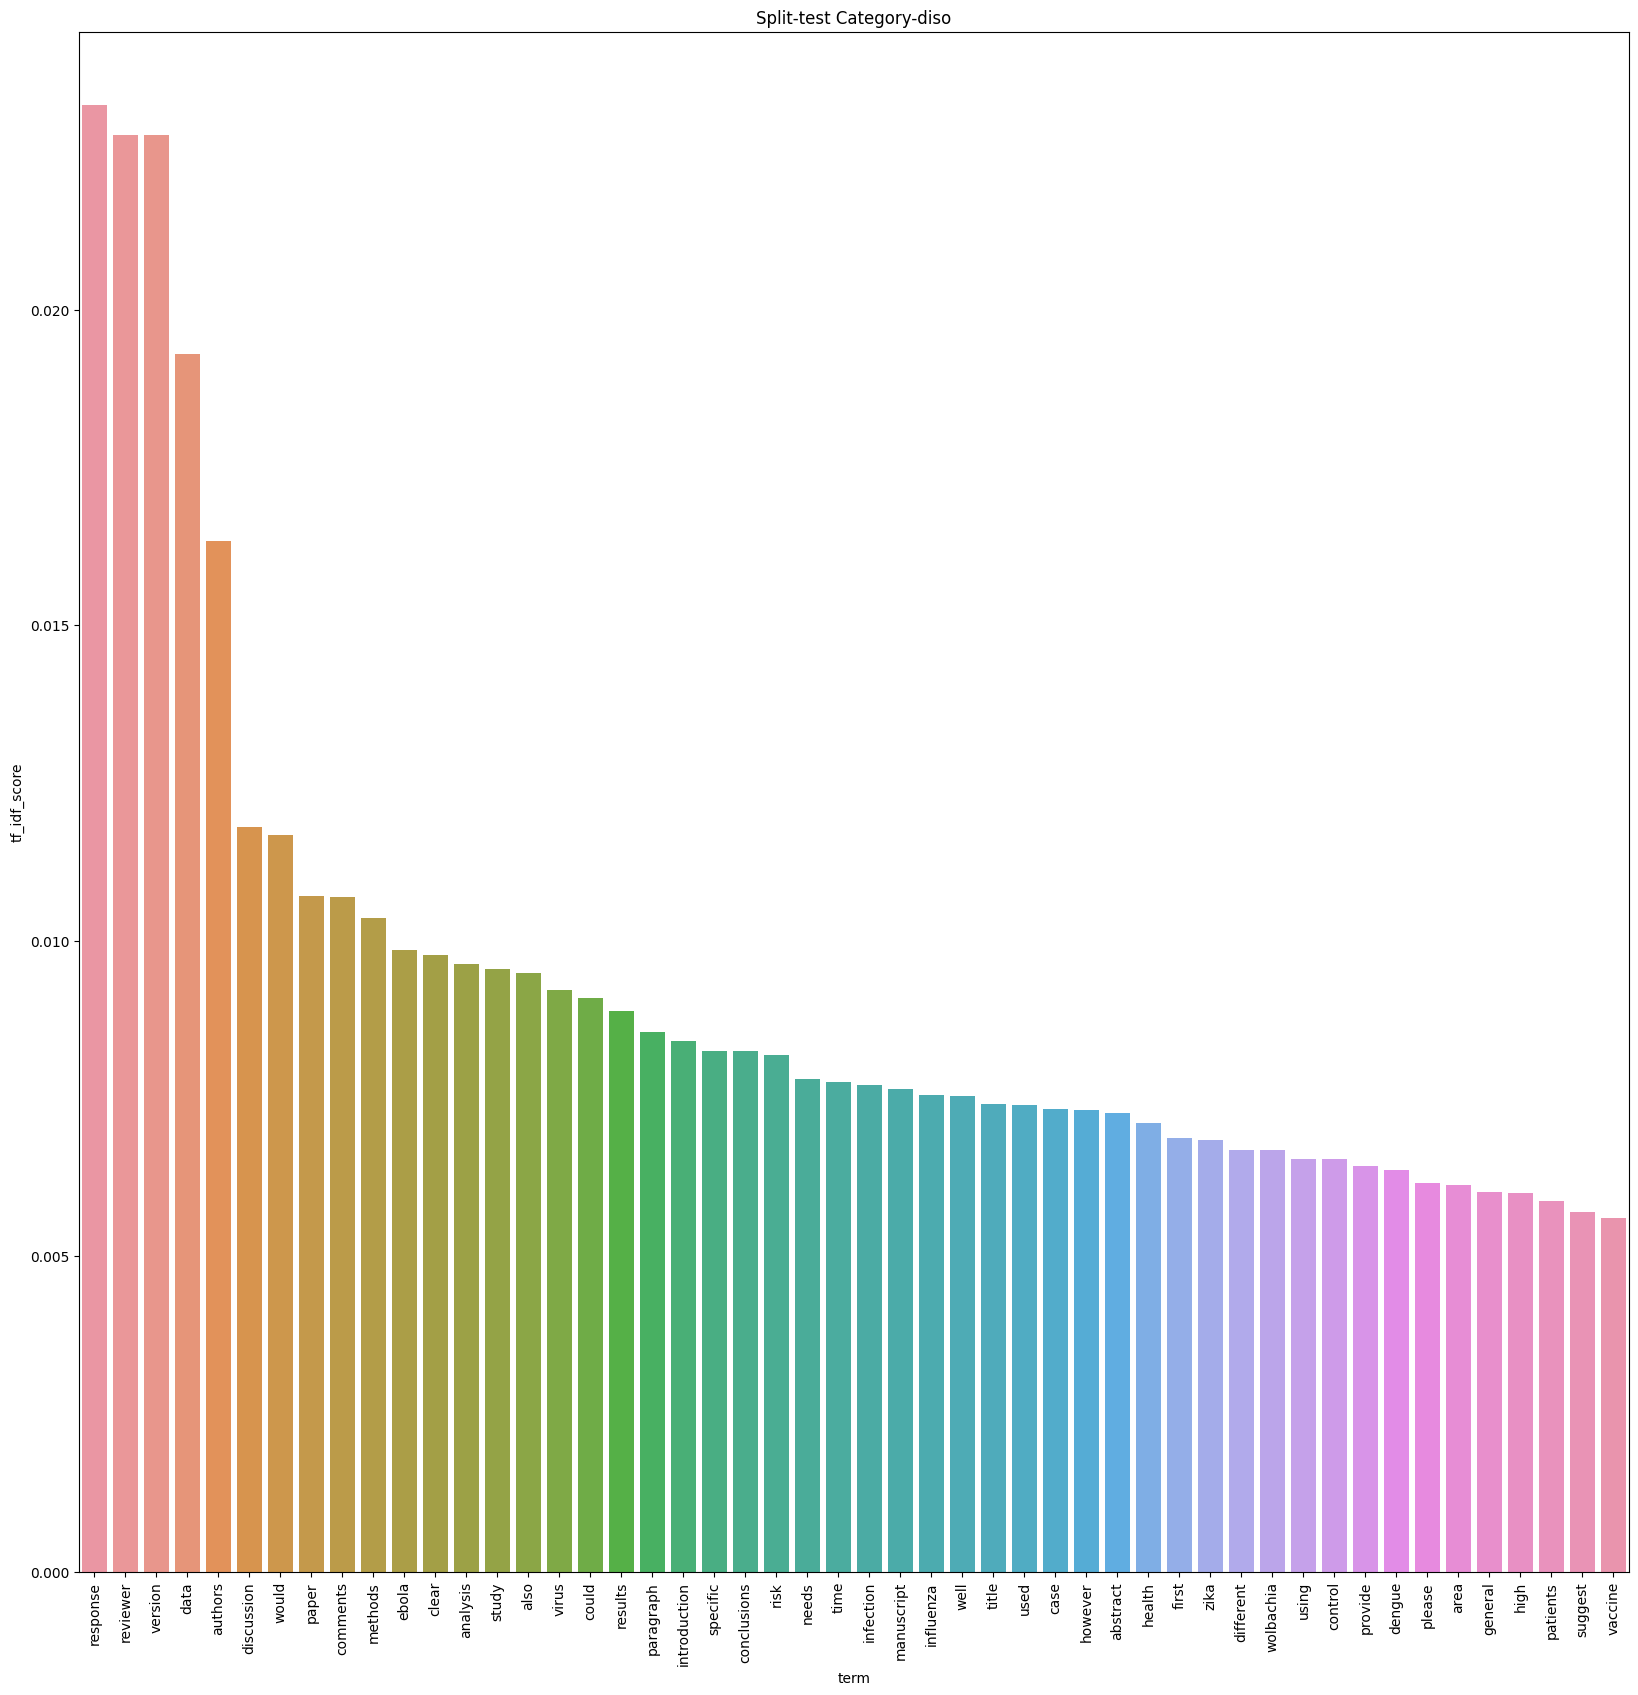

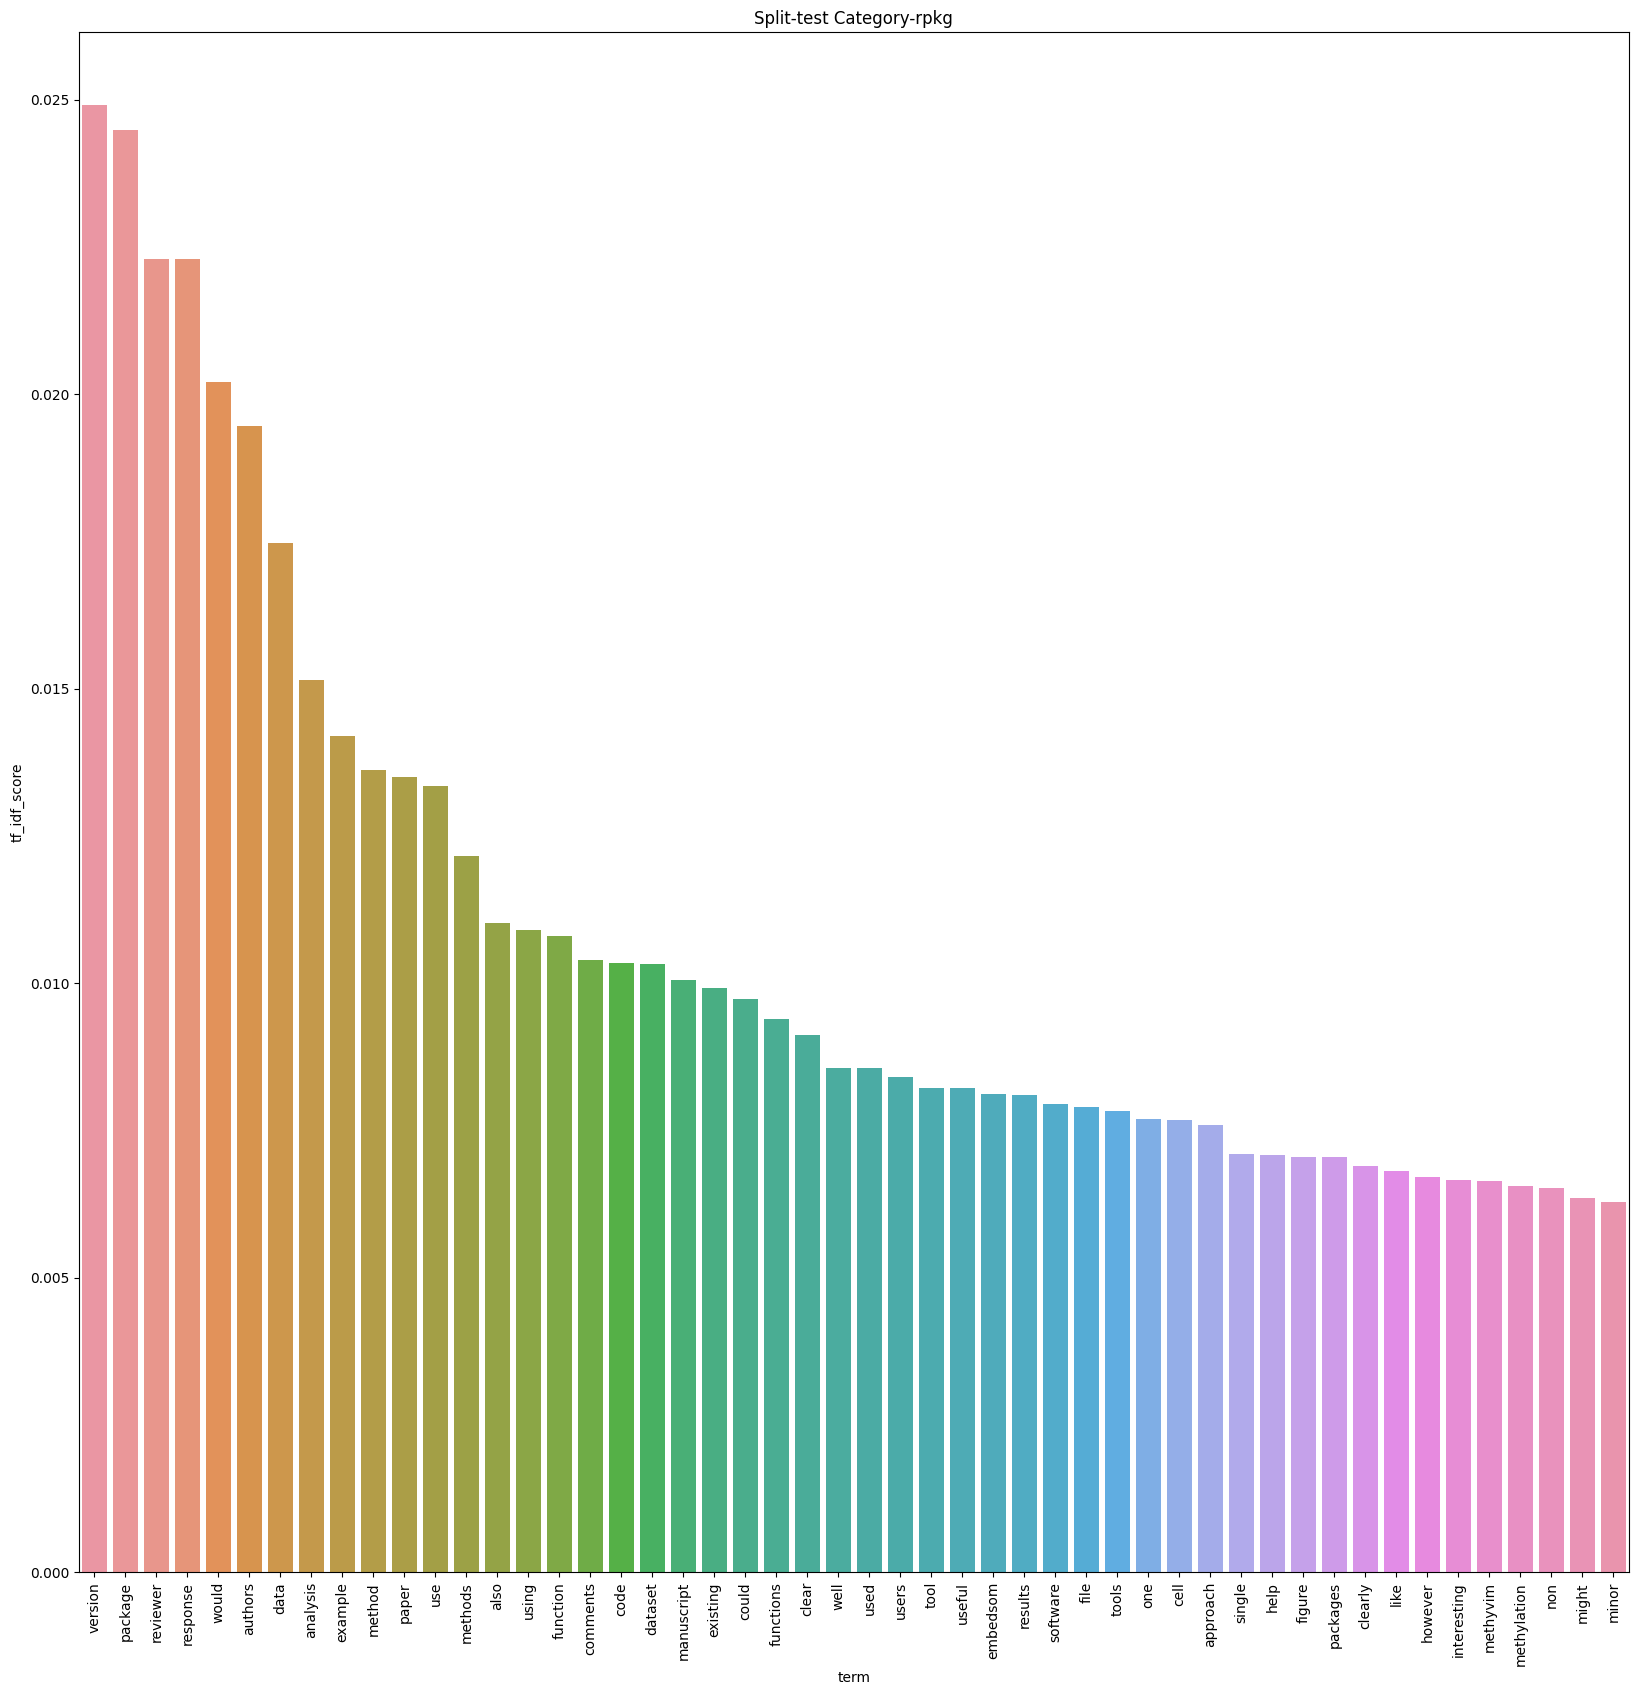

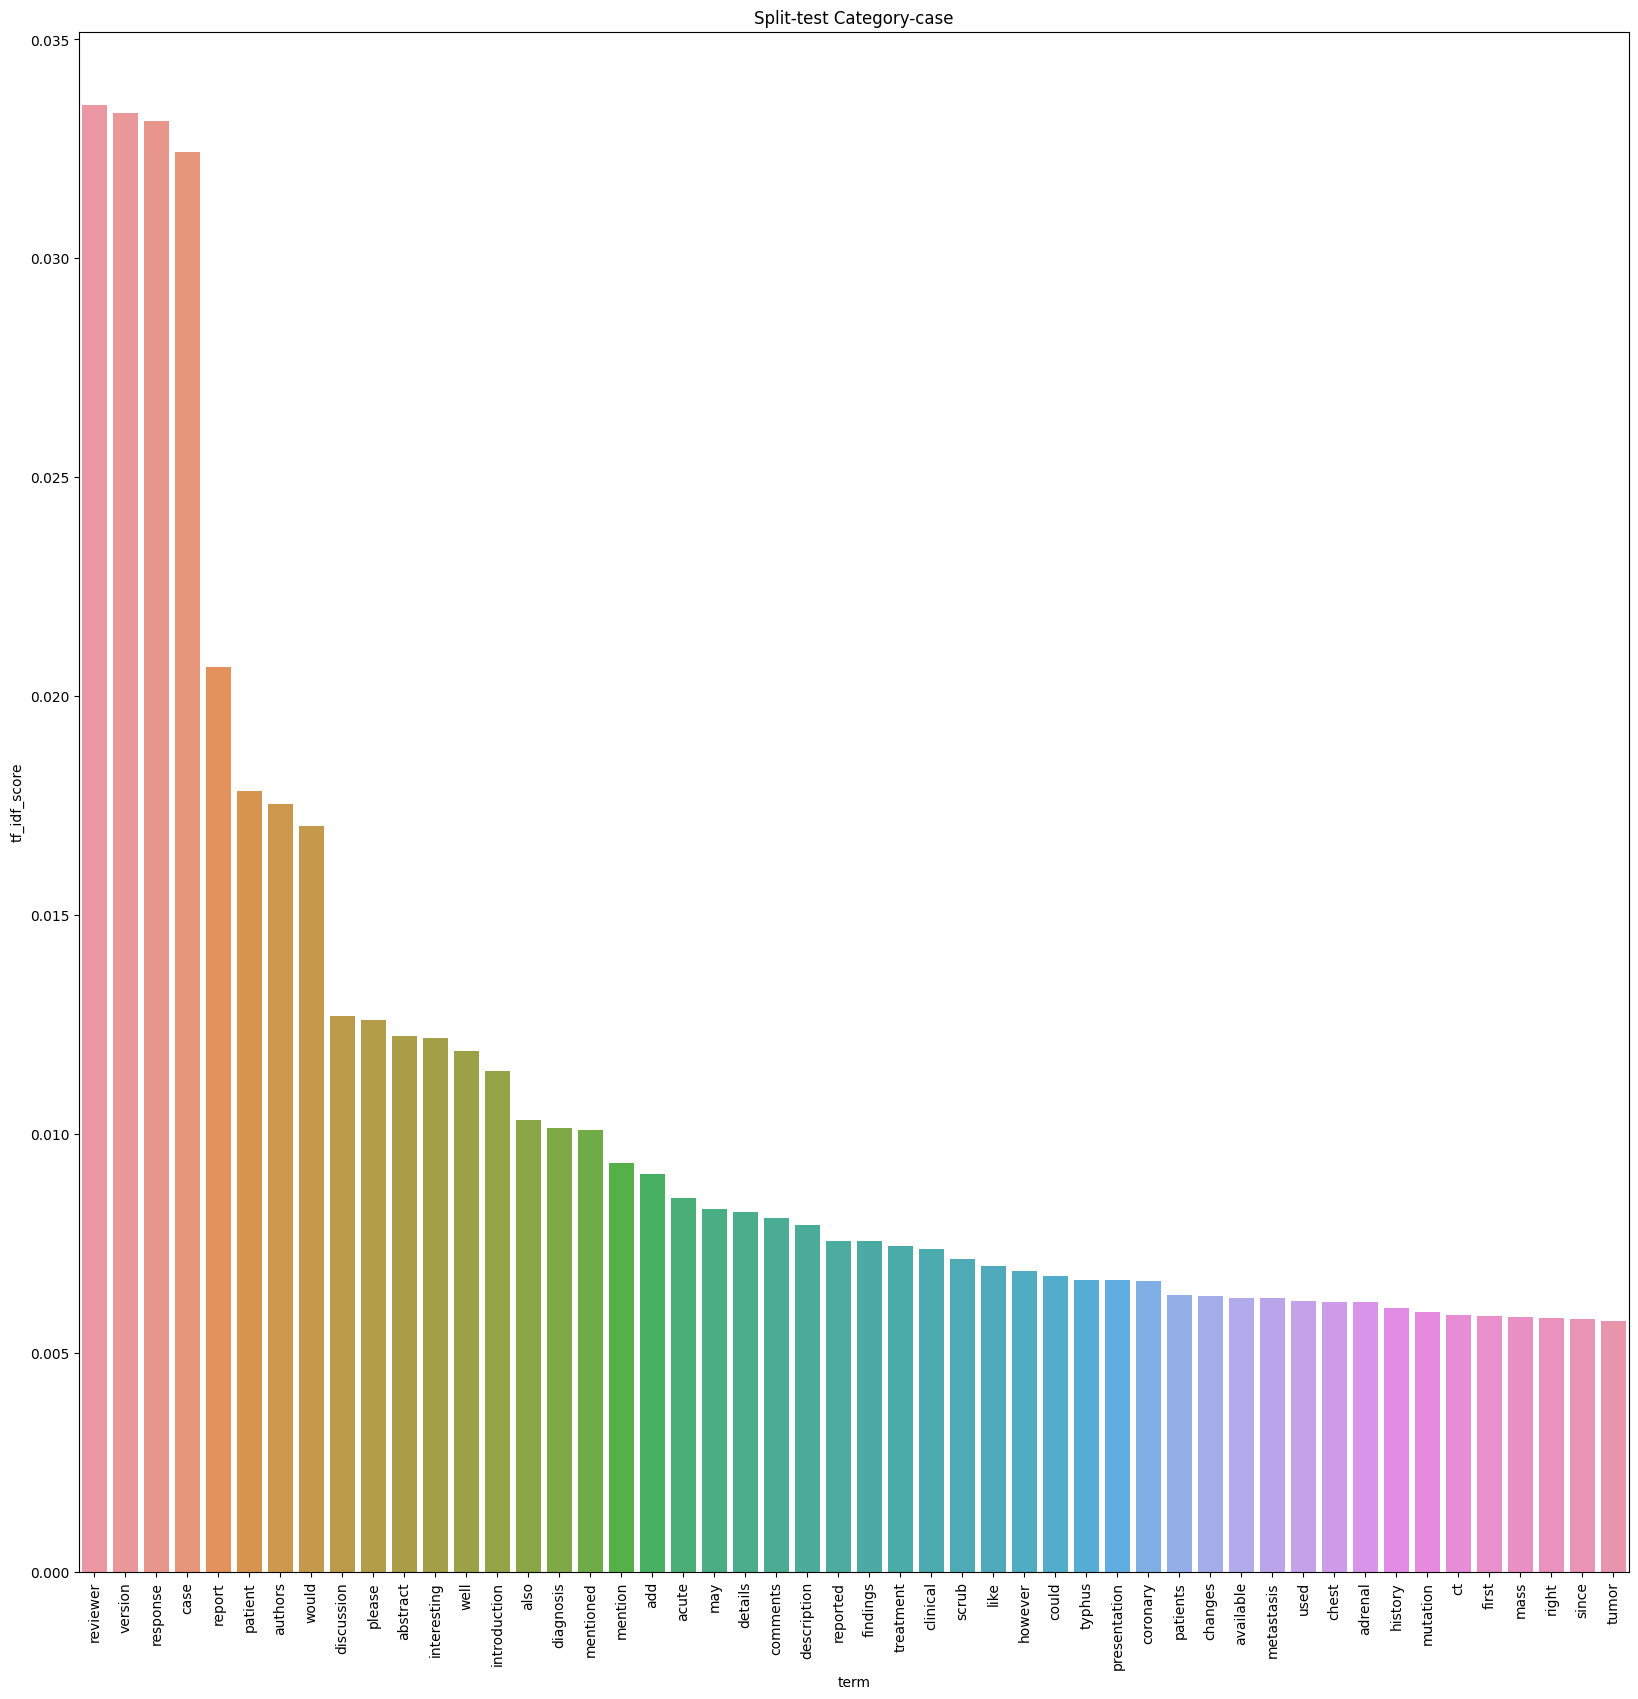

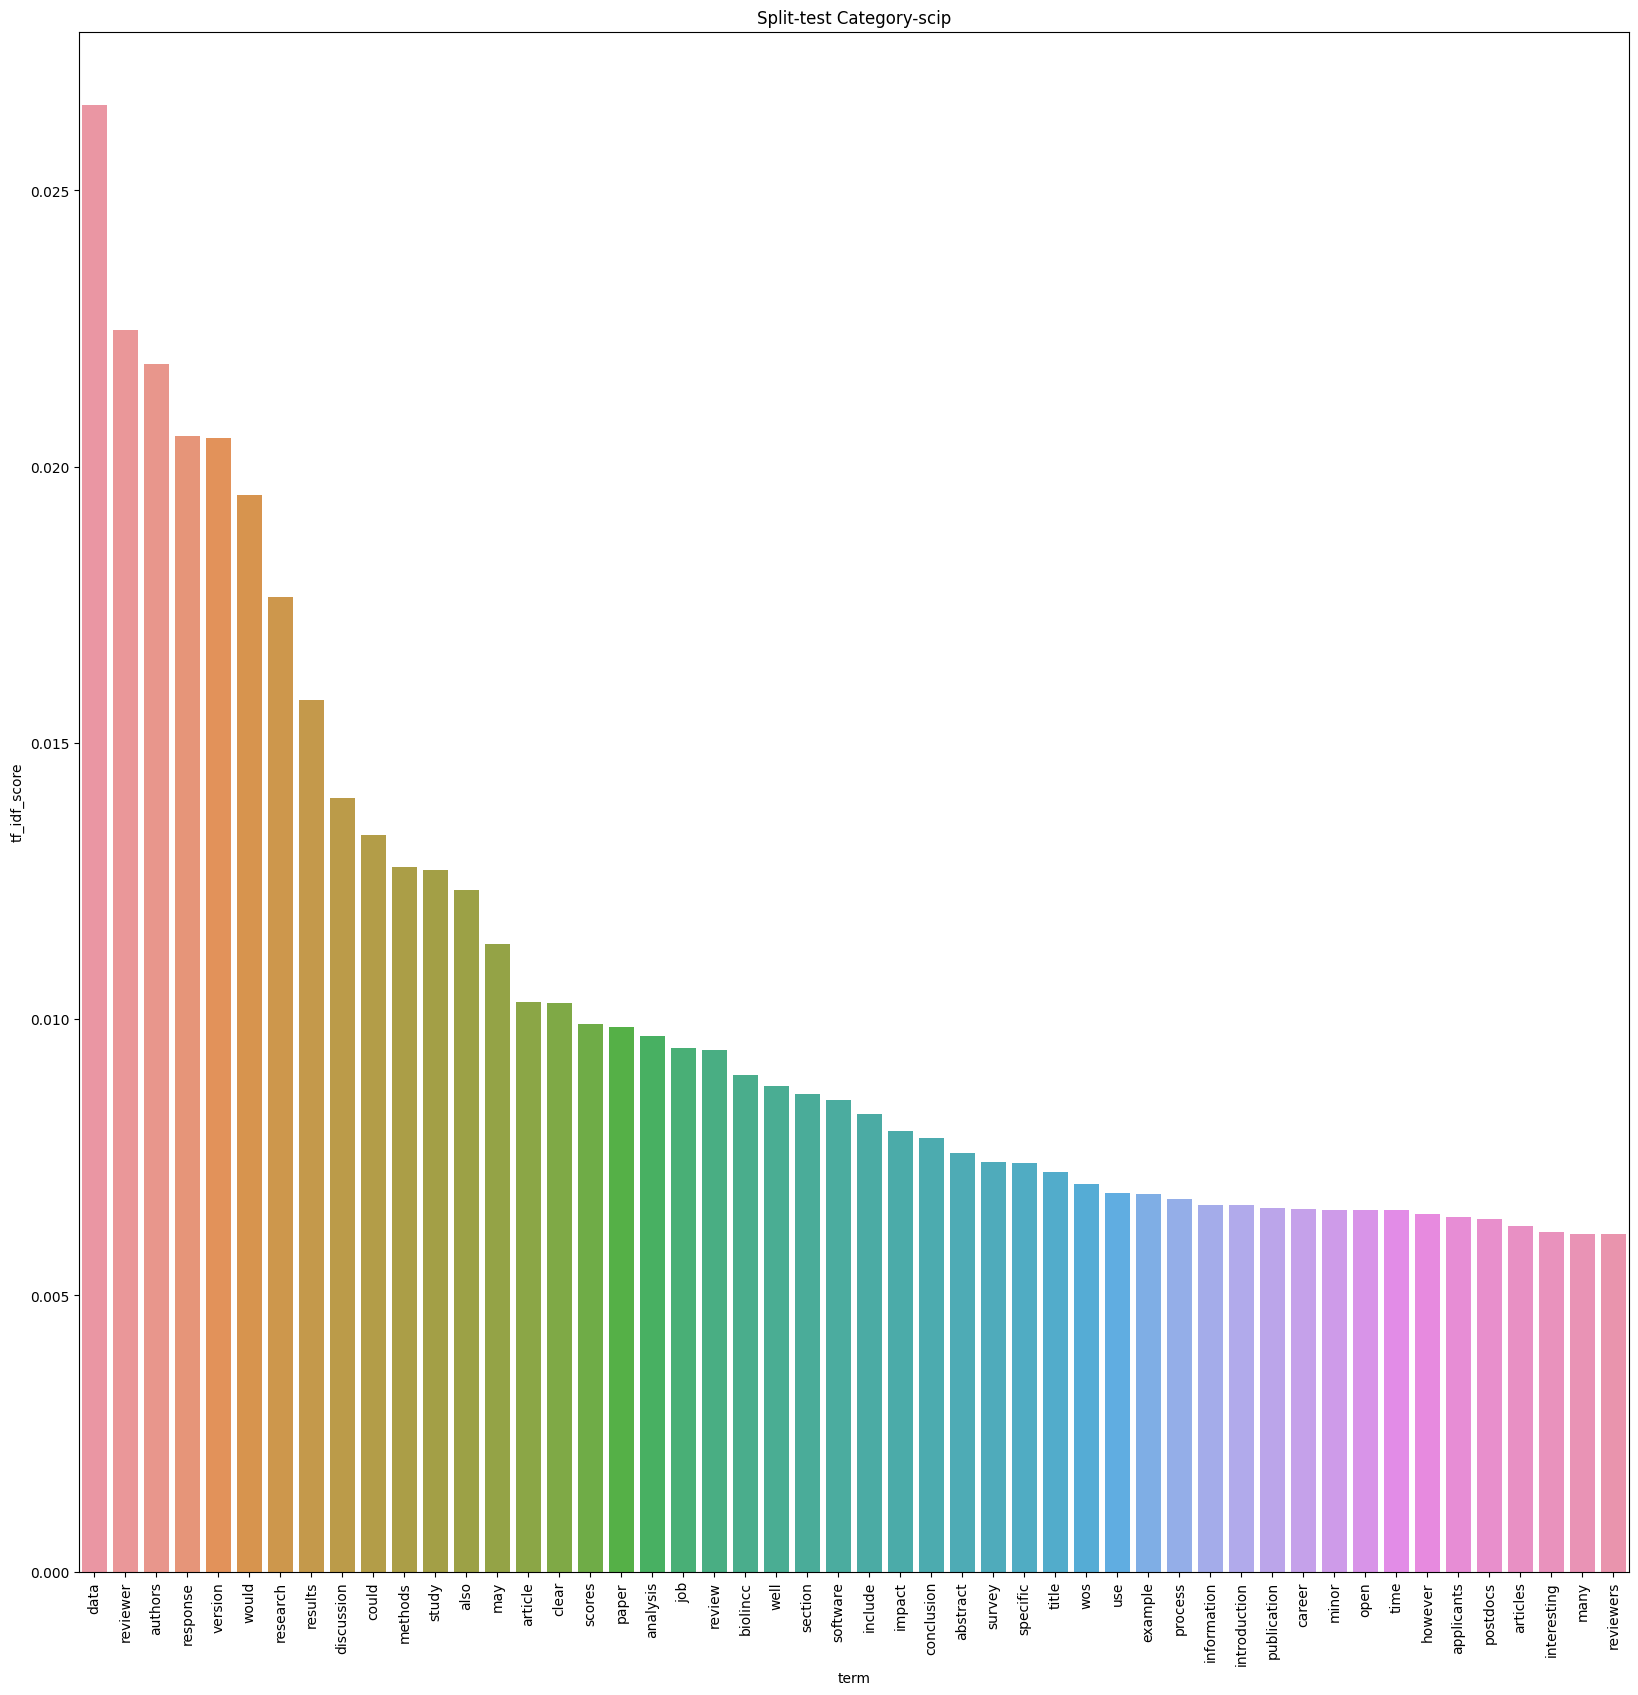

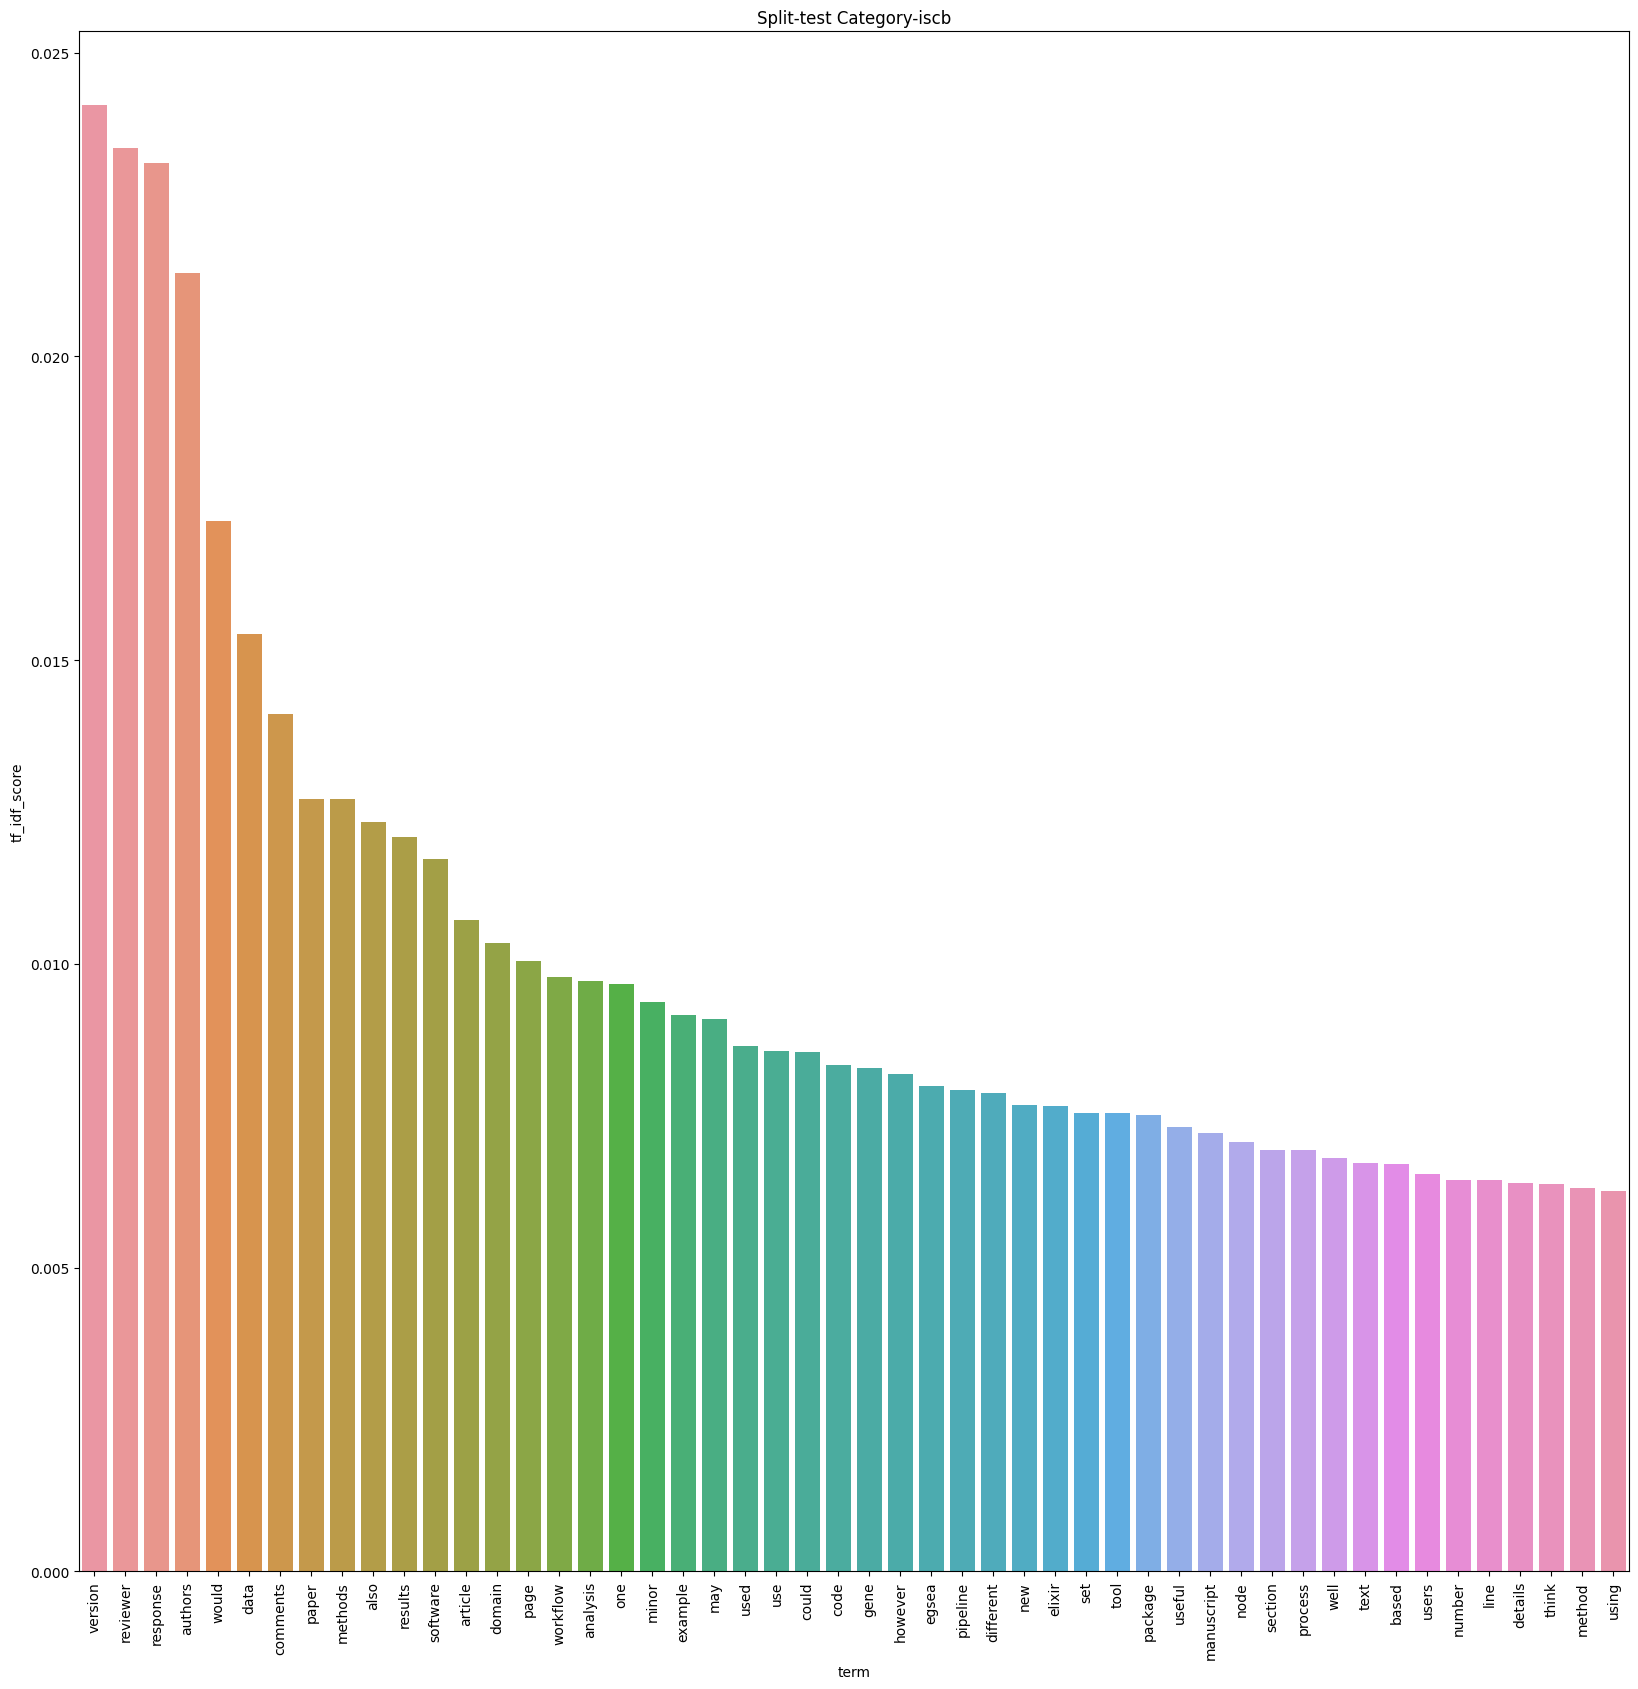

In [14]:
for split in category_vocab_dict:
    for category in category_vocab_dict[split]:
        tmp_df = \
        pd.DataFrame.from_dict(category_vocab_dict[split][category]).T.reset_index()
        tmp_df.rename({0:"tf_idf_score","index":"term"},axis=1,inplace=True)
        tmp_df = tmp_df.iloc[:50,:]
        f = plt.figure()
        ax = sns.barplot(tmp_df,x="term",y="tf_idf_score",)
        ax.set_xticklabels(tmp_df["term"].tolist(),rotation=90)
        ax.set_title(f"Split-{split} Category-{category}")
        f.savefig(f"vocabulary-overlap-{split}-{category}.pdf", bbox_inches='tight')

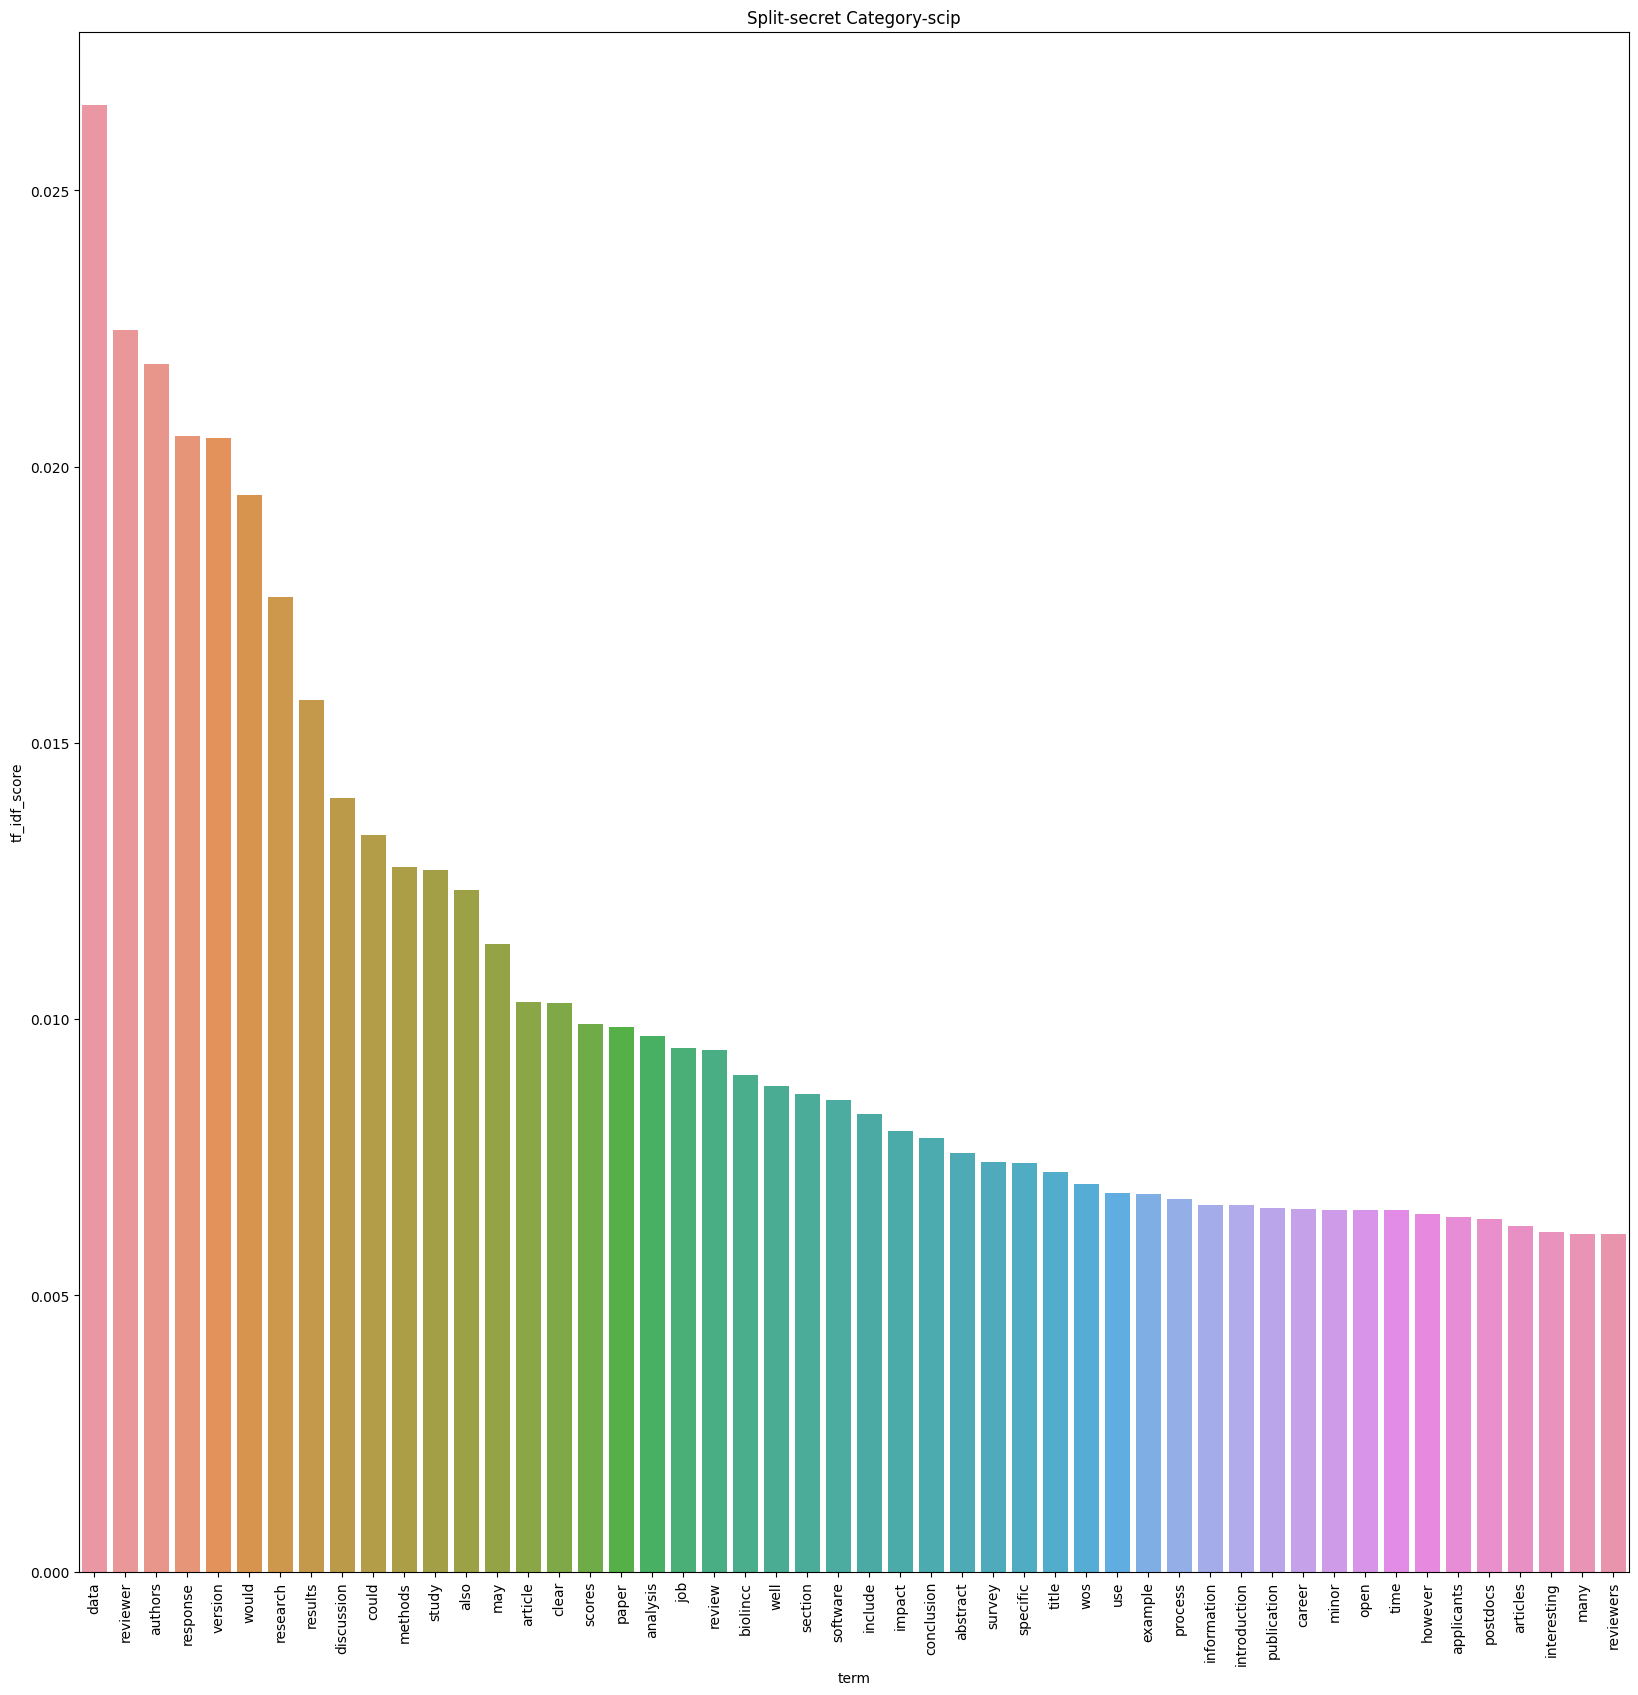

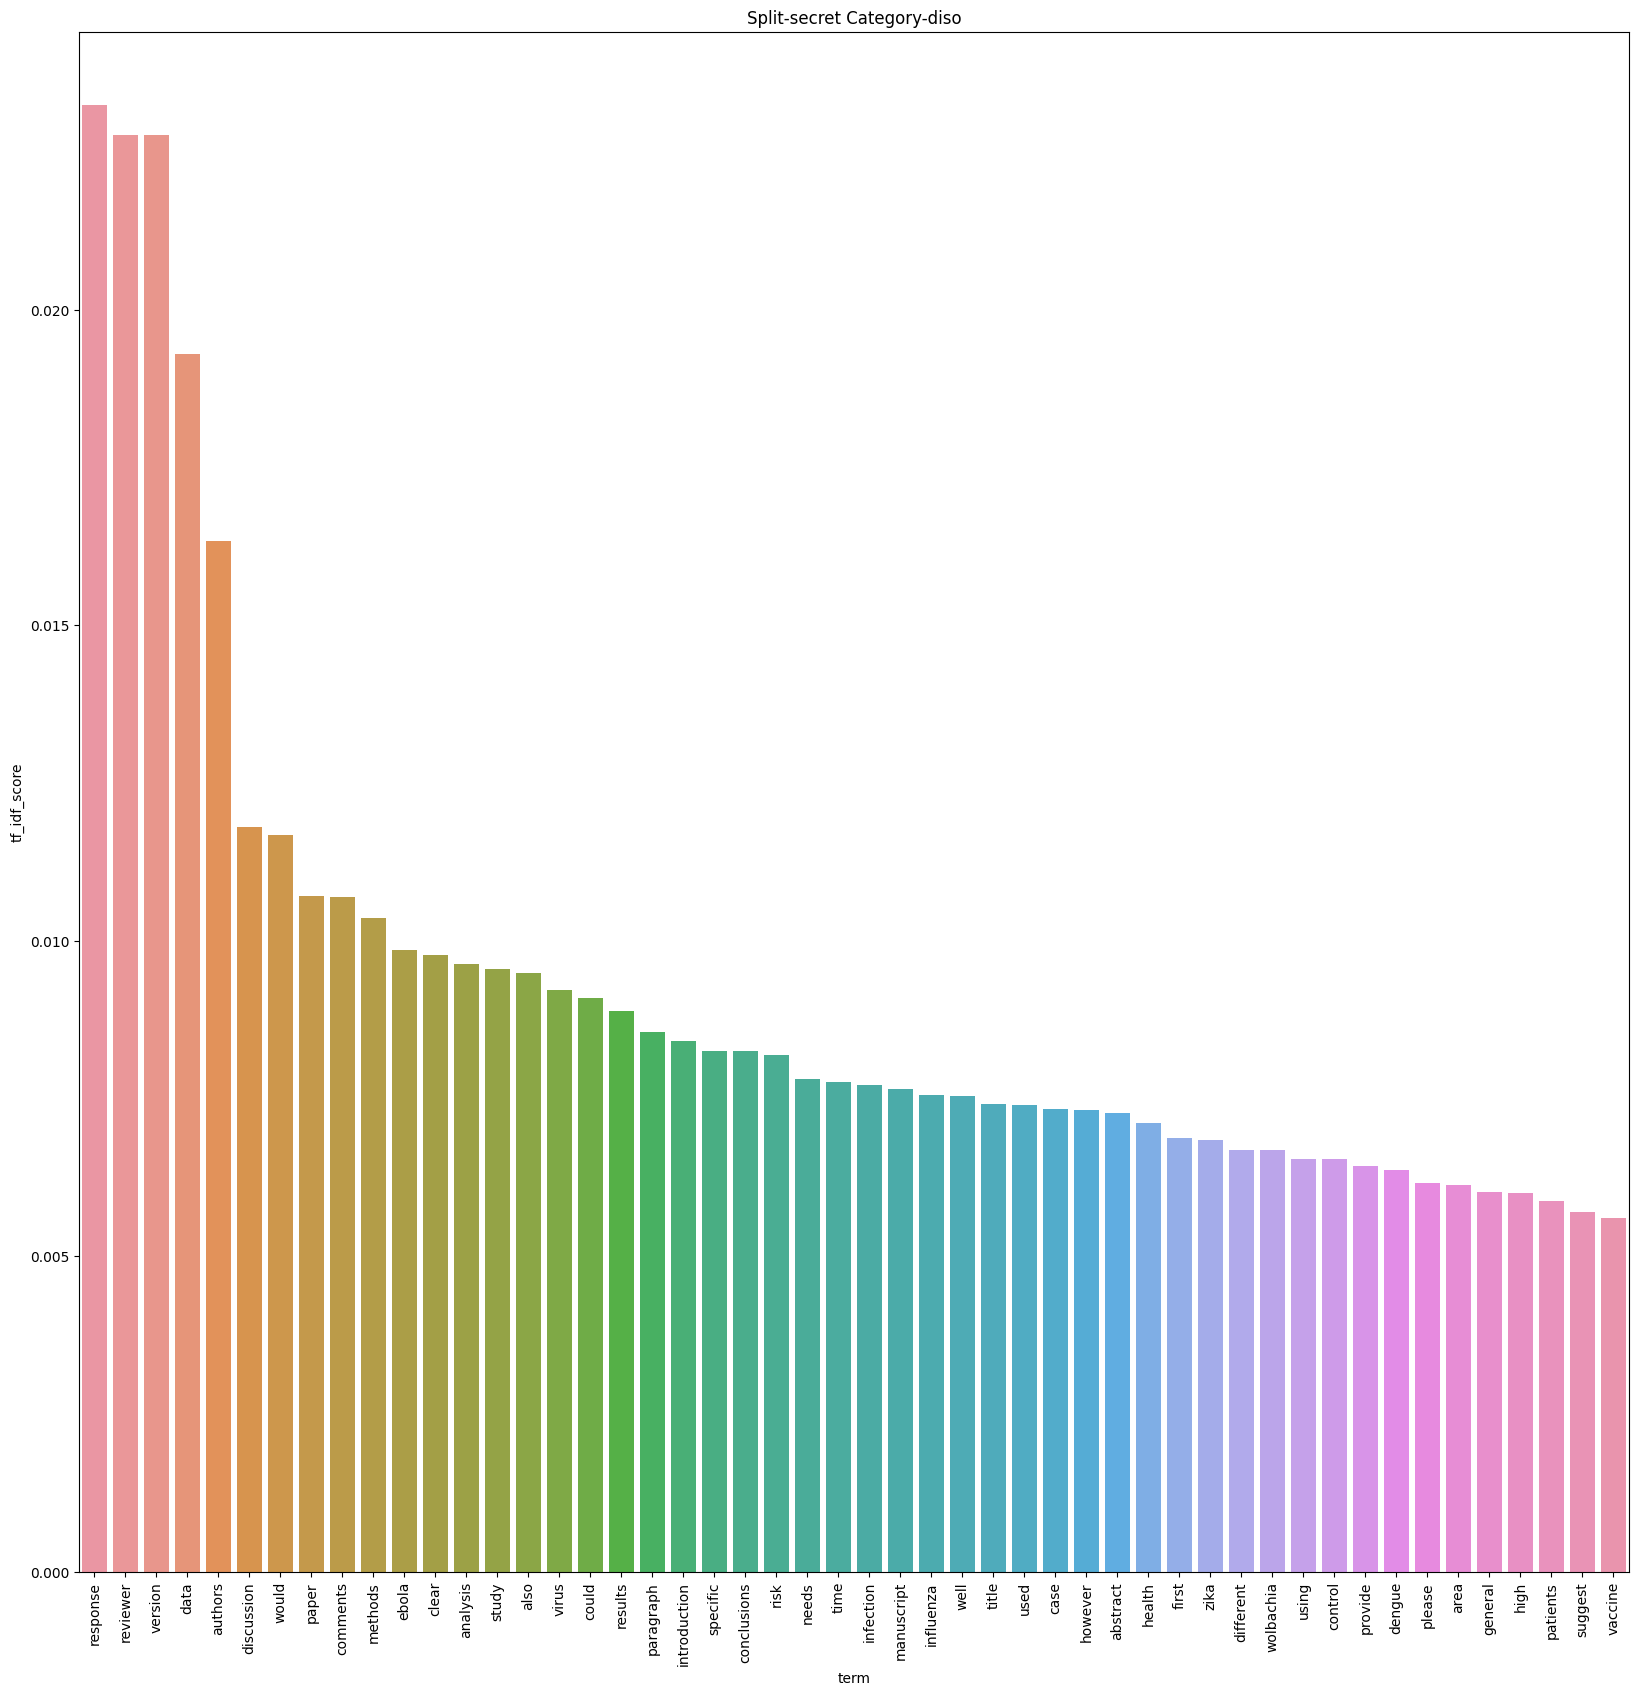

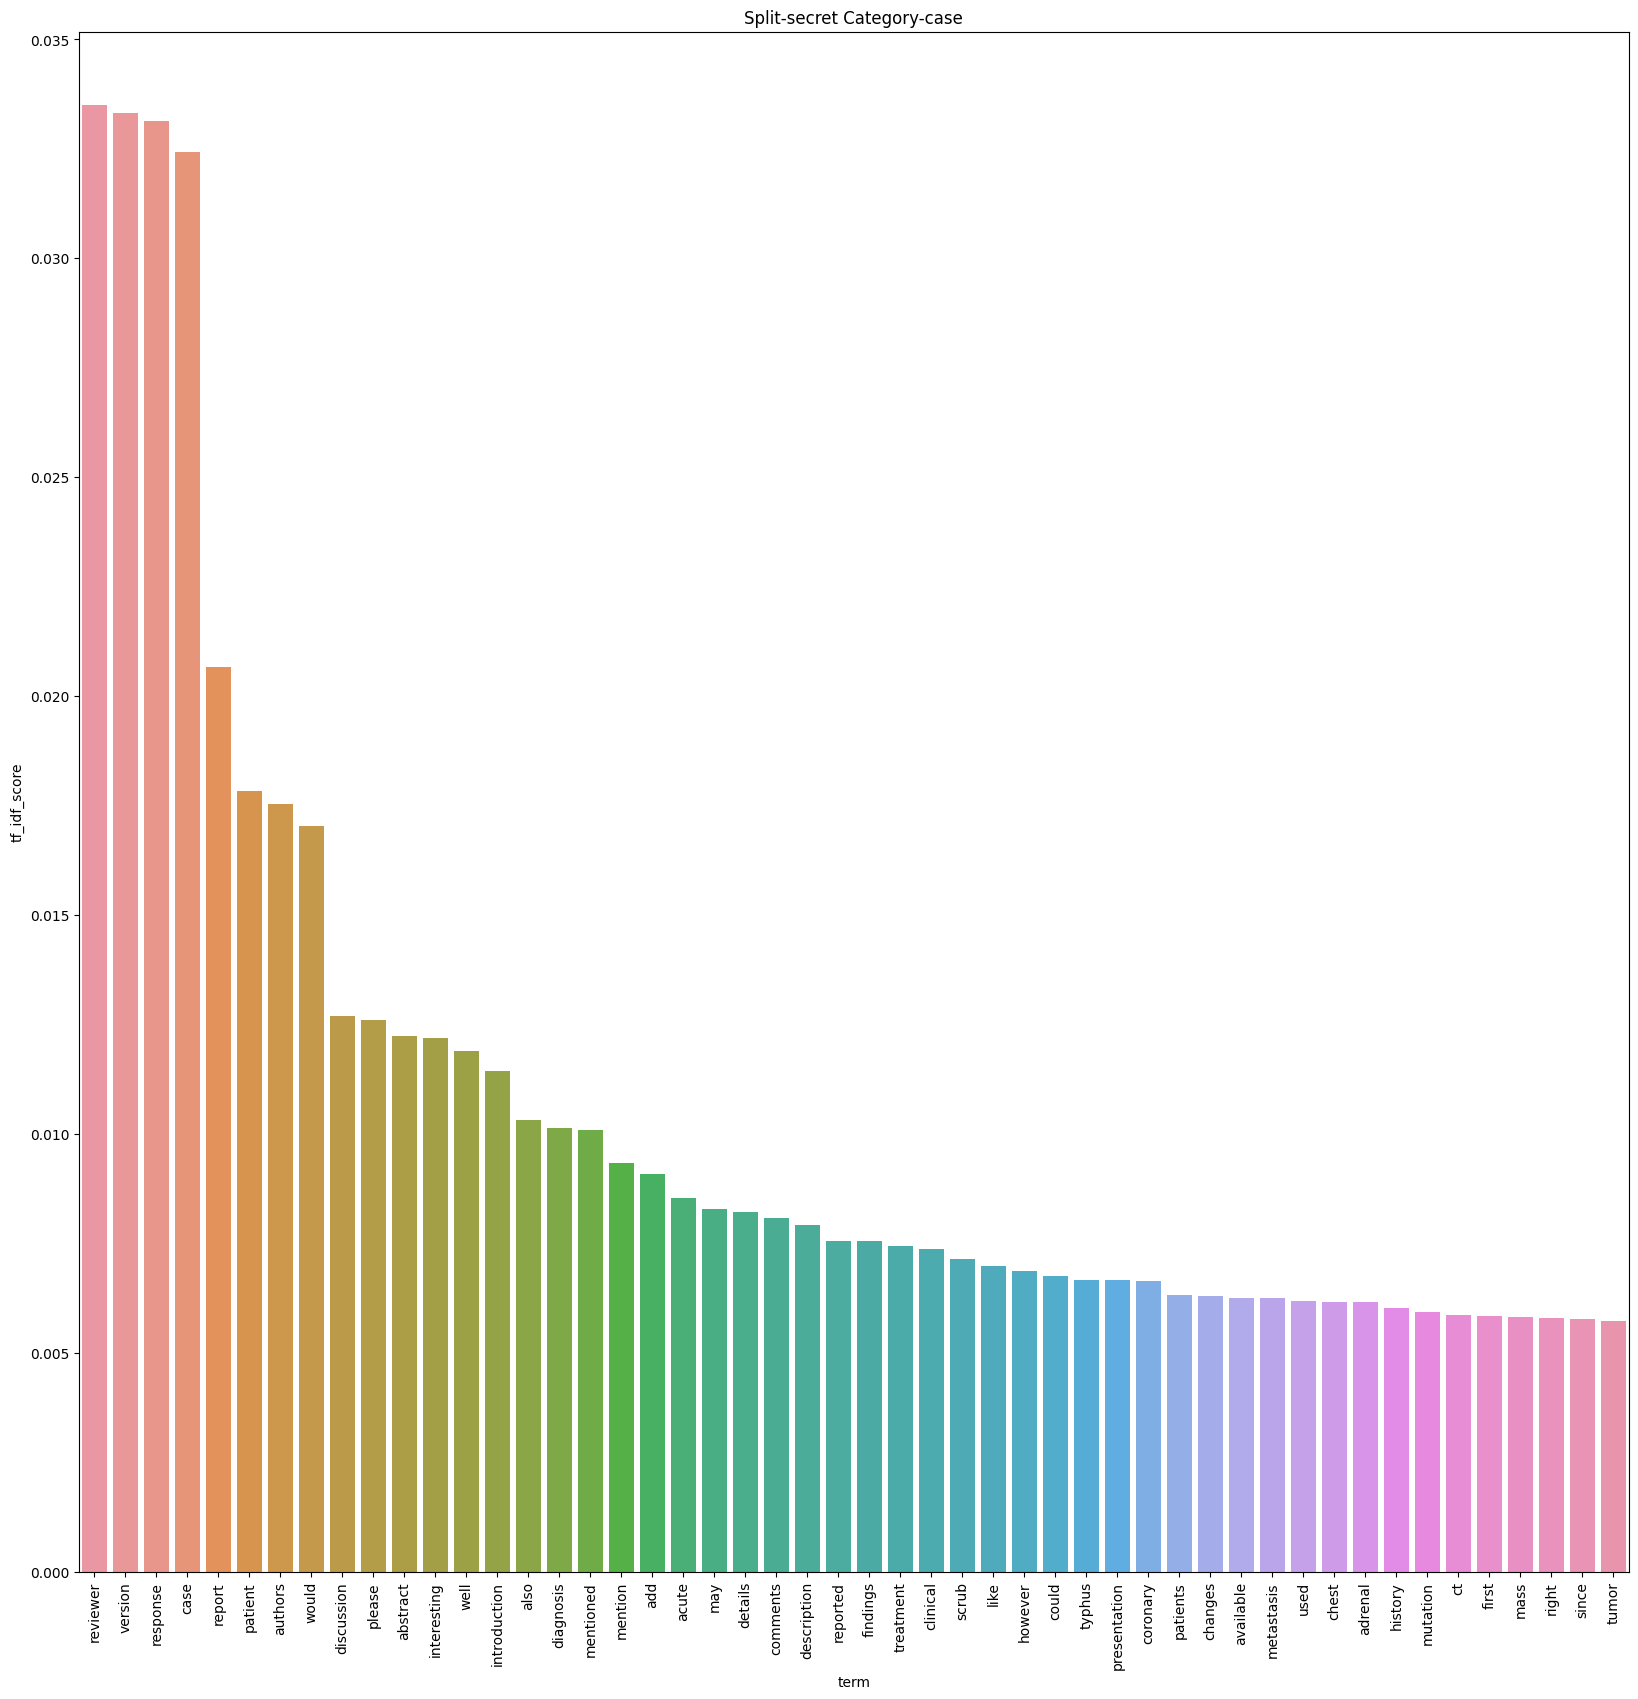

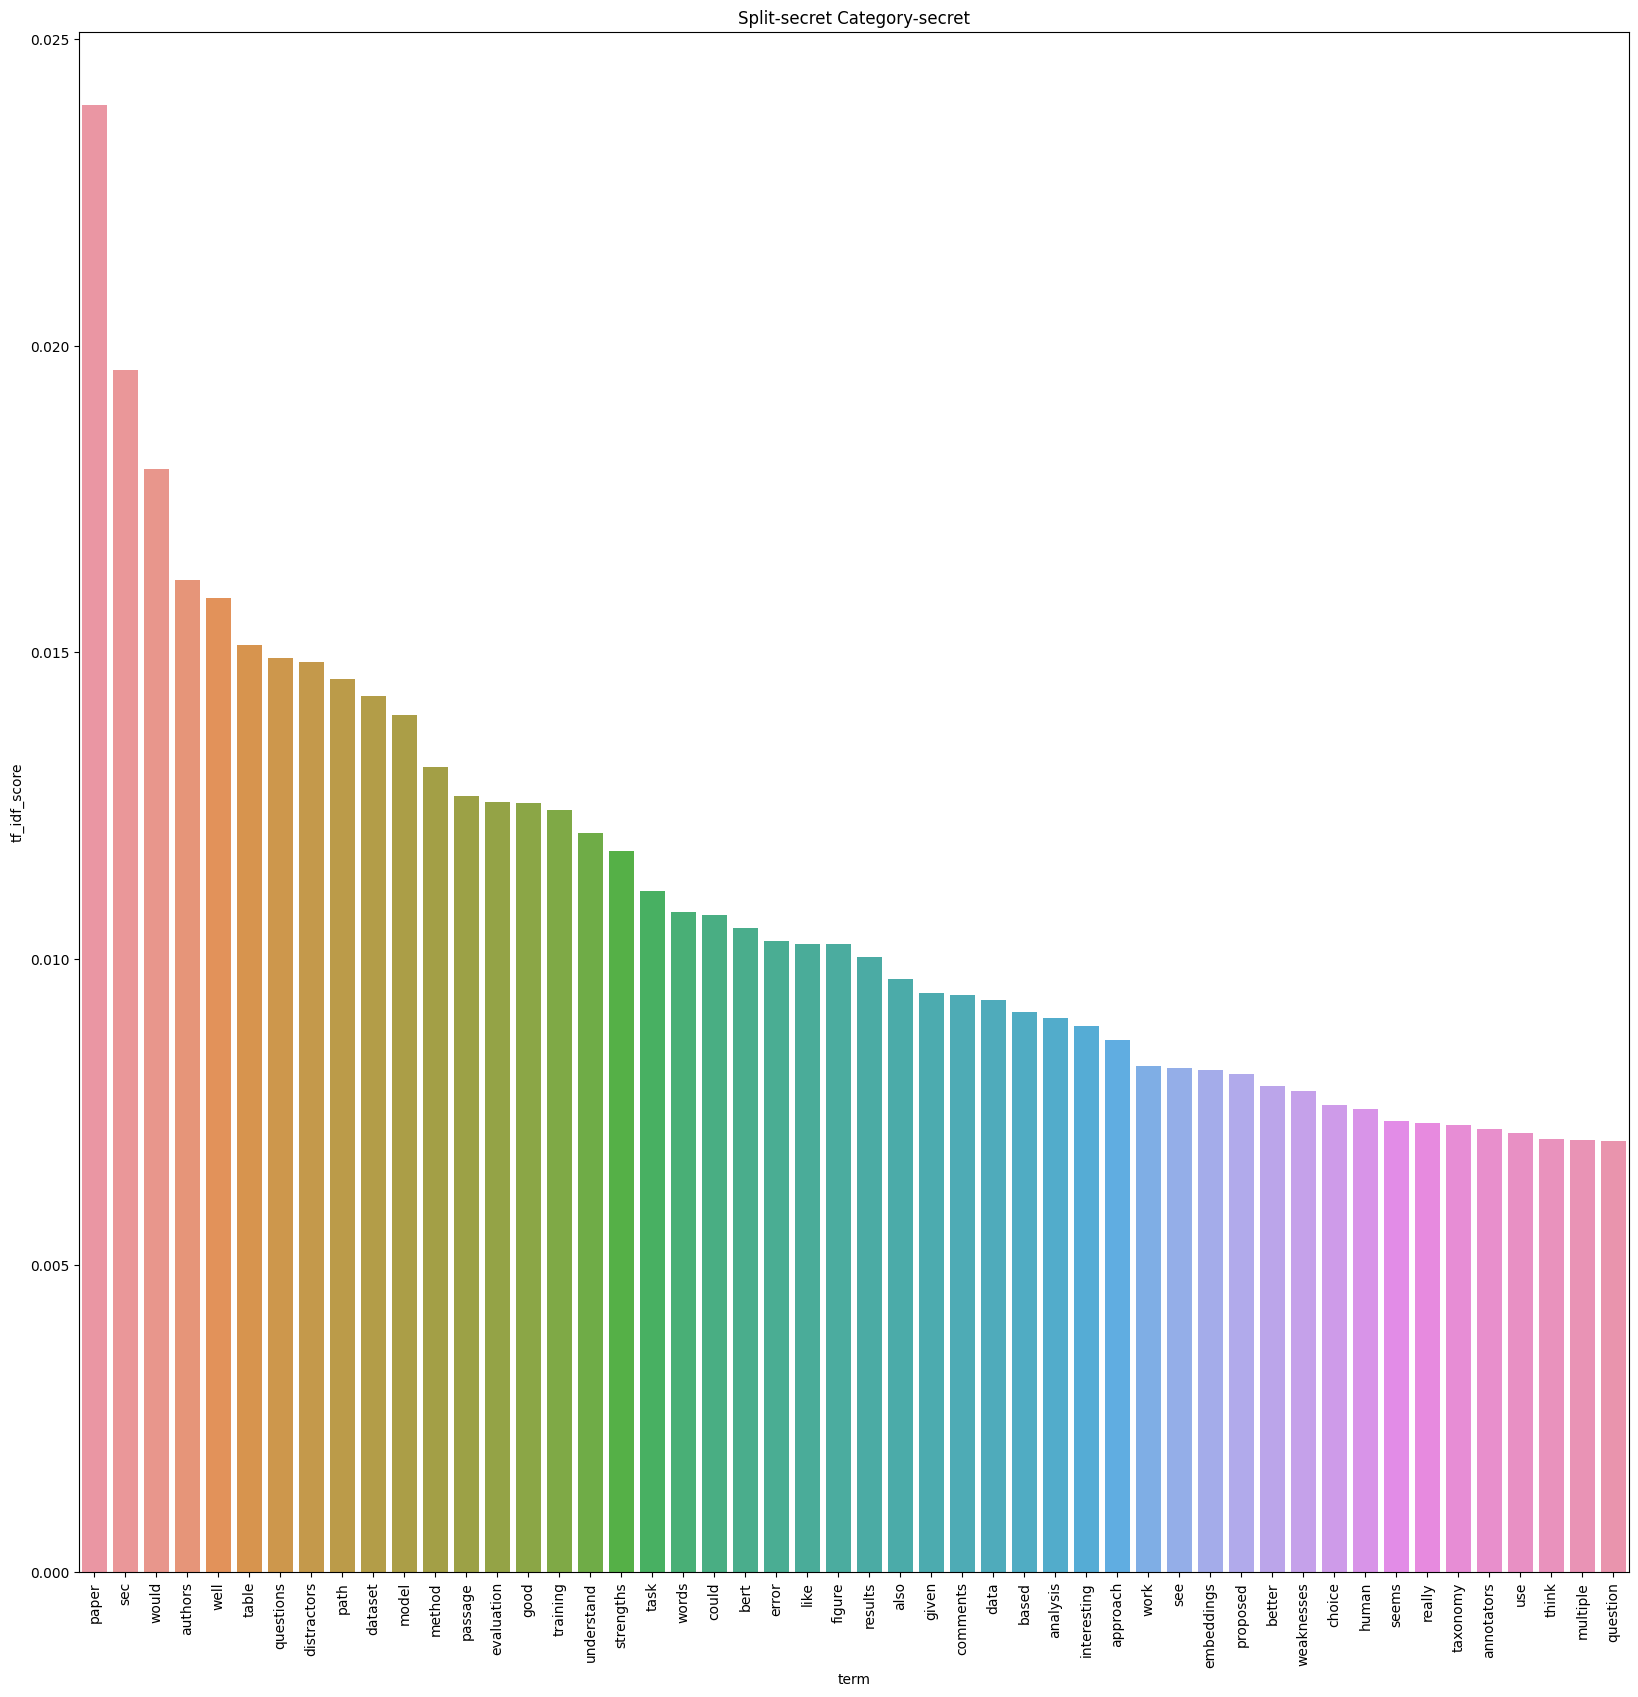

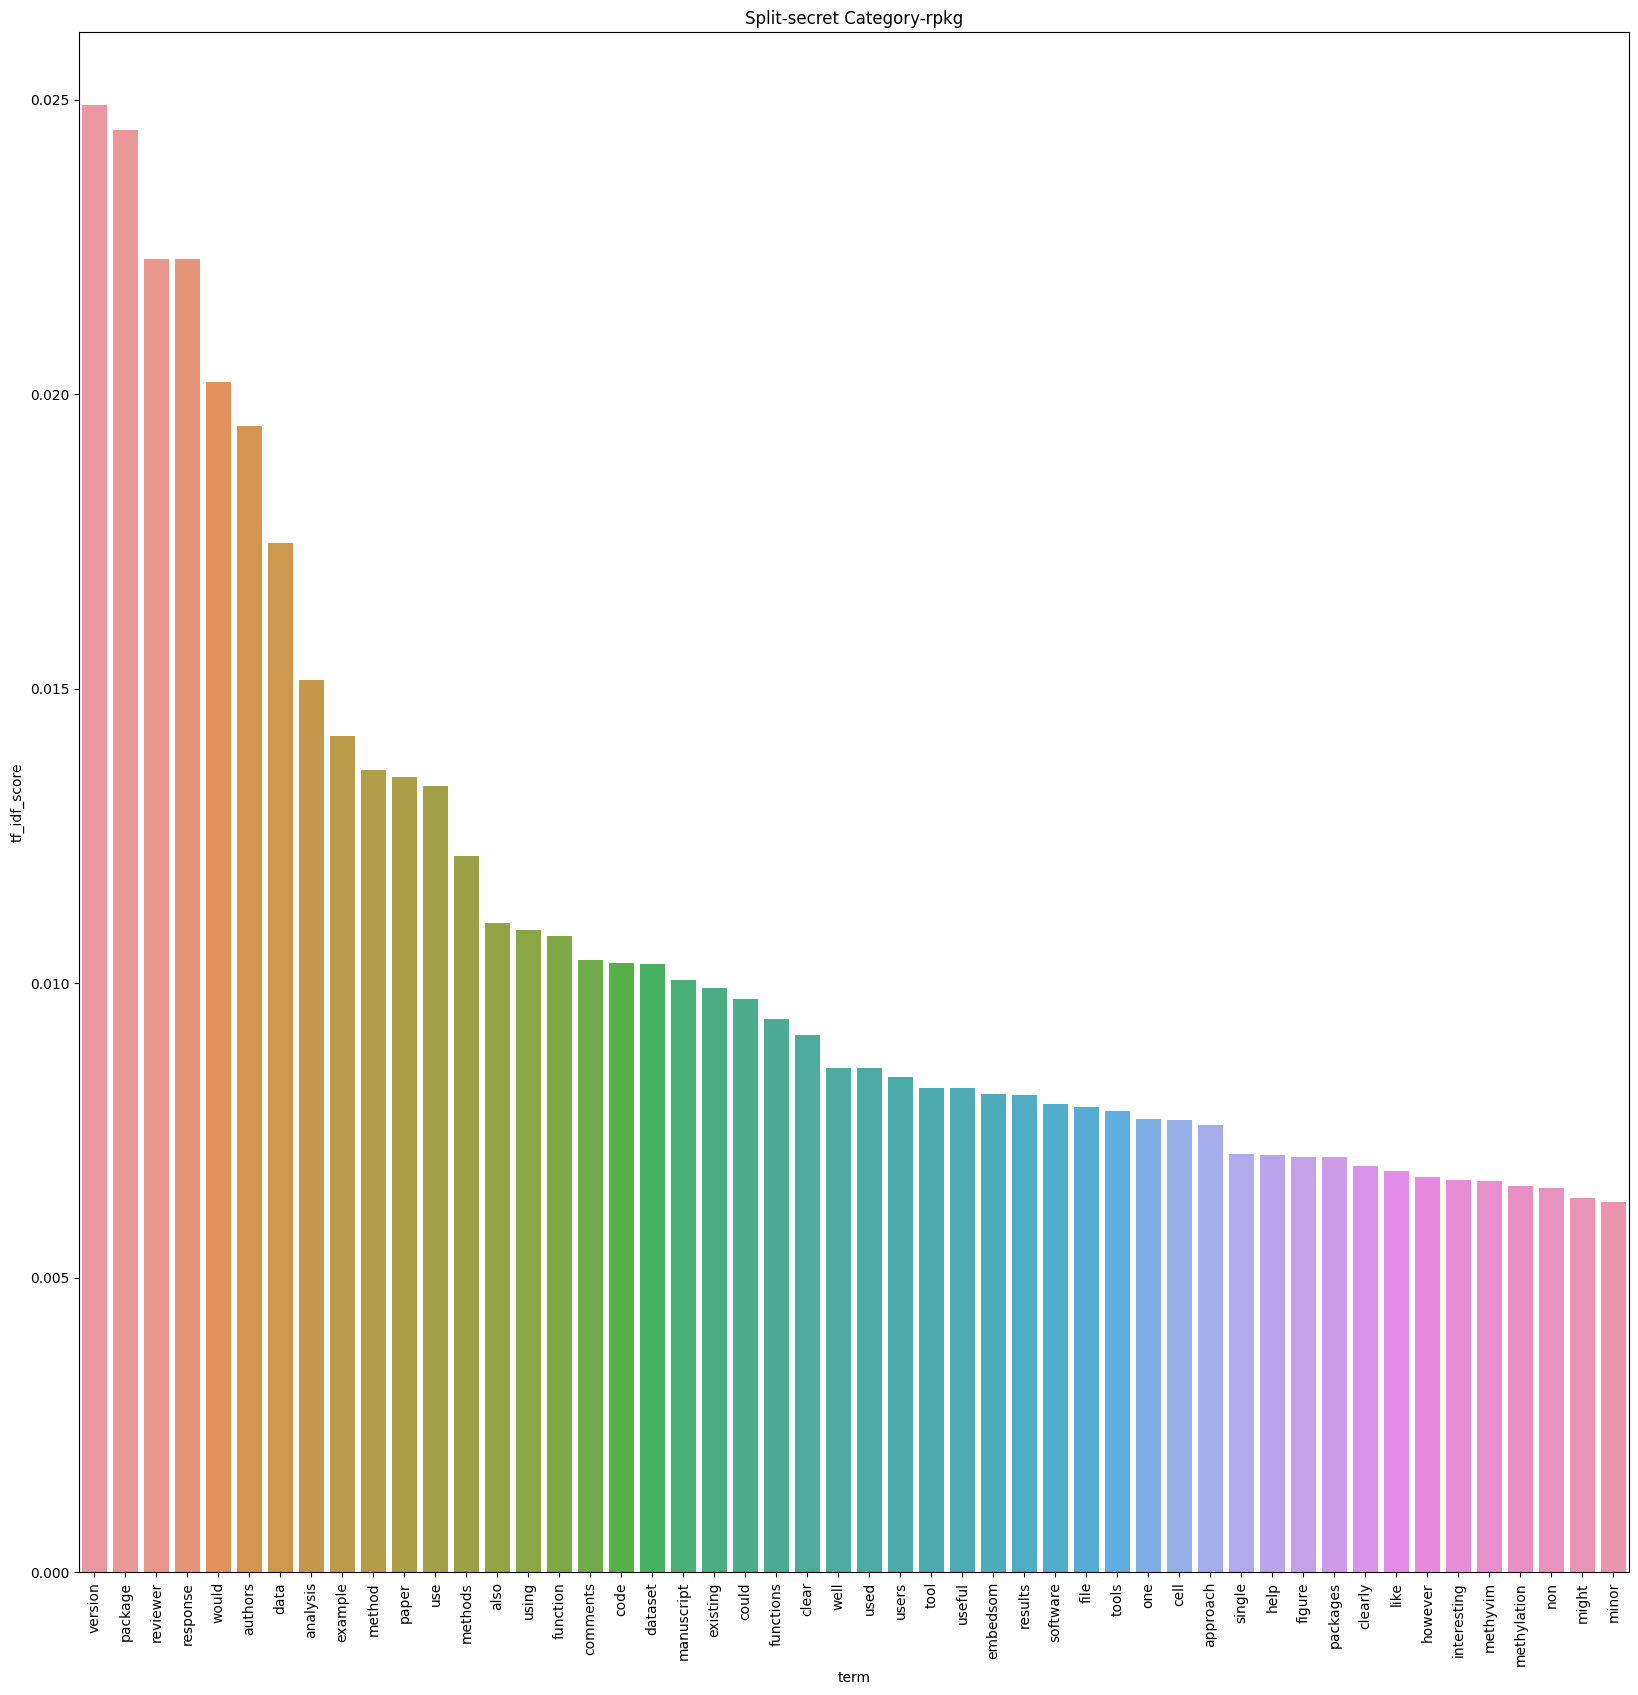

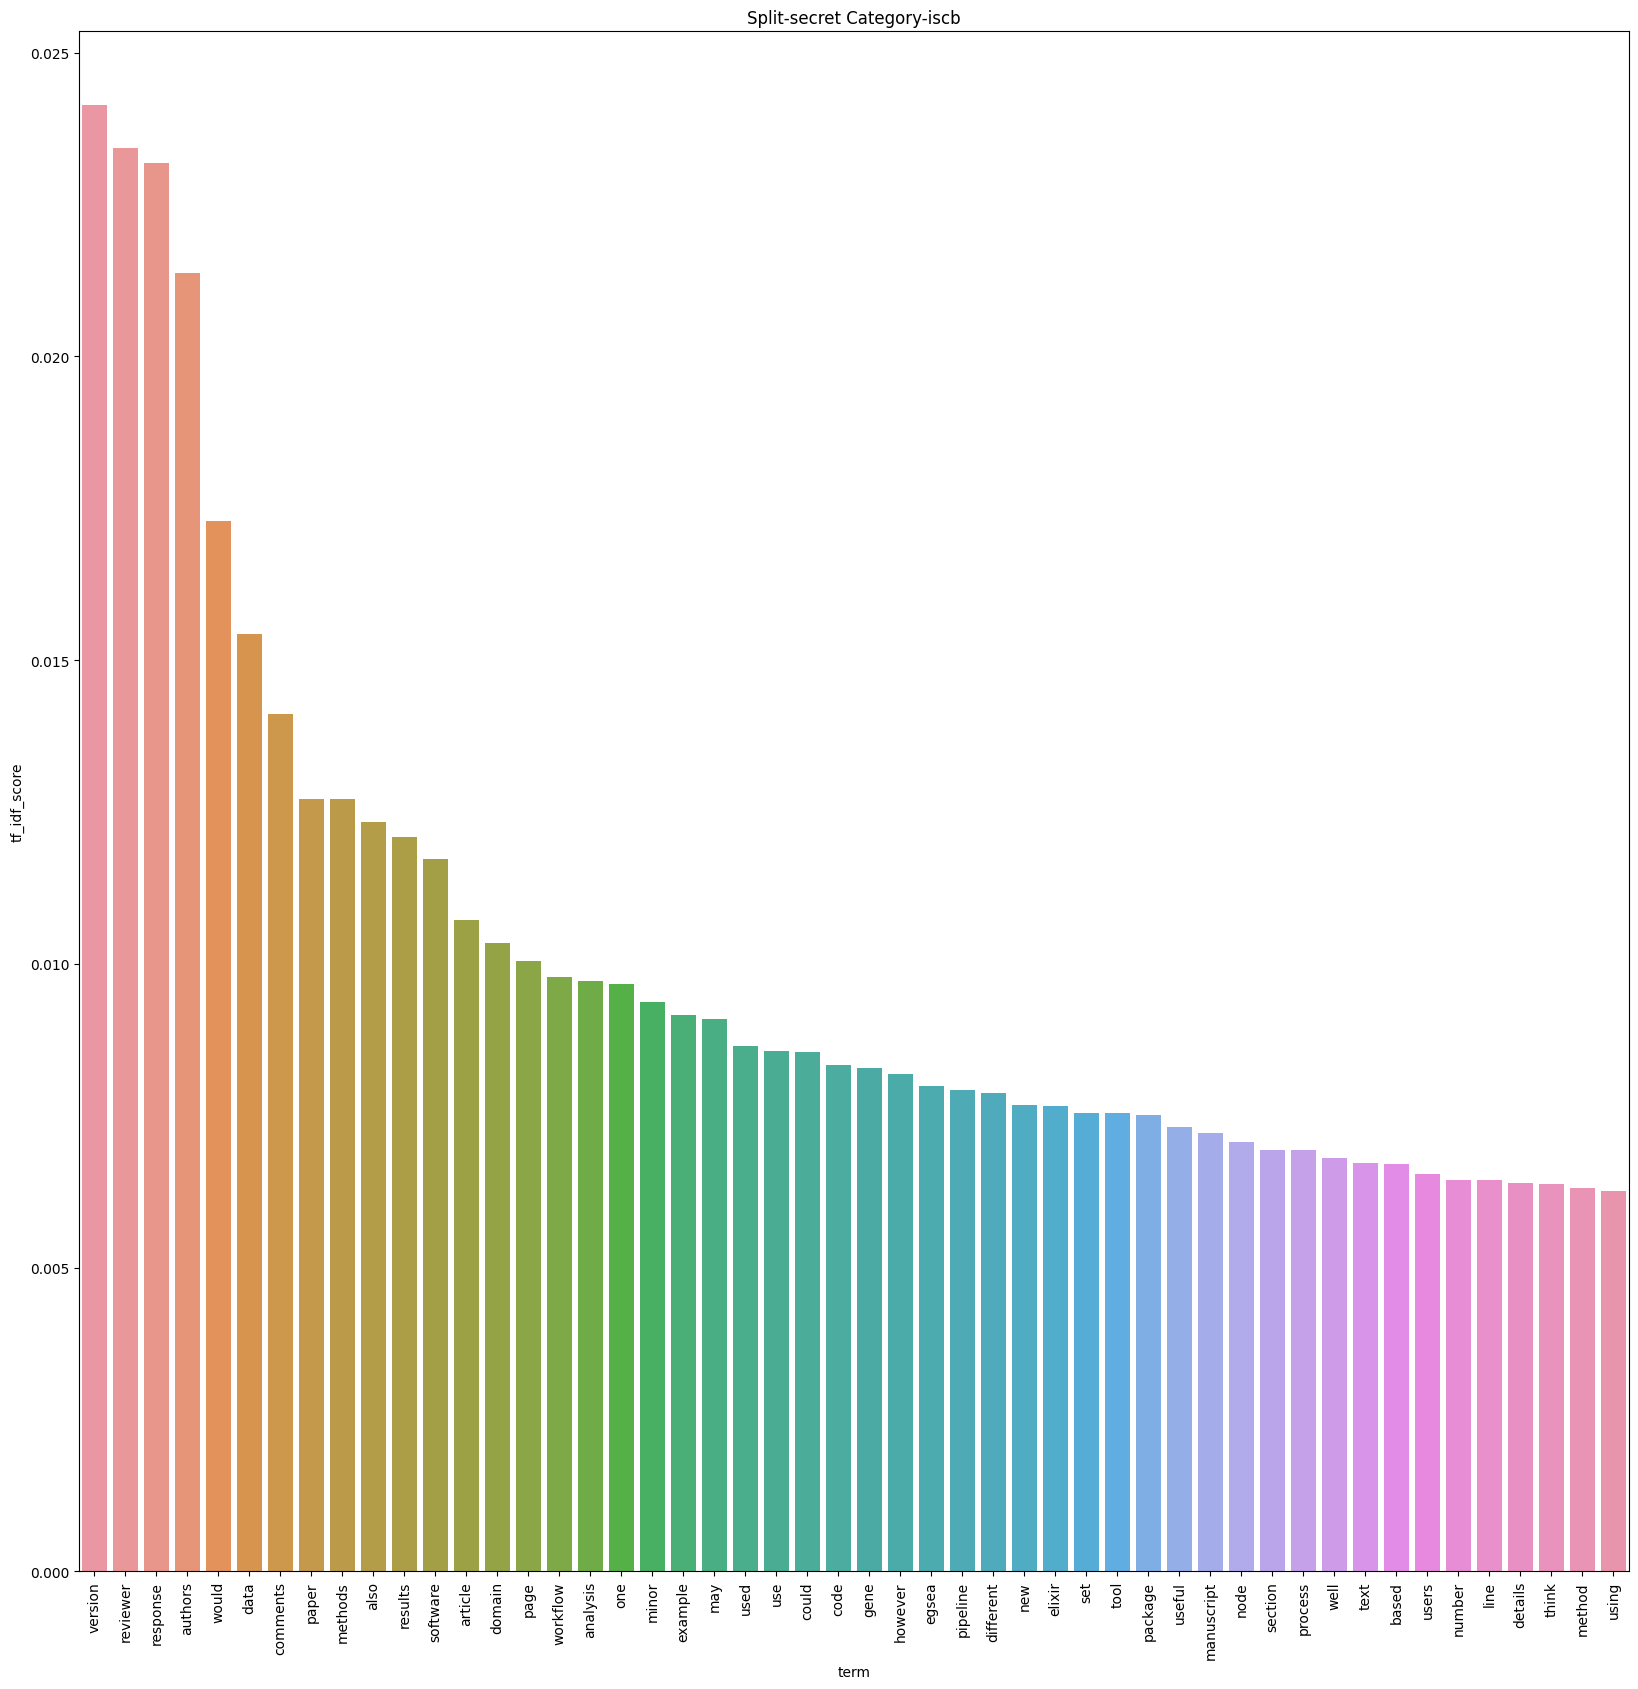

In [15]:
test_file = Path.cwd().joinpath("public_secret","test_inputs.json")

with open(test_file,"r") as f:
    test_dict_data = json.load(f)
test_full_data = datasets.Dataset.from_list(to_context_free_format(test_file))
test_full_data = datasets.Dataset.from_list(to_context_free_format(test_file))
test_full_data_df = test_full_data.to_pandas()
category_vocab_dict = {}
category_vocab_dict["secret"] = create_wordcloud("secret",test_full_data_df)
for split in category_vocab_dict:
    for category in category_vocab_dict[split]:
        tmp_df = \
        pd.DataFrame.from_dict(category_vocab_dict[split][category]).T.reset_index()
        tmp_df.rename({0:"tf_idf_score","index":"term"},axis=1,inplace=True)
        tmp_df = tmp_df.iloc[:50,:]
        f = plt.figure()
        ax = sns.barplot(tmp_df,x="term",y="tf_idf_score",)
        ax.set_xticklabels(tmp_df["term"].tolist(),rotation=90)
        ax.set_title(f"Split-{split} Category-{category}")
        f.savefig(f"vocabulary-overlap-{split}-{category}.pdf", bbox_inches='tight')